In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import colorsys
import scipy.stats as st
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
# %matplotlib inline
import pickle as pk

In [2]:
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', #import the database
            skipinitialspace=True)

chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')] #select only for human species


chem_gene = {}        #create a dictionary
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',    #import the PPI
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

chem_gene_dictio_cleaned_ppi={}        #considering only the chemical perturbations that perturbs the interactome
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass

#Loading the disease-gene associations from Disegenet
gene_associations = pd.read_csv("input/Disease/all_gene_disease_associations.tsv",   
           delimiter= '\t',
           skipinitialspace=True)

gene_associations_filtered=gene_associations[gene_associations['score']>0.4]   #using a filtering score==4

diseases_genes_associated = {}     #creating a dictionary
for i,v in gene_associations_filtered.iterrows():
    try:
        diseases_genes_associated[v["diseaseName"]].append(v["geneSymbol"])
    except KeyError:
        diseases_genes_associated[v["diseaseName"]] = [v["geneSymbol"]]

diseases_genes_associated_ppi={}       #cleaning for those associations that have an encoded perturbation on the PPI
for k,v in diseases_genes_associated.items():
    gene_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            gene_list.append(gene)
        else:
            pass
    if len(gene_list)>0:
        diseases_genes_associated_ppi[k]=gene_list
    else:
        pass

18815
482935


In [ ]:
num_rep = int(sys.argv[1])
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', #import the database
            skipinitialspace=True)

chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')] #select only for human species


chem_gene = {}        #create a dictionary
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',    #import the PPI
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')


G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

chem_gene_dictio_cleaned_ppi={}        #considering only the chemical perturbations that perturbs the interactome
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass

#Loading the disease-gene associations from Disegenet
gene_associations = pd.read_csv("input/Disease/all_gene_disease_associations.tsv",   
           delimiter= '\t',
           skipinitialspace=True)

gene_associations_filtered=gene_associations[gene_associations['score']>0.4]   #using a filtering score==4

diseases_genes_associated = {}     #creating a dictionary
for i,v in gene_associations_filtered.iterrows():
    try:
        diseases_genes_associated[v["diseaseName"]].append(v["geneSymbol"])
    except KeyError:
        diseases_genes_associated[v["diseaseName"]] = [v["geneSymbol"]]

diseases_genes_associated_ppi={}       #cleaning for those associations that have an encoded perturbation on the PPI
for k,v in diseases_genes_associated.items():
    gene_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            gene_list.append(gene)
        else:
            pass
    if len(gene_list)>0:
        diseases_genes_associated_ppi[k]=gene_list
    else:
        pass


#Let's import the pre-calculated spl dictionary
#This was calculated in the script: PPI_spl.py
with open('intermediate/ppi_spl.pickle', 'rb') as handle:
    spl = pk.load(handle)

def random_selection(G,size):                  #this function will create a a random sample geneset of the same size
    while True:
        rnd_sample=rd.sample(G.nodes(),size)
        if 'nan' in rnd_sample:
            rnd_sample=rd.sample(G.nodes(),size)
        else:
            break
    return rnd_sample

def calculate_closest_distance(G_ppi_lcc,spl, nodes_from, nodes_to):   #this function will calculate the closest distance
    values_outer = []
    for node_from in nodes_from:
        values = []
        for node_to in nodes_to:
            if node_from==node_to:
                val =0
            else:
                try:
                    try:
                        val = spl[node_from,node_to]
                    except:
                        val = spl[node_to,node_from]
                except:
                    val=len(nx.shortest_path(G_ppi_lcc,source=node_from, target=node_to))
            values.append(val)
        d = min(values)
        #print d,
        values_outer.append(d)
    d = np.mean(values_outer)
    #print d
    return d

#Let's create a list that contain the sizes of the disease genesets
disease_geneset_distribution=[]
for v in diseases_genes_associated_ppi.values():
    disease_geneset_distribution.append(len(v))

#Let's create a list that contain the sizes of the disease genesets
exposure_geneset_distribution=[]
for v in chem_gene_dictio_cleaned_ppi.values():
    exposure_geneset_distribution.append(len(v))


exposure_geneset_distribution=list(set(exposure_geneset_distribution))
chunks = [exposure_geneset_distribution[x:x+10] for x in range(0, len(exposure_geneset_distribution), 10)]


#Let's define the random expecation of the sizes that are presents in our two genesets
#running for 1000 times the distance coefficient of genesets matched with the
#size of our exposure_geneset_distribution and disease_geneset_distribution
exp_random_distance={}
for exp_size in chunks[num_rep]:
    for dis_size in set(disease_geneset_distribution):
        S = 1000
        l_rnd_dist = []
        for s in range(S):
            rnd_exp_set=random_selection(G_ppi_lcc,exp_size)
            rnd_dis_set=random_selection(G_ppi_lcc,dis_size)
            rnd_dist=calculate_closest_distance(G_ppi_lcc,spl,rnd_exp_set,rnd_dis_set)
            l_rnd_dist.append(rnd_dist)
        mu = np.mean(l_rnd_dist)
        std = np.std(l_rnd_dist)
        exp_random_distance[exp_size,dis_size]=[mu,std]

#Let's save it
with open('output/exp_random/exp_random_distance_%s.pickle'%num_rep, 'wb') as handle:
    pk.dump(exp_random_distance, handle, protocol=pk.HIGHEST_PROTOCOL)


In [ ]:
exp_random_distance={}
for exp_size in exposure_geneset_distribution[0:11]:
    for dis_size in set(disease_geneset_distribution):
        S = 1000
        l_rnd_dist = []
        for s in range(S):
            rnd_exp_set=random_selection(G_ppi_lcc,exp_size)
            rnd_dis_set=random_selection(G_ppi_lcc,dis_size)
            rnd_dist=calculate_closest_distance(G_ppi_lcc,spl,rnd_exp_set,rnd_dis_set)
            l_rnd_dist.append(rnd_dist)
        mu = np.mean(l_rnd_dist)
        std = np.std(l_rnd_dist)
        exp_random_distance[exp_size,dis_size]=[mu,std]

with open('output/exp_random/exp_random_distance_0.pickle', 'wb') as handle:
    pk.dump(exp_random_distance, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
import pickle as pk   #we have to merge all the 46 pieces that we have run in parallel
dicts=[]
for i in range(46):
    with open('output/exp_random/exp_random_distance_%s.pickle' %i, 'rb') as handle:
        locals()["exp_random_distance_%s"%i] = pk.load(handle)
    dicts.append(locals()["exp_random_distance_%s"%i])


In [ ]:
super_dict={}
for i in range(len(dicts)):
    for k,v in dicts[i].items():
        super_dict[k]=v

In [ ]:
with open('output/exp_random/new_final_exp_random_distance.pickle', 'wb') as handle:
    pk.dump(super_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
def calculate_proximity(network,spl, nodes_from, nodes_to, exp_random):   #let's calculate the proximity between the two sets
    d=calculate_closest_distance(network,spl,nodes_from,nodes_to)         #exposure and disease genesets
    m=exp_random[len(nodes_from),len(nodes_to)][0]
    s=exp_random[len(nodes_from),len(nodes_to)][1]
    if s == 0:
        z = 0.0
    else:
        z = (d - m) / s
    return d, z, (m, s) #(z, pval)

In [ ]:
exp_dis_proximity={}                           #let's create a dictionary that recapitulates what found so far
for exp in chem_gene_dictio_cleaned_ppi.keys():
    for dis in diseases_genes_associated_ppi.keys():
        exp_dis_proximity[exp,dis]=calculate_proximity(G_ppi_lcc,spl,chem_gene_dictio_cleaned_ppi[exp],diseases_genes_associated_ppi[dis],final_exp_random)


In [ ]:
with open('output/exp_random/new_final_exp_proximity.pickle', 'wb') as handle:   #let's save it
    pk.dump(exp_dis_proximity, handle, protocol=pk.HIGHEST_PROTOCOL)

In [2]:
with open('output/exp_random/new_final_exp_proximity.pickle', 'rb') as handle:    #let's read it
    final_exp_proximity = pk.load(handle)

In [ ]:
#The len of the new_final_exp_proximity is 60855804

In [ ]:
#I am converting to a p-val considering a left-tailed test
import scipy.stats
exp_dis_proximity_pval={}
for k,v in exp_dis_proximity.items():
    exp_dis_proximity_pval[k]=scipy.stats.norm.sf(abs(v[1]))



In [ ]:
import statsmodels.stats as stat                          #here, we apply a FDR adjustment on the p-values calculated
def fdr_adjustment(list_of_pvals):                        #by the conversion of the z-score that was resulted from the
    return stat.multitest.fdrcorrection(list_of_pvals)[1] #network proximity
    

adj_pvals=fdr_adjustment(list(exp_dis_proximity_pval.values()))
exp_keys_list=list(exp_dis_proximity_pval.keys())
exp_dis_proximity_pval_adj={}
for el in range(len(exp_keys_list)):
    exp_dis_proximity_pval_adj[exp_keys_list[el]]=adj_pvals[el]


significant_exp_dis_proximity_pval_adj={}
for k,v in exp_dis_proximity_pval_adj.items():
    if v<0.05:
        significant_exp_dis_proximity_pval_adj[k]=v
    else:
        pass

In [ ]:
with open('output/exp_random/new_significant_exp_dis_proximity_pval_adj.pickle', 'wb') as handle:
    pk.dump(significant_exp_dis_proximity_pval_adj, handle, protocol=pk.HIGHEST_PROTOCOL)

In [74]:
import pickle as pk
with open('output/exp_random/new_significant_exp_dis_proximity_pval_adj.pickle', 'rb') as handle:
    new_significant_exp_dis_proximity_pval_adj = pk.load(handle)

In [4]:
len(new_significant_exp_dis_proximity_pval_adj)

1601884

In [ ]:
faraway_exp_dis_dict = {}
for k,v in final_exp_proximity.items():
    if v[1]>2:
        faraway_exp_dis_dict[k]=v[1]
with open('output/faraway_exp_dis_dict.pickle', 'wb') as handle:
    pk.dump(faraway_exp_dis_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
#Let's see the correlation between the number of times which an exposure or a disease is involved in statistically
#significant proximal relationships and their geneset size.
sig_exp_list=[]
sig_dis_list=[]
for k,v in new_significant_exp_dis_proximity_pval_adj.items():
    sig_exp_list.append(k[0])
    sig_dis_list.append(k[1])

sig_exp_list_count_dict=dict(Counter(sig_exp_list))
sig_dis_list_count_dict=dict(Counter(sig_dis_list))

sig_exp_geneset_size_list=[]
sig_dis_geneset_size_list=[]
sig_exp_count_list=[]
sig_dis_count_list=[]
for dis,count in sig_dis_list_count_dict.items():
    sig_dis_geneset_size_list.append(len(diseases_genes_associated_ppi[dis]))
    sig_dis_count_list.append(count)
    
for exp,count in sig_exp_list_count_dict.items():
    sig_exp_geneset_size_list.append(len(chem_gene_cleaned[exp]))
    sig_exp_count_list.append(count)
    
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 10), dpi=80, facecolor='w', edgecolor='k')

print(scipy.stats.pearsonr(sig_exp_geneset_size_list,sig_exp_count_list))  # Pearson's r
print(scipy.stats.spearmanr(sig_exp_geneset_size_list,sig_exp_count_list)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(sig_exp_geneset_size_list, sig_exp_count_list)
fig, ax = plt.subplots()
ax.plot(sig_exp_geneset_size_list,sig_exp_count_list, linewidth=0, marker='s', label='Exposure')
y=[]
for i in sig_exp_geneset_size_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(sig_exp_geneset_size_list, y, label=line)
ax.set_xlabel('Exposure geneset size')
ax.set_ylabel('Number of statistically significant proximal diseases')

plt.title('Correlation between geneset size and proximity for exposures' )
ax.legend(facecolor='white')
plt.show()


from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 10), dpi=80, facecolor='w', edgecolor='k')

print(scipy.stats.pearsonr(sig_dis_geneset_size_list,sig_dis_count_list))  # Pearson's r
print(scipy.stats.spearmanr(sig_dis_geneset_size_list,sig_dis_count_list)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(sig_dis_geneset_size_list, sig_dis_count_list)
fig, ax = plt.subplots()
ax.plot(sig_dis_geneset_size_list,sig_dis_count_list, linewidth=0, marker='s', label='Disease')
y=[]
for i in sig_dis_geneset_size_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(sig_dis_geneset_size_list, y, label=line)
ax.set_xlabel('Disease geneset size')
ax.set_ylabel('Number of statistically significant proximal exposures')

plt.title('Correlation between geneset size and proximity for diseases' )
ax.legend(facecolor='white')
plt.show()

In [ ]:
#This is the dictionary of pairs which are not statistically significant proximate
exp_dis_significant_pair=list(new_significant_exp_dis_proximity_pval_adj.keys())
exp_proximity_not_significant={}
for k,v in final_exp_proximity.items():
    if k not in exp_dis_significant_pair:
        exp_proximity_not_significant[k]=v
        
with open('intermediate/exp_proximity_not_significant.pickle', 'wb') as handle:
    pk.dump(exp_proximity_not_significant, handle, protocol=pk.HIGHEST_PROTOCOL)

In [41]:

#First, we have to import the non-significant associations
with open('intermediate/exp_proximity_not_significant.pickle', 'rb') as handle:
    exp_proximity_not_significant = pk.load(handle)
    


In [ ]:
#Let's see what happens with different threshold of z-score

In [ ]:
z_score_threshold=[-2,-3,-4,-5,-6,-7,-8,-9,-10]
num_of_sig_associations=[]
for z_score in z_score_threshold:
    significant_final_exp_proximity={}
    for k,v in exp_dis_proximity.items():
        if float(v[1])<z_score:
            significant_final_exp_proximity[k]=v
        else:
            pass
    num_of_sig_associations.append(len(significant_final_exp_proximity))

In [ ]:
num_of_sig_associations=[7832861, 1485150, 420090, 176259, 87853, 45087, 23260, 11824, 6016]

In [ ]:
#Here, we show the number of edges with just adjusted p-value considering different p-value threshold
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

label=[-2,-3,-4,-5,-6,-7,-8,-9,-10]

figure(num=None, figsize=(24, 10), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(9)


plt.bar(x, num_of_sig_associations)
plt.title('Number of statistically significant associations',fontsize=32)
plt.ylabel('Number of associations',fontsize=20)
plt.xlabel('z-score',fontsize=20)
plt.xticks(x, label,fontsize=10)
#plt.tight_layout()
plt.show()

In [ ]:
#A reasonable number for a p-value of 0.05 corrected for the number of comparison should be z-score=-5


In [ ]:
real_significant_final_exp_proximity={}
for k,v in exp_dis_proximity.items():
    if float(v[1])<-5:
        real_significant_final_exp_proximity[k]=v
    else:
        pass

In [ ]:
with open('output/exp_random/real_significant_final_exp_proximity.pickle', 'wb') as handle:
    pk.dump(real_significant_final_exp_proximity, handle, protocol=pk.HIGHEST_PROTOCOL)

In [3]:
with open('output/exp_random/real_significant_final_exp_proximity.pickle', 'rb') as handle:
    real_significant_final_exp_proximity = pk.load(handle)

In [4]:
len(real_significant_final_exp_proximity)

176259

In [ ]:
dis_set=[]
for chem_dis in real_significant_final_exp_proximity.keys():
    dis_set.append(chem_dis[1])
print(len(set(dis_set)))

In [ ]:
for k,v in real_significant_final_exp_proximity.items():
    if k[0]=='C006780':
        print(k[1],v)

In [ ]:
import scipy.stats as stats
def overlap_set_prediction(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M=  background #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

In [ ]:

#Let me just try with the simple overlap (Fisher test +FDR correction)


def overlap_set_exposures(lstA, lstB):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    setA= set(lstA)
    setB= set(lstB)
    M= G_ppi.number_of_nodes() #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

exp_dis_overlap={}
for exp in chem_gene_dictio_cleaned_ppi.keys():
    for dis in diseases_genes_associated_ppi.keys():
        exp_dis_overlap[exp,dis]=overlap_set_exposures(chem_gene_dictio_cleaned_ppi[exp],diseases_genes_associated_ppi[dis])



def fdr_adjustment(list_of_pvals):    
    return stat.multitest.fdrcorrection(list_of_pvals)[1]
    
exp_dis_overlap_float={}
for k,v in exp_dis_overlap.items():
    exp_dis_overlap_float[k]=float(v)
adj_pvals=fdr_adjustment(list(exp_dis_overlap_float.values()))
exp_keys_list=list(exp_dis_overlap_float.keys())
exp_dis_overlap_adj={}
for el in range(len(exp_keys_list)):
    exp_dis_overlap_adj[exp_keys_list[el]]=adj_pvals[el]


signficant_exp_dis_overlap_adj={}
for k,v in exp_dis_overlap_adj.items():
    if v<0.05:
        signficant_exp_dis_overlap_adj[k]=v
    else:
        pass


with open('output/exp_random/new_signficant_exp_dis_overlap_adj.pickle', 'wb') as handle:
    pk.dump(signficant_exp_dis_overlap_adj, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
import pickle as pk
with open('output/exp_random/new_signficant_exp_dis_overlap_adj.pickle', 'rb') as handle:
    signficant_exp_dis_overlap_adj = pk.load(handle)

In [ ]:
len(signficant_exp_dis_overlap_adj)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

# Use the venn2 function
v=venn2(subsets = (len(set(signficant_exp_dis_overlap_adj.keys())), len(set(new_significant_exp_dis_proximity_pval_adj.keys())), len(set(signficant_exp_dis_overlap_adj.keys())&set(new_significant_exp_dis_proximity_pval_adj.keys()))), set_labels = ('Classical Overlap', 'Network Proximity'))
c=venn2_circles(subsets = (len(set(signficant_exp_dis_overlap_adj.keys())), len(set(new_significant_exp_dis_proximity_pval_adj.keys())), len(set(signficant_exp_dis_overlap_adj.keys())&set(new_significant_exp_dis_proximity_pval_adj.keys()))),linewidth=1,color="grey",alpha=0.7)
#c=venn2_circles(subsets = (10, 8, 22, 6,9,4,2), linestyle='dashed', linewidth=1, color="grey")

v.get_label_by_id("100").set_x(-0.75)



c[0].set_color('green')
c[1].set_color('skyblue')
c[0].set_color('green')
plt.savefig('output/Figures/SF8A.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [540]:
#Let's see the location of the real exposures (z-scores<-5)

#Here, we import the lists of hub exposures, central module exposures, peripheric exposures and no hub no module exposures
hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/Hub_expusres.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))

In [8]:
exp_sig_list=[]
for exp_pair in new_significant_exp_dis_proximity_pval_adj.keys():
    exp_sig_list.append(exp_pair[0])

len(set(exp_sig_list))

9852

In [9]:
hub_exposures_proportion=len(set(exp_sig_list)&set(hub_exposures_list))/len(set(exp_sig_list))
central_module_exposures_proportion=len(set(exp_sig_list)&set(central_module_exposures_list))/len(set(exp_sig_list))
peripheric_module_exposures_proportion=len(set(exp_sig_list)&set(peripheric_module_exposures_list))/len(set(exp_sig_list))
no_central_no_module_exposures_proportion=len(set(exp_sig_list)&set(no_central_no_module_exposures_list))/len(set(exp_sig_list))


print(hub_exposures_proportion)
print(central_module_exposures_proportion)
print(peripheric_module_exposures_proportion)
print(no_central_no_module_exposures_proportion)



0.1480917580186764
0.4298619569630532
0.07998375964271214
0.34206252537555826


In [ ]:
#Let's import the EEN
final_backbone_exp_graph_significant_combo_df = pd.read_csv("output/final_backbone_exp_graph_significant_combo_df.tsv", sep="\t",index_col=0)
backbone_ss_exposure_network = nx.from_pandas_edgelist(final_backbone_exp_graph_significant_combo_df, 'Exp A', 'Exp B')


In [ ]:
#Let's see whether there is some prevalence in each cluster

In [84]:


with open('output/Communities/Louvain/ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)

In [150]:
fine_grained_communities_proximal_disease={}
for com, explist in fine_grained_communities_dict.items():
    def_dis_list=[]
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
    dis_count_com=Counter(dis_list)
    for dis,count in dis_count_com.items():
        if count>len(explist)/2:
            def_dis_list.append(dis)
            
    fine_grained_communities_proximal_disease[com]=def_dis_list

In [151]:

finegrained_diseases=[]
for dis_list in fine_grained_communities_proximal_disease.values():
    finegrained_diseases.extend(dis_list)

finegrained_diseases_count=Counter(finegrained_diseases)

In [153]:
middle_communities_proximal_disease={}
for com, explist in middle_communities_dict.items():
    def_dis_list=[]
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
    dis_count_com=Counter(dis_list)
    for dis,count in dis_count_com.items():
        if count>len(explist)/2:
            def_dis_list.append(dis)
            
    middle_communities_proximal_disease[com]=def_dis_list

In [154]:

middle_diseases=[]
for dis_list in middle_communities_proximal_disease.values():
    middle_diseases.extend(dis_list)

middle_diseases_count=Counter(middle_diseases)

In [156]:
broad_communities_proximal_disease={}
for com, explist in broad_communities_dict.items():
    def_dis_list=[]
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
    dis_count_com=Counter(dis_list)
    for dis,count in dis_count_com.items():
        if count>len(explist)/2:
            def_dis_list.append(dis)
            
    broad_communities_proximal_disease[com]=def_dis_list

In [157]:

broad_diseases=[]
for dis_list in broad_communities_proximal_disease.values():
    broad_diseases.extend(dis_list)

broad_diseases_count=Counter(broad_diseases)

In [161]:

broad_dis_dict = {}
tot_dis_list = []

for com,dislist in broad_communities_proximal_disease.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in broad_communities_proximal_disease.items():
        if dis in dislist:
            n_c = n_c +1
    broad_dis_dict[dis]=n_c

middle_dis_dict = {}
tot_dis_list = []

for com,dislist in middle_communities_proximal_disease.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in middle_communities_proximal_disease.items():
        if dis in dislist:
            n_c = n_c +1
    middle_dis_dict[dis]=n_c

fine_grained_dis_dict = {}
tot_dis_list = []

for com,dislist in fine_grained_communities_proximal_disease.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in fine_grained_communities_proximal_disease.items():
        if dis in dislist:
            n_c = n_c +1
    fine_grained_dis_dict[dis]=n_c

In [162]:
#Extract frequency from the dictionary
frequency_fine_grained = list(fine_grained_dis_dict.values())

frequency_fine_grained_unique = list(set(frequency_fine_grained))
frequency_fine_grained_unique.sort()


numcomfinegrained = []
numdis_fine_grainedcount = []

for fr in frequency_fine_grained_unique:
    numcomfinegrained.append(fr)
    numdis_fine_grainedcount.append(frequency_fine_grained.count(fr))


In [163]:
#Extract frequency from the dictionary
frequency_middle = list(middle_dis_dict.values())


frequency_middle_unique = list(set(frequency_middle))
frequency_middle_unique.sort()

numcommiddle = []
numdis_middlecount = []

for fr in frequency_middle_unique:
    numcommiddle.append(fr)
    numdis_middlecount.append(frequency_middle.count(fr))

In [164]:
#Extract frequency from the dictionary
frequency_broad = list(broad_dis_dict.values())


frequency_broad_unique = list(set(frequency_broad))
frequency_broad_unique.sort()

numcombroad = []
numdis_broadcount = []

for fr in frequency_broad_unique:
    numcombroad.append(fr)
    numdis_broadcount.append(frequency_broad.count(fr))


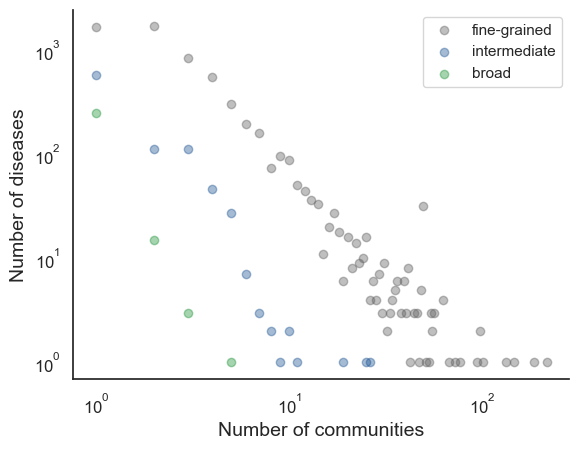

In [180]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

#Let's plot the Degree distribution of the EEN
fig1, ax1 = plt.subplots()

plt.scatter(numcomfinegrained,numdis_fine_grainedcount, c='#5F5F5F', alpha=0.4)
plt.scatter(numcommiddle,numdis_middlecount, c='#1e5594', alpha=0.4)
plt.scatter(numcombroad,numdis_broadcount, c='#1e9439', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of communities', fontsize=14)
plt.ylabel('Number of diseases', fontsize=14)


plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(["fine-grained" , "intermediate","broad"])

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF8C_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()
plt.close()

In [87]:
fine_grained_communities_proximal_disease_ext={}
for com, explist in fine_grained_communities_dict.items():
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
    fine_grained_communities_proximal_disease_ext[com]=set(dis_list)

In [88]:

finegrained_diseases=[]
for dis_list in fine_grained_communities_proximal_disease_ext.values():
    finegrained_diseases.extend(dis_list)

finegrained_diseases_count=Counter(finegrained_diseases)

In [90]:
middle_communities_proximal_disease_ext={}
for com, explist in middle_communities_dict.items():
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
            
    middle_communities_proximal_disease_ext[com]=set(dis_list)

In [91]:

middle_diseases=[]
for dis_list in middle_communities_proximal_disease_ext.values():
    middle_diseases.extend(dis_list)

middle_diseases_count=Counter(middle_diseases)

In [93]:
broad_communities_proximal_disease_ext={}
for com, explist in broad_communities_dict.items():
    dis_list=[]
    for exp in explist:
        for pair in new_significant_exp_dis_proximity_pval_adj.keys():
            if exp==pair[0]:
                dis_list.append(pair[1])
            
    broad_communities_proximal_disease_ext[com]=set(dis_list)

In [94]:

broad_diseases=[]
for dis_list in broad_communities_proximal_disease_ext.values():
    broad_diseases.extend(dis_list)

broad_diseases_count=Counter(broad_diseases)

In [98]:

broad_dis_dict = {}
tot_dis_list = []

for com,dislist in broad_communities_proximal_disease_ext.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in broad_communities_proximal_disease_ext.items():
        if dis in dislist:
            n_c = n_c +1
    broad_dis_dict[dis]=n_c

middle_dis_dict = {}
tot_dis_list = []

for com,dislist in middle_communities_proximal_disease_ext.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in middle_communities_proximal_disease_ext.items():
        if dis in dislist:
            n_c = n_c +1
    middle_dis_dict[dis]=n_c

fine_grained_dis_dict = {}
tot_dis_list = []

for com,dislist in fine_grained_communities_proximal_disease_ext.items():
    tot_dis_list.extend(dislist)

for dis in set(tot_dis_list):
    n_c=0
    for com,dislist in fine_grained_communities_proximal_disease_ext.items():
        if dis in dislist:
            n_c = n_c +1
    fine_grained_dis_dict[dis]=n_c

In [110]:
#Extract frequency from the dictionary
frequency_fine_grained = list(fine_grained_dis_dict.values())

frequency_fine_grained_unique = list(set(frequency_fine_grained))
frequency_fine_grained_unique.sort()


numcomfinegrained = []
numdis_fine_grainedcount = []

for fr in frequency_fine_grained_unique:
    numcomfinegrained.append(fr)
    numdis_fine_grainedcount.append(frequency_fine_grained.count(fr))


In [128]:
#Extract frequency from the dictionary
frequency_middle = list(middle_dis_dict.values())


frequency_middle_unique = list(set(frequency_middle))
frequency_middle_unique.sort()

numcommiddle = []
numdis_middlecount = []

for fr in frequency_middle_unique:
    numcommiddle.append(fr)
    numdis_middlecount.append(frequency_middle.count(fr))

In [129]:
#Extract frequency from the dictionary
frequency_broad = list(broad_dis_dict.values())


frequency_broad_unique = list(set(frequency_broad))
frequency_broad_unique.sort()

numcombroad = []
numdis_broadcount = []

for fr in frequency_broad_unique:
    numcombroad.append(fr)
    numdis_broadcount.append(frequency_broad.count(fr))


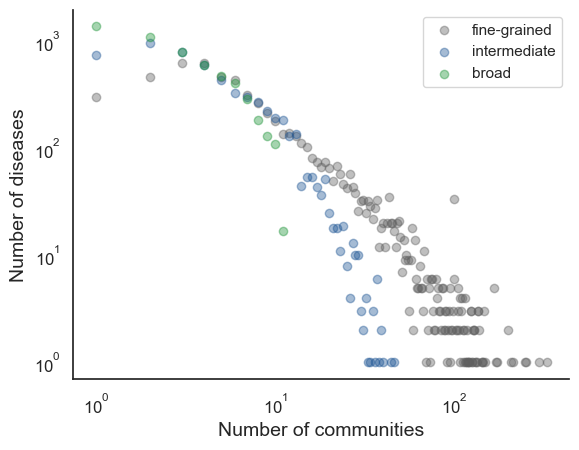

In [132]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

#Let's plot the Degree distribution of the EEN
fig1, ax1 = plt.subplots()

plt.scatter(numcomfinegrained,numdis_fine_grainedcount, c='#5F5F5F', alpha=0.4)
plt.scatter(numcommiddle,numdis_middlecount, c='#1e5594', alpha=0.4)
plt.scatter(numcombroad,numdis_broadcount, c='#1e9439', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of communities', fontsize=14)
plt.ylabel('Number of diseases', fontsize=14)


plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(["fine-grained" , "intermediate","broad"])

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/Fig4C.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()
plt.close()

In [5]:
#Let's import the WHO data at a national level
who_air_nation=pd.read_excel("input/WHO/F1_1_Total Releases at National Level into Air.xlsx",sheet_name=0)

In [6]:
#Let's define a dictionary that will convert the chemical id in chemical Name
chem_id_name_conversion = {}
for i,v in chem_homo.iterrows():
    chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

chem_id_name_conversion_inv={}
for k,v in chem_id_name_conversion.items():
    chem_id_name_conversion_inv[v]=k


In [7]:
import difflib

def get_overlap(s1, s2):
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2)) 
    return s1[pos_a:pos_a+size]

In [8]:
exp_set=set(who_air_nation['pollutant'])
chem_names=chem_id_name_conversion_inv.keys()
ctd_explist=[]
for exp in exp_set:
    try:
        ctd_explist.append(chem_id_name_conversion_inv[chem])
    except:
        for cc in chem_names:
            if exp.lower()==cc.lower():
                ctd_explist.append(chem_id_name_conversion_inv[cc])
            else:
                if exp=='Naphthalene':
                    ctd_explist.append(chem_id_name_conversion_inv['Naphthalenes'])
                elif exp=='Vinyl chloride':
                    ctd_explist.append(chem_id_name_conversion_inv['Polyvinyl Chloride'])
                elif exp=='Anthracene':
                    ctd_explist.append(chem_id_name_conversion_inv['Anthracenes'])

In [9]:
len(exp_set)

63

In [10]:
#Let's create a dictionary of conversion manually curated from CTD on the 12.02.2023
air_chem_name_conversion_dict = {}

air_chem_name_conversion_dict['1,1,1-trichloroethane (TCE-1,1,1)'] = 'C024566'
air_chem_name_conversion_dict['Hexachlorocyclohexane'] = 'D001556'
air_chem_name_conversion_dict['1,2-dichloroethane (DCE-1,2)'] = 'C024565'
air_chem_name_conversion_dict['Aldrin'] = 'D000452'
air_chem_name_conversion_dict['Ammonia (NH3)'] = 'D000641'
air_chem_name_conversion_dict['Anthracene'] = 'C034020'
air_chem_name_conversion_dict['Arsenic and compounds (as As)'] = 'D001151'
air_chem_name_conversion_dict['Asbestos'] = 'D001194'
air_chem_name_conversion_dict['Benzene'] = 'D001554'
air_chem_name_conversion_dict['Benzo(g,h,i)perylene'] = 'C006718'
air_chem_name_conversion_dict['Brominated diphenylethers (PBDE)'] = 'C477694'
air_chem_name_conversion_dict['Cadmium and compounds (as Cd)'] = 'D002104'
air_chem_name_conversion_dict['Carbon dioxide (CO2)'] = 'D002245'
air_chem_name_conversion_dict['Carbon monoxide (CO)'] = 'D002248'
air_chem_name_conversion_dict['Chlordecone'] = 'D007631'
air_chem_name_conversion_dict['Chlorine and inorganic compounds (as HCl)'] = 'D002713'
air_chem_name_conversion_dict['Chlorofluorocarbons (CFCs)'] = 'D017402'
air_chem_name_conversion_dict['Chromium and compounds (as Cr)'] = 'D002857'
air_chem_name_conversion_dict['Copper and compounds (as Cu)'] = 'D003300'
air_chem_name_conversion_dict['Di-(2-ethyl hexyl) phthalate (DEHP)'] = 'D004051'
air_chem_name_conversion_dict['Dichloromethane (DCM)'] = 'D008752'
air_chem_name_conversion_dict['Ethyl benzene'] = 'C004912'
air_chem_name_conversion_dict['Ethylene oxide'] = 'D005027'
air_chem_name_conversion_dict['Fine particulate matter (PM2.5)'] = 'D052638'
air_chem_name_conversion_dict['Fluorides (as total F)'] = 'D005459'
air_chem_name_conversion_dict['Fluorine and inorganic compounds (as HF)'] = 'D005461'
air_chem_name_conversion_dict['Hexachlorobenzene (HCB)'] = 'D006581'
air_chem_name_conversion_dict['Hydro-fluorocarbons (HFCS)'] = 'D005466'
air_chem_name_conversion_dict['Hydrogen cyanide (HCN)'] = 'D006856'
air_chem_name_conversion_dict['Lead and compounds (as Pb)'] = 'D007854'
air_chem_name_conversion_dict['Mercury and compounds (as Hg)'] = 'D008628'
air_chem_name_conversion_dict['Methane (CH4)'] = 'D008697'
air_chem_name_conversion_dict['Naphthalene'] = 'C031721'
air_chem_name_conversion_dict['Nickel and compounds (as Ni)'] = 'D009532'
air_chem_name_conversion_dict['Nitrogen oxides (NOX)'] = 'D009589'
air_chem_name_conversion_dict['Nitrous oxide (N2O)'] = 'D009609'
air_chem_name_conversion_dict['Non-methane volatile organic compounds (NMVOC)'] = 'D055549'
air_chem_name_conversion_dict['Nonylphenol and Nonylphenol ethoxylates'] = 'C025256'
air_chem_name_conversion_dict['Dioxins and Dioxin-like Compounds'] = 'D005663'
air_chem_name_conversion_dict['Furans'] = 'D000072316'
air_chem_name_conversion_dict['Dioxins' ]= 'D004147'
air_chem_name_conversion_dict['Particulate matter (PM10)'] = 'D052638'
air_chem_name_conversion_dict['Pentachlorobenzene'] = 'C003060'
air_chem_name_conversion_dict['Pentachlorophenol (PCP)'] = 'D010416'
air_chem_name_conversion_dict['Perfluorocarbons (PFCs)'] = 'D005466'
air_chem_name_conversion_dict['Phenols (as total C)'] = 'D010636'
air_chem_name_conversion_dict['Polychlorinated biphenyls (PCBs)' ]= 'D011078'
air_chem_name_conversion_dict['Polycyclic aromatic hydrocarbons (PAHs)'] = 'D011084'
air_chem_name_conversion_dict['Sulphur oxides (SOX)'] = 'D013458'
air_chem_name_conversion_dict['Tetrachloroethylene'] = 'D013750'
air_chem_name_conversion_dict['Toluene'] = 'D014050'
air_chem_name_conversion_dict['Trichloroethylene (TRI)'] = 'D014241'
air_chem_name_conversion_dict['Trichloromethane'] = 'D002725'
air_chem_name_conversion_dict['Vinyl chloride'] = 'D014752'
air_chem_name_conversion_dict['Xylenes'] = 'D014992'
air_chem_name_conversion_dict['Zinc and compounds (as Zn)'] = 'D015032'

In [13]:
#We will check that the identified IDs from CTD correspond to the expected chemical name:
for k,v in air_chem_name_conversion_dict.items():
    try:
        print(k,chem_id_name_conversion[v])
    except:
        pass

1,1,1-trichloroethane (TCE-1,1,1) 1,1,1-trichloroethane
Hexachlorocyclohexane Hexachlorocyclohexane
1,2-dichloroethane (DCE-1,2) ethylene dichloride
Aldrin Aldrin
Ammonia (NH3) Ammonia
Anthracene anthracene
Arsenic and compounds (as As) Arsenic
Asbestos Asbestos
Benzene Benzene
Benzo(g,h,i)perylene 1,12-benzoperylene
Brominated diphenylethers (PBDE) 2,2',4,4',5-brominated diphenyl ether
Cadmium and compounds (as Cd) Cadmium
Carbon dioxide (CO2) Carbon Dioxide
Carbon monoxide (CO) Carbon Monoxide
Chlordecone Chlordecone
Chlorine and inorganic compounds (as HCl) Chlorine
Chromium and compounds (as Cr) Chromium
Copper and compounds (as Cu) Copper
Di-(2-ethyl hexyl) phthalate (DEHP) Diethylhexyl Phthalate
Dichloromethane (DCM) Methylene Chloride
Ethyl benzene ethylbenzene
Ethylene oxide Ethylene Oxide
Fine particulate matter (PM2.5) Particulate Matter
Fluorides (as total F) Fluorides
Hexachlorobenzene (HCB) Hexachlorobenzene
Hydro-fluorocarbons (HFCS) Fluorocarbons
Lead and compounds (as P

In [10]:
len(set(ctd_explist))

15

In [11]:

country_set=set(who_air_nation['countryName'].tolist())
years=list(range(2007,2020))
country_chem_conc={}
for c in country_set:
    chem_concentration_dict={}
    for i,v in who_air_nation[who_air_nation['countryName']==c].iterrows():
        concentration=[]
        for y in years:
            concentration.append(v[y])
        concentration_clenaed=[x for x in concentration if str(x) != 'nan']
        chem_concentration_dict[v['pollutant']]=concentration_clenaed
    country_chem_conc[c]=chem_concentration_dict
 

In [12]:
def mean_list(list1):
    if len(list1)>0:
        sum_list=sum(list1)
        len_list=len(list1)
        mean=sum_list/len_list
    else:
        mean=0
    return mean

In [13]:
country_chem_conc_mean_dict={}
for c,chem_con in country_chem_conc.items():
    chem_mean_dict={}
    for chem,con_list in chem_con.items():
        chem_mean_dict[chem]=mean_list(con_list)
    country_chem_conc_mean_dict[c]=chem_mean_dict

In [14]:
chem_set=set(who_air_nation['pollutant'].tolist())

chem_across_countries_dict={}
for chem in chem_set:
    chem_median_across_countries_list=[]
    for c in country_set:
        try:
            chem_median_across_countries_list.append(country_chem_conc_mean_dict[c][chem])
        except:
            pass
    chem_across_countries_dict[chem]=chem_median_across_countries_list
    


In [15]:
#If a chemical compound is express only in 25% of the total countries (meaning that if a chemical compound is released
#only in 4 countries or less) then is considered as specific for that country. Otherwise the concentration in that 
#country should be > 75* percentile of the average concentration distribution across all countries
import statistics
country_selected_chem_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,75)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    country_selected_chem_dict[country]=chem_list
                
        

In [16]:
np.mean([len(v) for v in country_selected_chem_dict.values()])

8.3125

In [17]:
n_country_selected_chem_id_dict={}
chem_id_list = list(chem_id_name_conversion.keys())
for country,chem_list in country_selected_chem_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if air_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(air_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass

    n_country_selected_chem_id_dict[country]=set(id_chem_list)

In [18]:
np.mean([len(v) for v in n_country_selected_chem_id_dict.values()])

6.875

In [19]:
len([i for i in n_country_selected_chem_id_dict.keys() if len(n_country_selected_chem_id_dict[i])>0])

24

In [20]:
country_selected_dis_dict={}
for country, chem_list in n_country_selected_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    country_selected_dis_dict[country]=set(dis_list)
        


In [21]:

len([i for i in country_selected_dis_dict.keys() if len(country_selected_dis_dict[i])>0])

24

In [ ]:
from collections import Counter
dislist_repetion=[]
for k,v in country_selected_dis_dict.items():
    for dis in v:
        dislist_repetion.append(dis)
        

Counter(dislist_repetion).most_common()


In [27]:

air_proximal_disease_list = [] 

for country, disset in country_selected_dis_dict.items():
    for dis in disset:
        if dis not in air_proximal_disease_list:
            air_proximal_disease_list.append(dis)

print(len(air_proximal_disease_list))

147


In [22]:
#Here, we will import the epidemiological data for all countries and diseases
#The download of the data was performed from https://vizhub.healthdata.org/gbd-results/
#on 24.05.2022, using as parameters of research: all causes, locations, deaths, DALYs, Prevalence, Incidence, Rate
#This generated 11 files, that should be merged together

GBD_df_partial_list=[]
for i in range(11):
    GBD_df_partial=pd.read_csv("input/Disease/GBD/IHME-GBD_2019_DATA-e09bfeaa-%s.csv"%(i+1))
    GBD_df_partial_list.append(GBD_df_partial)
GBD_df=pd.concat(GBD_df_partial_list, sort=False)


In [23]:
len(GBD_df)

5389960

In [24]:
disease_set=set(GBD_df['cause'])

In [25]:
len(disease_set)

364

In [28]:
#Let's create a dictionary conversion of the diseases that came from disgenet to the ones that are in GBD


air_disgenet_gbd_dict = {}
for dis in air_proximal_disease_list:
    dis_disgenet_lower = dis.lower()
    for dis_gbd in disease_set:
        dis_gbd_lower = dis_gbd.lower()
        if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.8*len(dis_disgenet_lower):
            air_disgenet_gbd_dict[dis] = dis_gbd

print(len(air_disgenet_gbd_dict))

        

22


In [ ]:
#The rest will be done manually

for dis in air_proximal_disease_list:
    if dis not in air_disgenet_gbd_dict.keys():
        dis_disgenet_lower = dis.lower()
        possible_dislist = []
        for dis_gbd in disease_set:
            dis_gbd_lower = dis_gbd.lower()
            if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.4*len(dis_disgenet_lower):
                possible_dislist.append(dis_gbd)
        print(dis,">", possible_dislist)
    



In [29]:
air_disgenet_gbd_dict['Renal Cell Carcinoma'] = 'Kidney cancer'
air_disgenet_gbd_dict['Colorectal Carcinoma'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Ovarian Carcinoma'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Liver Cirrhosis, Experimental'] = 'Cirrhosis and other chronic liver diseases'
air_disgenet_gbd_dict['melanoma'] = 'Malignant skin melanoma'
air_disgenet_gbd_dict['MYELODYSPLASTIC SYNDROME'] = 'Myelodysplastic, myeloproliferative, and other hematopoietic neoplasms'
air_disgenet_gbd_dict['Cutaneous Melanoma'] = 'Malignant skin melanoma'
air_disgenet_gbd_dict['Liver Neoplasms, Experimental'] = 'Liver cancer'
air_disgenet_gbd_dict['Leukemia, Myelocytic, Acute'] = 'Acute myeloid leukemia'
air_disgenet_gbd_dict['Chronic Lymphocytic Leukemia'] = 'Chronic lymphoid leukemia'
air_disgenet_gbd_dict["Alzheimer's Disease"] = "Alzheimer's disease and other dementias"
air_disgenet_gbd_dict['Squamous cell carcinoma of esophagus'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Carcinoma of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Non-Small Cell Lung Carcinoma'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Brain Neoplasms'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Malignant neoplasm of pancreas'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Malignant neoplasm of liver'] = 'Liver cancer'
air_disgenet_gbd_dict['Depressive disorder'] = "Depressive disorders"
air_disgenet_gbd_dict['Malignant neoplasm of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Hypertensive disease'] = 'Hypertensive heart disease'
air_disgenet_gbd_dict['Myocardial Infarction'] = "Ischemic heart disease"
air_disgenet_gbd_dict['Malignant neoplasm of ovary'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Seizures'] = "Idiopathic epilepsy"
air_disgenet_gbd_dict['Adenocarcinoma of lung (disorder)'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Cardiomyopathy, Dilated'] = 'Cardiomyopathy and myocarditis'
air_disgenet_gbd_dict['Prostatic Neoplasms'] = "Prostate cancer"
air_disgenet_gbd_dict['Mammary Neoplasms'] = 'Breast cancer'
air_disgenet_gbd_dict['Cerebrovascular accident'] = "Ischemic stroke"
air_disgenet_gbd_dict['Glioma'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Diabetes Mellitus, Experimental'] = 'Diabetes mellitus'
air_disgenet_gbd_dict['Liver neoplasms'] = 'Liver cancer'
air_disgenet_gbd_dict['Colonic Neoplasms'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Malignant neoplasm of urinary bladder'] = "Bladder cancer"
air_disgenet_gbd_dict['Malignant neoplasm of stomach'] = "Stomach cancer"
air_disgenet_gbd_dict['ovarian neoplasm'] = 'Ovarian cancer'
air_disgenet_gbd_dict['Major Depressive Disorder'] = "Major depressive disorder"
air_disgenet_gbd_dict['Malignant neoplasm of prostate'] = "Prostate cancer"
air_disgenet_gbd_dict['Schizophrenia'] = "Schizophrenia"
air_disgenet_gbd_dict['Endometrial Carcinoma'] = "Uterine cancer"
air_disgenet_gbd_dict['Esophageal Neoplasms'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Mammary Neoplasms, Experimental'] = 'Breast cancer'
air_disgenet_gbd_dict['Stomach Neoplasms'] = "Stomach cancer"
air_disgenet_gbd_dict['Diabetes Mellitus, Non-Insulin-Dependent'] = "Diabetes mellitus type 2"
air_disgenet_gbd_dict['Colorectal Neoplasms'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Asthma'] = 'Asthma'
air_disgenet_gbd_dict['Liver carcinoma'] = 'Liver cancer'
air_disgenet_gbd_dict['Rheumatoid Arthritis'] = "Rheumatoid arthritis"
air_disgenet_gbd_dict['Breast Carcinoma'] = 'Breast cancer'
air_disgenet_gbd_dict['Malignant neoplasm of breast'] = 'Breast cancer'
air_disgenet_gbd_dict['Pancreatic Neoplasm'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Malignant tumor of colon'] = 'Colon and rectum cancer'
air_disgenet_gbd_dict['Lung Neoplasms'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Brain Ischemia'] = 'Ischemic stroke'
air_disgenet_gbd_dict['Carcinoma, Basal Cell'] = 'Non-melanoma skin cancer (basal-cell carcinoma)'
air_disgenet_gbd_dict['Lymphoma, Non-Hodgkin'] = "Non-Hodgkin lymphoma"
air_disgenet_gbd_dict['Diabetic Nephropathy'] = 'Diabetes and kidney diseases'
air_disgenet_gbd_dict['Coronary heart disease'] = 'Ischemic heart disease'
air_disgenet_gbd_dict['Kidney Failure, Chronic'] = 'Chronic kidney disease'
air_disgenet_gbd_dict['Parkinson Disease'] = "Parkinson's disease"
air_disgenet_gbd_dict['Autistic Disorder'] = "Autism spectrum disorders"
air_disgenet_gbd_dict['Pancreatic carcinoma'] = "Pancreatic cancer"
air_disgenet_gbd_dict['Breast adenocarcinoma'] = 'Breast cancer'
air_disgenet_gbd_dict['Thyroid carcinoma'] = 'Thyroid cancer'
air_disgenet_gbd_dict['Unipolar Depression'] = "Major depressive disorder"
air_disgenet_gbd_dict['Polycystic Ovary Syndrome'] = "Polycystic ovarian syndrome"
air_disgenet_gbd_dict['Squamous cell carcinoma of lung'] = "Tracheal, bronchus, and lung cancer"
air_disgenet_gbd_dict['Glioblastoma Multiforme'] = "Brain and central nervous system cancer"
air_disgenet_gbd_dict['Esophageal carcinoma'] = 'Esophageal cancer'
air_disgenet_gbd_dict['Parkinsonian Disorders'] = "Parkinson's disease"
air_disgenet_gbd_dict['Mental Depression'] = "Major depressive disorder"
air_disgenet_gbd_dict['Coronary Artery Disease'] = 'Ischemic heart disease'
air_disgenet_gbd_dict['Cleft Palate'] = "Orofacial clefts"
air_disgenet_gbd_dict['Chronic Obstructive Airway Disease'] = 'Chronic obstructive pulmonary disease'
air_disgenet_gbd_dict['Uterine Cervical Neoplasm'] = "Uterine cancer"
air_disgenet_gbd_dict['Pulmonary Fibrosis'] = "Interstitial lung disease and pulmonary sarcoidosis"


In [30]:
len(air_disgenet_gbd_dict)

89

In [31]:
len(set(air_disgenet_gbd_dict.values()))

53

In [32]:
country_selected_dis_mean_prox_dict = {}
for country,disset in country_selected_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(n_country_selected_chem_id_dict[country])>0:
            for chem in n_country_selected_chem_id_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_selected_dis_mean_prox_dict[country] = dis_dict

        

In [33]:
#Here, we have to clean the diseases that appears in each countries, considering only the ones that are reported in
#GBD and using a little of manual curation for merging some terms (for example breast cancer and carcinoma of breast)
#Now, we can create a country proximal diseases dictionary with the diseases taken from GBD


n_country_selected_chem_id_gbd_dict = {}

for country,dis_dict in country_selected_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([air_disgenet_gbd_dict[dis],z])
            except:
                pass
        n_country_selected_chem_id_gbd_dict[country] = dis_z_list
            



In [34]:
from collections import Counter

n_country_selected_chem_id_gbd_mean_dict = {}
for country,dislist in n_country_selected_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
        
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    n_country_selected_chem_id_gbd_mean_dict[country]=dis_dict

            
            
            
        

In [35]:
with open('output/exp_random/faraway_exp_dis_dict.pickle', 'rb') as handle:
    faraway_exp_dis_dict = pk.load(handle)

In [36]:
country_selected_faraway_dis_dict={}
for country,chemset in n_country_selected_chem_id_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        country_selected_faraway_dis_dict[country] = set(far_away_dis_set)
            

In [37]:
faraway_air_disset = []

for country,disset in country_selected_faraway_dis_dict.items():
    for dis in disset:
        if dis not in faraway_air_disset:
            faraway_air_disset.append(dis)

print(len(faraway_air_disset))

210


In [38]:

long_faraway_air_disset_gbd_dict = {}
for dis in faraway_air_disset:
    dis_disgenet_lower = dis.lower()
    for dis_gbd in disease_set:
        dis_gbd_lower = dis_gbd.lower()
        if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_disgenet_lower):
            long_faraway_air_disset_gbd_dict[dis] = dis_gbd

print(len(long_faraway_air_disset_gbd_dict))

4


In [39]:
from fuzzywuzzy import fuzz

# Preprocess the strings to improve matching accuracy
def preprocess_string(s):
    stopwords = {'in', 'of', 'and', 'on', 'for', 'with'}
    return ' '.join(word for word in s.lower().split() if word not in stopwords)

# Improved overlap function using fuzz for more flexible matching
def get_similarity_score(s1, s2):
    return fuzz.token_sort_ratio(s1, s2)  # Token sort ratio is useful for out-of-order terms

n_long_faraway_air_disset_gbd_dict = {}
for dis1 in faraway_air_disset:
    dis1_processed = preprocess_string(dis1)
    # Initialize best match tracking
    best_match = (None, 0)  # (Best match disease name, similarity score)
    for dis2 in disease_set:
        dis2_processed = preprocess_string(dis2)
        similarity = get_similarity_score(dis1_processed, dis2_processed)
        # Update if this is the best match so far
        if similarity > best_match[1]:
            best_match = (dis2, similarity)
    
    # You may want to set a threshold for "good enough" matching
    if best_match[1] > 50:  # This threshold
        n_long_faraway_air_disset_gbd_dict[dis1] = best_match[0]

print(len(n_long_faraway_air_disset_gbd_dict))

/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


110


In [40]:
#Let's remove those diseases that had the wrong march


keys_to_delete=['Weill-Marchesani-Like Syndrome','HYPOGONADOTROPIC HYPOGONADISM 11 WITH OR WITHOUT ANOSMIA','Night blindness, congenital stationary',
             'Narcolepsy 1', 'DEAFNESS, X-LINKED 4 (disorder)','Juvenile nephropathic cystinosis (disorder)', 'Congenital Pain Insensitivity',
                'Nephropathic cystinosis','Congenital long QT syndrome','Glomerulocystic Kidney Disease with Hyperuricemia and Isosthenuria',
                'Keutel syndrome','FICOLIN 3 DEFICIENCY','Autosomal Dominant Nocturnal Frontal Lobe Epilepsy','Cavitary Optic Disc Anomalies',
                'alpha, alpha-Trehalase deficiency','Nephritis, Tubulointerstitial','Cerebral ventriculomegaly','HYPOGONADOTROPIC HYPOGONADISM 4 WITH OR WITHOUT ANOSMIA',
                'Goiter','Medullary Cystic Kidney Disease Type 2','Malabsorption Syndrome','CATARACT 39, MULTIPLE TYPES',
                'Long Qt Syndrome 10','RETINITIS PIGMENTOSA 49','Olmsted syndrome','Cystinosis','HIRSCHSPRUNG DISEASE, SUSCEPTIBILITY TO, 4',
                'MASP2 Deficiency','Cone monochromatism','Enterokinase Deficiency','Retinitis Pigmentosa 7','Narcolepsy','Jarcho-Levin syndrome',
                'Waardenburg Syndrome, Type 4b','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E','Factor XIII, B Subunit, Deficiency Of',
                'Renal hypouricemia','MYASTHENIC SYNDROME, CONGENITAL, 1A, SLOW-CHANNEL','BLEEDING DISORDER, PLATELET-TYPE, 20',
                'SMALL PATELLA SYNDROME','Amish Infantile Epilepsy Syndrome','Scoliosis, unspecified','Focal glomerulosclerosis',
                'Meningococcal Infections','Indifference to Pain, Congenital, Autosomal Recessive','Neuropathy, Distal Hereditary Motor, Type VIIA',
                'Obstruction of pelviureteric junction','TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5','Marshall syndrome','STICKLER SYNDROME, TYPE II (disorder)',
                'Histiocytosis','Hypopigmentation disorder','PAROXYSMAL EXTREME PAIN DISORDER','NEMALINE MYOPATHY 10','DEAFNESS, AUTOSOMAL RECESSIVE 42 (disorder)',
                'Nivelon Nivelon Mabille syndrome','HERMANSKY-PUDLAK SYNDROME 4','Juvenile hemochromatosis','HEMOCHROMATOSIS, TYPE 2A','USHER SYNDROME, TYPE IJ',
                'CATARACT 47','Usher Syndrome, Type IF','Hypouricemia, Renal, 2','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1G','Primary Erythermalgia',
                'Trimethylaminuria','Hypertrichosis','Congenital disorder of glycosylation, type 2C','Night Blindness, Congenital Stationary, Autosomal Dominant 3',
                'Lysinuric Protein Intolerance','RETINITIS PIGMENTOSA, JUVENILE, LRAT-RELATED','Trichotillomania','Hydrocephalus','Usher Syndrome, Type I',
                'STARGARDT DISEASE 1 (disorder)','Perisylvian syndrome','Liver Failure','CATARACT 4, MULTIPLE TYPES','DEAFNESS, AUTOSOMAL RECESSIVE 1A (disorder)',
                'CILIARY DYSKINESIA, PRIMARY, 7 (disorder)','Vesico-Ureteral Reflux','VAN DER WOUDE SYNDROME 1','Hyperaldosteronism','Popliteal pterygium syndrome',
                'Riboflavin Deficiency','Zunich neuroectodermal syndrome','Hypercalcemia, Infantile','CONE-ROD DYSTROPHY 3 (disorder)','RETINITIS PIGMENTOSA 19','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Ip',
                'Juvenile macular degeneration',"Stargardt's disease",'RETINITIS PIGMENTOSA 48'
                

]

n_long_faraway_air_disset_gbd_dict_cleaned = {}
for disgenet_dis, gbd_dis in n_long_faraway_air_disset_gbd_dict.items():
    if disgenet_dis not in keys_to_delete:
        n_long_faraway_air_disset_gbd_dict_cleaned[disgenet_dis] = gbd_dis

n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 39, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_air_disset_gbd_dict_cleaned['NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E'] = 'Blindness and vision loss'
n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 4, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_air_disset_gbd_dict_cleaned['CATARACT 47'] = 'Cataract'

faraway_dis_list = list(n_long_faraway_air_disset_gbd_dict_cleaned.values())
faraway_dis_list.extend(['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies',
                        'Turner syndrome','Klinefelter syndrome'])

print(len(faraway_dis_list))

26


In [ ]:

#The rest will be done manually

for dis in faraway_air_disset:
    if dis not in faraway_air_disset_gbd_dict.keys():
        dis_disgenet_lower = dis.lower()
        possible_dislist = []
        for dis_gbd in disease_set:
            dis_gbd_lower = dis_gbd.lower()
            if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.4*len(dis_disgenet_lower) or len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.8*len(dis_gbd_lower):
                possible_dislist.append(dis_gbd)
        if len(possible_dislist)>0:
            print(dis,">", possible_dislist)
    

In [42]:
faraway_manually_added_diseases = ['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies']

country_faraway_dis_dict = {}
for country,dis_dict in n_country_selected_chem_id_gbd_mean_dict.items():
    chem_set = n_country_selected_chem_id_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_air_disset_gbd_dict_cleaned.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

        elif dis=='Turner syndrome':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Turner' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
    country_faraway_dis_dict[country] = country_specific_faraway_dis_dict

    

/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [43]:
exp_dispair_noprox_list = list(exp_proximity_not_significant.keys())

In [44]:
noprox_air_disset = set([el[1] for el in exp_dispair_noprox_list])
print(len(noprox_air_disset))

6177


In [45]:
no_prox_air_disset_gbd_dict = {}
for dis1 in noprox_air_disset:
    if 'syndrome' not in dis1:
        if 'Syndrome' not in dis1 :
            dis1_processed = preprocess_string(dis1)
            # Initialize best match tracking
            best_match = (None, 0)  # (Best match disease name, similarity score)
            for dis2 in disease_set:
                dis2_processed = preprocess_string(dis2)
                similarity = get_similarity_score(dis1_processed, dis2_processed)
                # Update if this is the best match so far
                if similarity > best_match[1]:
                    best_match = (dis2, similarity)
            
            # You may want to set a threshold for "good enough" matching
            if best_match[1] > 70:  # This threshold
                no_prox_air_disset_gbd_dict[dis1] = best_match[0]

print(len(no_prox_air_disset_gbd_dict))

306


In [46]:


#Let's clean the dictionary removing those terms that are wrong by the systematic analysis
elements_to_delete = ['CHOPS SYNDROME','ADULT SYNDROME','Leber Congenital Amaurosis','COWDEN SYNDROME 6','Canavan Disease',
                      'Cystic Kidney Diseases','Cystic Fibrosis','IRAK4 Deficiency','NOONAN SYNDROME 10','Glucagonoma',
                      'MAST SYNDROME','Cholelithiasis','ovarian neoplasm','MYD88 Deficiency','Urocanase deficiency',
                      'LONG QT SYNDROME 5','Malignant mesothelioma','Neurodevelopmental Disorders','Prion Diseases',
                      'Mood Disorders','L-FERRITIN DEFICIENCY','Malignant neoplasm of liver','T-Cell Prolymphocytic Leukemia',
                      'VERHEIJ SYNDROME','Tyrosine Kinase 2 Deficiency','Malignant neoplasm of testis','Steatohepatitis',
                      'MEESTER-LOEYS SYNDROME','Heart Diseases','Cystinosis','Cardiomyopathy, Dilated, 1g','5-oxoprolinase deficiency',
                      'Disorder of eye','Heart valve disease','HYDROCEPHALUS, CONGENITAL, 3, WITH BRAIN ANOMALIES','Transcobalamin II deficiency',
                      'NOONAN SYNDROME 9','Hodgkin Disease','Malignant neoplasm of kidney','Acute Promyelocytic Leukemia','NGLY1 deficiency',
                      'Movement Disorders','MASP2 Deficiency','Eye Diseases, Hereditary','FICOLIN 3 DEFICIENCY','MEND SYNDROME',
                      'Scrapie','Endometrial Neoplasms','Diverticular Diseases','Manic Disorder','Malignant neoplasm of pancreas',
                      'Enterokinase Deficiency','Malignant neoplasm of brain','COWDEN SYNDROME 7','Pneumonitis','Deficiency of galactokinase',
                      'Arthritis, Psoriatic','Memory Disorders','Properdin deficiency disease','TORG-WINCHESTER SYNDROME','Thyroid Neoplasm',
                      'NOONAN SYNDROME 7','COWCHOCK SYNDROME','Ataxia with vitamin E deficiency','INFLAMMATORY SKIN AND BOWEL DISEASE, NEONATAL, 1',
                      'Skin Neoplasms','Glioma','Uterine Neoplasms','ZAP70 deficiency','AU-KLINE SYNDROME','Uremia','Kidney Calculi',
                      'Lung Diseases, Interstitial','KLEEFSTRA SYNDROME 1','Protein C Deficiency','Gastritis, Atrophic','Peritoneal Fibrosis',
                      'Stomach Neoplasms','Chronic Neutrophilic Leukemia','Nodal rhythm disorder','Malignant neoplasm of breast',
                      'RAINE SYNDROME','Malignant neoplasm of ovary','Mitochondrial Diseases','COCOON SYNDROME','Thymus Neoplasms',
                      'Malignant neoplasm of mouth','SWEENEY-COX SYNDROME','Celiac Disease','TYLOSIS WITH ESOPHAGEAL CANCER',
                      'MUNGAN SYNDROME','Deficiency of prolidase','Galactosemias','Malignant neoplasm of prostate','prostatitis',
                      'NOONAN SYNDROME 8','Dystonia','Glutamine deficiency, congenital','Liver neoplasms','C9 Deficiency','Retinal Diseases',
                      'LONG QT SYNDROME 3','Mouth Neoplasms','Deficiency of fructokinase','Brain Neoplasms','BAKER-GORDON SYNDROME',
                      'NOONAN SYNDROME 3','MYOPIA 6 (disorder)','Malignant neoplasm of lung','MACULAR DEGENERATION, EARLY-ONSET',
                      'HIV Infections','Neonatal diabetes mellitus','Colitis','Dihydropyrimidinase deficiency','TENORIO SYNDROME',
                      'Herpes encephalitis','Malignant melanoma of iris','GATA2 Deficiency','Intestinal Pseudo-Obstruction',
                      "Dent's disease",'HEART DEFECTS, CONGENITAL, AND OTHER CONGENITAL ANOMALIES','Malignant neoplasm of stomach',
                      'Osteitis Deformans','Fibrinogen Deficiency','Lung diseases','Metabolic Bone Disorder','Sialidase deficiency',
                      'Lung Neoplasms','Iron Metabolism Disorders','Graves Disease','Malignant Neoplasms','Riboflavin Deficiency','Migraine Disorders',
                      'Crohn Disease'
]

no_prox_air_disset_gbd_dict_cleaned = {}

for disgenet_name,gbd_name in no_prox_air_disset_gbd_dict.items():
    if disgenet_name not in elements_to_delete:
        no_prox_air_disset_gbd_dict_cleaned[disgenet_name] = gbd_name

noprox_gbd_list = set(list(no_prox_air_disset_gbd_dict_cleaned.values()))

no_prox_air_disset_gbd_dict_cleaned_inv = {}
for gbd_dis in noprox_gbd_list:
    disgenet_name_list = [] 
    for disg_id,gbd_ in no_prox_air_disset_gbd_dict_cleaned.items():
        if gbd_dis==gbd_:
            disgenet_name_list.append(disg_id)
    no_prox_air_disset_gbd_dict_cleaned_inv[gbd_dis] = disgenet_name_list

print(len(no_prox_air_disset_gbd_dict_cleaned_inv))
            



85


In [47]:

country_noprox_dis_dict = {}
for country,dis_dict in n_country_selected_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = n_country_selected_chem_id_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(country_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        country_noprox_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        country_noprox_dis_dict[country] = country_specific_noprox_dis_dict_sort
 

In [46]:
for k,v in country_noprox_dis_dict.items():
    print(k,len(v))

Norway 27
Estonia 28
Italy 25
Malta 17
Greece 26
Netherlands 35
Bulgaria 32
Czechia 33
Ireland 31
United Kingdom 27
Finland 32
Romania 30
Serbia 15
Iceland 15
Croatia 17
Spain 28
Germany 27
Poland 26
Belgium 30
Sweden 22
Hungary 34
Portugal 25
Slovakia 15
France 30


In [ ]:
#For each country, now we want to calculate the avg incidence,prevalence,death rate and DALYs of each disease

country_set=set(GBD_df['location'])
disease_set=set(GBD_df['cause'])
country_dis_incidence={}
country_dis_prevalence={}
country_dis_DALYs={}
country_dis_mortality={}
for c in country_set:
    dis_incidence_dict={}
    dis_prevalence_dict={}
    dis_DALYs_dict={}
    dis_mortality_dict={}
    for dis in disease_set:
        dis_incidence_dict[dis]=mean_list(list(GBD_df.loc[(GBD_df['location']==c) & (GBD_df['cause']==dis)& (GBD_df['measure']=='Incidence'),'val']))
        dis_prevalence_dict[dis]=mean_list(list(GBD_df.loc[(GBD_df['location']==c) & (GBD_df['cause']==dis)& (GBD_df['measure']=='Prevalence'),'val']))
        dis_DALYs_dict[dis]=mean_list(list(GBD_df.loc[(GBD_df['location']==c) & (GBD_df['cause']==dis)& (GBD_df['measure']=='DALYs (Disability-Adjusted Life Years)'),'val']))
        dis_mortality_dict[dis]=mean_list(list(GBD_df.loc[(GBD_df['location']==c) & (GBD_df['cause']==dis)& (GBD_df['measure']=='Deaths'),'val']))   
    country_dis_incidence[c]=dis_incidence_dict
    country_dis_prevalence[c]=dis_prevalence_dict
    country_dis_DALYs[c]=dis_DALYs_dict
    country_dis_mortality[c]=dis_mortality_dict
    
with open('output/GBD/country_dis_incidence.pickle', 'wb') as handle:
    pk.dump(country_dis_incidence, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/GBD/country_dis_prevalence.pickle', 'wb') as handle:
    pk.dump(country_dis_prevalence, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/GBD/country_dis_DALYs.pickle', 'wb') as handle:
    pk.dump(country_dis_DALYs, handle, protocol=pk.HIGHEST_PROTOCOL)
with open('output/GBD/country_dis_mortality.pickle', 'wb') as handle:
    pk.dump(country_dis_mortality, handle, protocol=pk.HIGHEST_PROTOCOL)
    

In [48]:
with open('output/GBD/country_dis_incidence.pickle', 'rb') as handle:
    country_dis_incidence = pk.load(handle)
    
with open('output/GBD/country_dis_prevalence.pickle', 'rb') as handle:
    country_dis_prevalence = pk.load(handle)
    
with open('output/GBD/country_dis_DALYs.pickle', 'rb') as handle:
    country_dis_DALYs = pk.load(handle)
    
with open('output/GBD/country_dis_mortality.pickle', 'rb') as handle:
    country_dis_mortality = pk.load(handle)

In [ ]:
#Let's try again, but by grouping only on "proximal" and "distant" diseases

In [49]:
#Let's just merge the no-proximal dictionary and the faraway dictionary
new_country_distant_dis_dict = {}
for country,dis_dict in n_country_selected_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(country_faraway_dis_dict[country])
    noprox_list = list(country_noprox_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = country_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = country_noprox_dis_dict[country][dis]
        new_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**country_faraway_dis_dict[country], **country_noprox_dis_dict[country]}
        new_country_distant_dis_dict[country] = distant_dict
 

In [50]:
proximal_dis_list=[] 
for country, disdict in n_country_selected_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list
        

In [ ]:
import seaborn as sns
country_proximal_zscore_dict={}
for country,dis_dict in n_country_selected_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)


        sns.set_style('white')
        sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
        plt.figure(figsize=(10,10))
        plt.vlines(country_dis_incidence[country][dis],ymin=0,ymax=0.014,color='r',label='%s'%country)
        sns.kdeplot(proximal_dis_incidence[dis],color='k',lw=.5,alpha=.5,shade=True,label='World')
        plt.legend(loc='upper left',fontsize=12)
        plt.ylabel('Density',fontsize=12)
        plt.xlabel('Incidence',fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("%s incidence" %dis,fontsize=20)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    country_proximal_zscore_dict[country]=country_proximal_zscore_list

In [52]:
distant_dis_list=[] 
for country, disdict in new_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list
        

In [ ]:
air_country_distant_zscore_dict={}

for country,dis_dict in new_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)


        sns.set_style('white')
        sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
        plt.figure(figsize=(10,10))
        plt.vlines(country_dis_incidence[country][dis],ymin=0,ymax=0.014,color='r',label='%s'%country)
        sns.kdeplot(distant_dis_incidence[dis],color='k',lw=.5,alpha=.5,shade=True,label='World')
        plt.legend(loc='upper left',fontsize=12)
        plt.ylabel('Density',fontsize=12)
        plt.xlabel('Incidence',fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("%s incidence" %dis,fontsize=20)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    air_country_distant_zscore_dict[country]=country_distant_zscore_list
    

In [54]:
air_pollution_zscore_df = pd.DataFrame()

selected_countries=set(air_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

air_pollution_zscore_df['location']=tot_country_list
air_pollution_zscore_df['z-score']=tot_zscore_list
air_pollution_zscore_df['network_location']=location_network_list

In [55]:
my_order = sorted(list(set(air_pollution_zscore_df['location'])))

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_98843/3039153866.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 36)


[Text(-4.0, 0, '-4.0'),
 Text(-2.0, 0, '-2.0'),
 Text(0.0, 0, '0.0'),
 Text(2.0, 0, '2.0'),
 Text(4.0, 0, '4.0'),
 Text(6.0, 0, '6.0'),
 Text(8.0, 0, '8.0'),
 Text(10.0, 0, '10.0')]

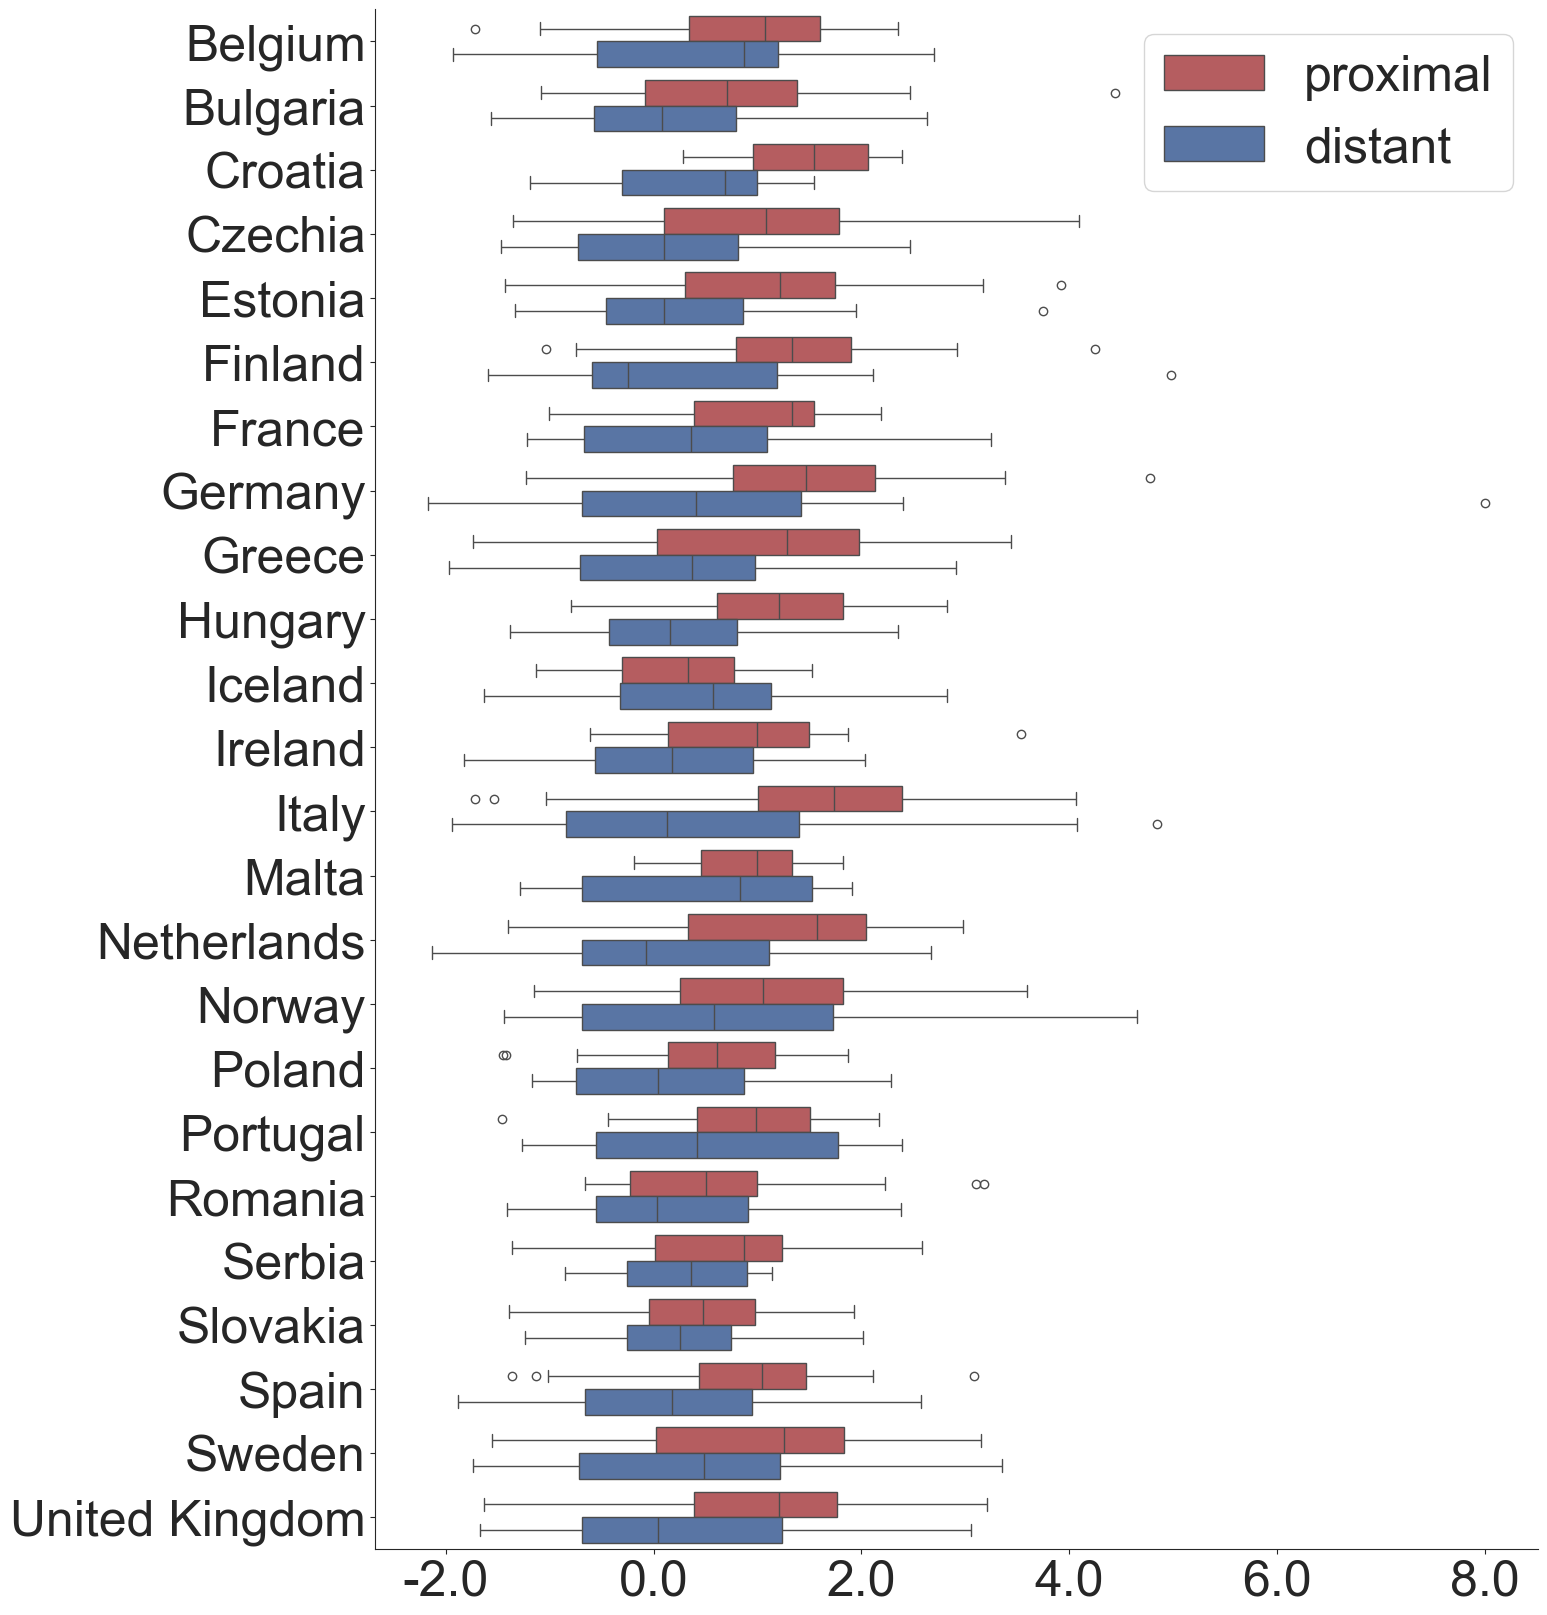

In [56]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
# Draw a nested boxplot to show bills by day and time
g=sns.boxplot(x="z-score", y="location",orient="h",
            hue="network_location", palette=["r","b"],order=my_order,
            data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)
#g.set_xscale("log")
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
#plt.title('Incidence of network proximal and distant diseases to air polluted from 2000 to 2019', fontsize=25)
plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(ax.get_xticks(), size = 36)


In [60]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in selected_countries:
    try:
        proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

Norway 1.0650982730061018 0.6447355079534336 0.1054
Estonia 1.1565383743106925 0.24855871463383983 0.0008
Italy 1.5362635455917661 0.41286219453482764 0.001
Malta 0.8784134881053346 0.36899361225755545 0.11
Greece 1.0893145617714561 0.2851515563334778 0.0159
Netherlands 1.185196961003559 0.1648540515560307 0.0006
Bulgaria 0.7920619868847691 0.1409451640235703 0.015
Czechia 1.0312062965417026 0.16761337057626127 0.0009
Ireland 0.8337250028277703 0.11236964183370973 0.009
United Kingdom 1.0868856844279569 0.28055031165318617 0.002
Finland 1.345954805607468 0.0026766651930826965 0.0
Romania 0.548351670138693 0.1925178189312843 0.1189
Serbia 0.648448289889945 0.2610563942678983 0.1256
Iceland 0.2573314472968374 0.5183401363554841 0.7563
Croatia 1.4728264390485357 0.38846318071147834 0.0015
Spain 0.9542946451423872 0.13389499888775966 0.0012
Germany 1.4062499991364446 0.5955959596714168 0.0039
Poland 0.5488299727516815 0.19156609630339874 0.0469
Belgium 0.8986735188348007 0.3724184218282333

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_98843/1273042733.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=36)


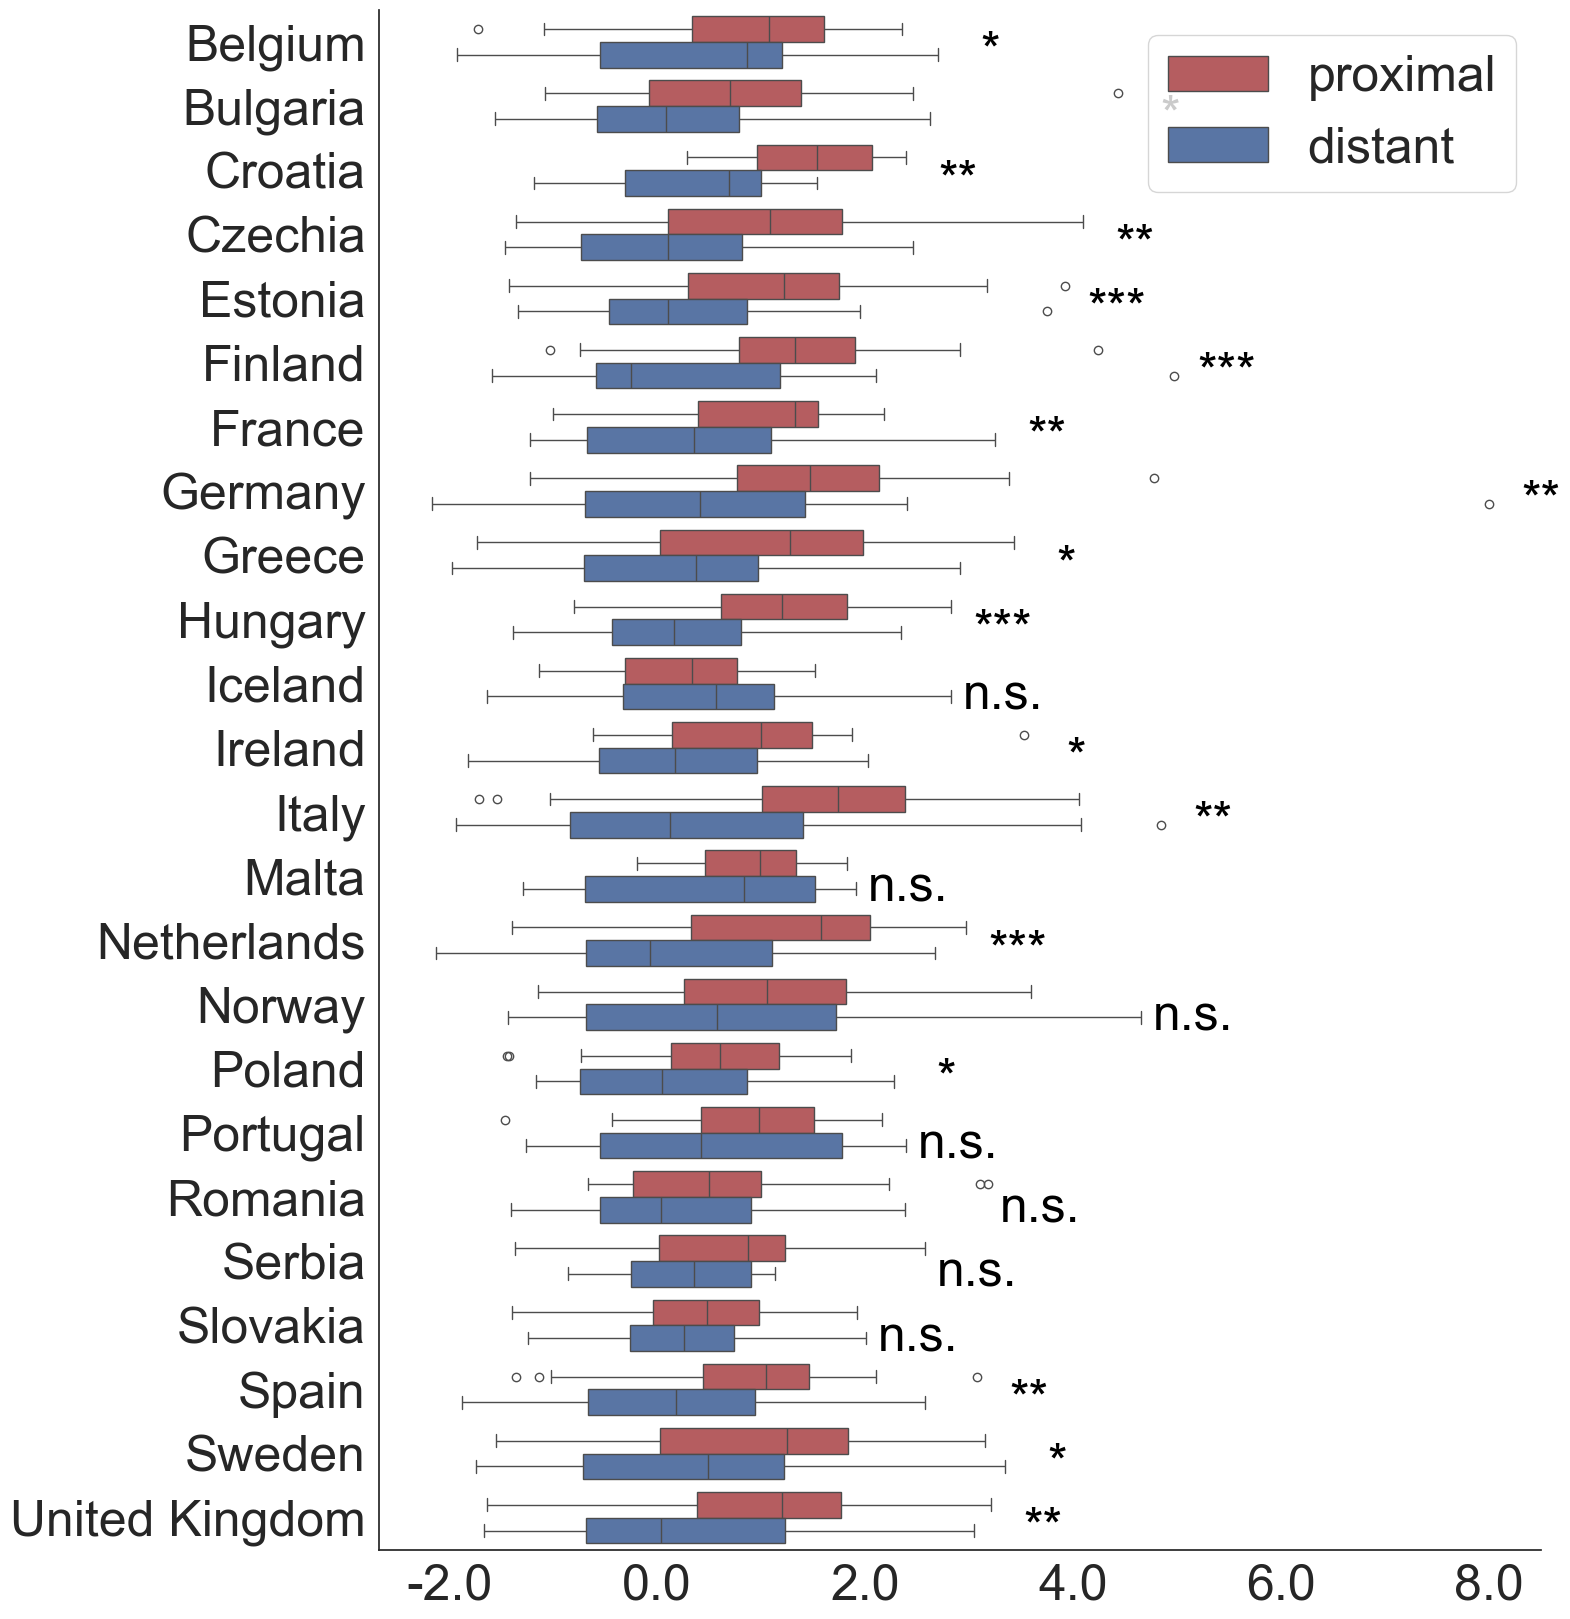

In [58]:
import scipy 
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["r", "b"], order=my_order,
                data=air_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

# Example of adding significance stars between two boxplots
# Let's assume you've got p-values and locations. You'll
# Placeholder list of p-values, x (z-score) and y (location) coordinates for the text, and the text to be added (stars).
# You need to calculate these based on your actual data and tests.
pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in air_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    # This part is tricky without the data; you need to find the specific y coordinates for your boxplots.
    # A simplistic approach:
    yloc = my_order.index(loc) + 0.4  # This presumes 'my_order' list contains the order of y-categories
    # Calculate x location for the text - this is simplistic and may not work out-of-the-box
    xloc = max(air_pollution_zscore_df[air_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  # Just a rough calculation, you might need to adjust it according to your data scale
  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

# Note: You will likely need to adjust the calculation of 'xloc' and 'yloc' to fit your data
# and the specific visual layout of your plot. This example assumes 'yloc' can be directly
# determined by the order in 'my_order', and 'xloc' is a rough guess needing adjustments.

plt.savefig('output/Figures/Figure4E_v08.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Once everything is set, display or save the figure
plt.show()



In [59]:
for country,disdict in n_country_selected_chem_id_gbd_mean_dict.items():
    print(country,len(disdict),len(new_country_distant_dis_dict[country]))

Czechia 41 38
Estonia 35 33
Norway 39 29
Sweden 38 24
Malta 17 17
Germany 45 32
Hungary 34 34
Belgium 43 34
France 46 35
Greece 46 30
Serbia 15 15
Slovakia 15 15
Portugal 25 25
United Kingdom 52 31
Ireland 31 31
Croatia 17 17
Italy 51 29
Spain 44 33
Bulgaria 33 33
Poland 41 31
Iceland 15 15
Romania 34 34
Finland 32 32
Netherlands 35 35


In [49]:
#Let's import the WHO data at a national level
#water
who_water_nation=pd.read_excel("input/WHO/F2_1_Total Releases at National Level into Water.xlsx",sheet_name=0)

In [50]:

country_set=set(who_water_nation['countryName'].tolist())
years=list(range(2007,2020))
country_chem_conc_water={}
for c in country_set:
    chem_concentration_dict={}
    for i,v in who_water_nation[who_water_nation['countryName']==c].iterrows():
        concentration=[]
        for y in years:
            concentration.append(v[y])
        concentration_clenaed=[x for x in concentration if str(x) != 'nan']
        chem_concentration_dict[v['pollutant']]=concentration_clenaed
    country_chem_conc_water[c]=chem_concentration_dict
 

In [51]:
len(country_chem_conc_water)

32

In [52]:
country_chem_conc_mean_water_dict={}
for c,chem_con in country_chem_conc_water.items():
    chem_mean_dict={}
    for chem,con_list in chem_con.items():
        chem_mean_dict[chem]=mean_list(con_list)
    country_chem_conc_mean_water_dict[c]=chem_mean_dict

In [53]:
chem_set=set(who_water_nation['pollutant'].tolist())

chem_across_countries_water_dict={}
for chem in chem_set:
    chem_median_across_countries_list=[]
    for c in country_set:
        try:
            chem_median_across_countries_list.append(country_chem_conc_mean_water_dict[c][chem])
        except:
            pass
    chem_across_countries_water_dict[chem]=chem_median_across_countries_list
    


In [54]:
#If a chemical compound is express only in 25% of the total countries (meaning that if a chemical compound is released
#only in 4 countries or less) then is considered as specific for that country. Otherwise the concentration in that 
#country should be > 75* percentile of the average concentration distribution across all countries
import statistics
country_selected_chem_water_dict={}

for country, chem_avgcon_dict in country_chem_conc_mean_water_dict.items():
    chem_list=[]
    for chem, avg_con_list in chem_across_countries_water_dict.items():
        if chem in chem_avgcon_dict.keys():
            if len(avg_con_list)>4:
                cutoff=np.percentile(avg_con_list,75)
                if chem_avgcon_dict[chem]>cutoff:
                    chem_list.append(chem)
            else:
                chem_list.append(chem)
    country_selected_chem_water_dict[country]=chem_list
                
        

In [55]:
np.mean([len(v) for v in country_selected_chem_water_dict.values()])

9.375

In [56]:
water_chem_name_conversion_dict = air_chem_name_conversion_dict.copy()

water_chem_name_conversion_dict['Triphenyltin and compounds'] = 'C030665'
water_chem_name_conversion_dict['Isoproturon'] = 'C028904'
water_chem_name_conversion_dict['Mirex'] = 'D008917'
water_chem_name_conversion_dict['Hexachlorobutadiene'] = 'C001335'
water_chem_name_conversion_dict['Heptachlor'] = 'D006533'

water_chem_name_conversion_dict['Diuron'] = 'D004237'
water_chem_name_conversion_dict['Chlorpyrifos'] = 'D004390'
water_chem_name_conversion_dict['Fluoranthene'] = 'C007738'
water_chem_name_conversion_dict['Toxaphene'] = 'D014112'
water_chem_name_conversion_dict['Halogenated organic compounds (as AOX)'] = 'D006846'

water_chem_name_conversion_dict['Simazine'] = 'D012839'
water_chem_name_conversion_dict['Atrazine'] = 'D001280'
water_chem_name_conversion_dict['Total nitrogen'] = 'D009584'
water_chem_name_conversion_dict['Dieldrin'] = 'D004026'
water_chem_name_conversion_dict['Chlordane'] = 'D002706'


water_chem_name_conversion_dict['Alachlor'] = 'C000188'
water_chem_name_conversion_dict['Chlorides'] = 'D002712'
water_chem_name_conversion_dict['DDT (DDT)'] = 'D003634'
water_chem_name_conversion_dict['Tributyltin and compounds'] = 'C011559'
water_chem_name_conversion_dict['Chlorfenvinphos'] = 'D002709'


water_chem_name_conversion_dict['Endrin'] = 'D004732'
water_chem_name_conversion_dict['Organotin compounds (as total Sn)'] = 'D009947'
water_chem_name_conversion_dict['1,2,3,4,5,6-hexachlorocyclohexane (HCH)'] = 'D001556'
water_chem_name_conversion_dict['Trifluralin'] = 'D014274'
water_chem_name_conversion_dict['Cyanides (as total CN)'] = 'D003486'

In [57]:
n_country_selected_chem_id_water_dict={}
chem_id_list = list(chem_id_name_conversion.keys())
for country,chem_list in country_selected_chem_water_dict.items():
    id_chem_list=[]
    for chem in chem_list:
        try:
            if chem!='PCDD + PCDF (dioxins + furans) (as Teq)':   
                if water_chem_name_conversion_dict[chem] in chem_id_list:
                    id_chem_list.append(water_chem_name_conversion_dict[chem])
            else:
                if 'D005663' in chem_id_list:
                    id_chem_list.append('D005663')
                if 'D000072316' in chem_id_list:
                    id_chem_list.append('D000072316')
                if 'D004147' in chem_id_list:
                    id_chem_list.append('D004147')
        except:
            pass

    n_country_selected_chem_id_water_dict[country]=set(id_chem_list)

In [70]:
np.mean([len(v) for v in n_country_selected_chem_id_water_dict.values()])

8.0

In [71]:
len([i for i in n_country_selected_chem_id_water_dict.keys() if len(n_country_selected_chem_id_water_dict[i])>0])

23

In [465]:
with open('intermediate/country_selected_chem_id_water_dict.pickle', 'wb') as handle:
    pk.dump(n_country_selected_chem_id_water_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [58]:

country_water_proximal_dis_dict={}
for country, chem_list in n_country_selected_chem_id_water_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in real_significant_final_exp_proximity.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    country_water_proximal_dis_dict[country]=set(dis_list)

In [59]:
water_proximal_disease_list = [] 

for country, disset in country_water_proximal_dis_dict.items():
    for dis in disset:
        if dis not in water_proximal_disease_list:
            water_proximal_disease_list.append(dis)

print(len(water_proximal_disease_list))

200


In [60]:
water_disgenet_gbd_dict = air_disgenet_gbd_dict.copy()

In [473]:
for dis in water_proximal_disease_list:
    if dis not in list(water_disgenet_gbd_dict.keys()):
        dis_disgenet_lower = dis.lower()
        possible_dislist = []
        for dis_gbd in disease_set:
            dis_gbd_lower = dis_gbd.lower()
            if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_disgenet_lower) or len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_gbd_lower):
                possible_dislist.append(dis_gbd)
        if len(possible_dislist)>0:
            print(dis,">", possible_dislist)



Mouth Neoplasms > ['Gout', 'Neoplasms']
Myocardial Reperfusion Injury > ['Myocarditis']
Inflammation > ['Inflammatory bowel disease']
Familial thoracic aortic aneurysm and aortic dissection > ['Aortic aneurysm']
Neoplasm Metastasis > ['Neoplasms']
Bladder Neoplasm > ['Other neoplasms', 'Neoplasms']
Malignant neoplasm of esophagus > ['Other malignant neoplasms', 'Neoplasms']
Colitis > ['Cellulitis', 'Encephalitis']
Head and Neck Neoplasms > ['Neoplasms']
Hereditary Breast and Ovarian Cancer Syndrome > ['Ovarian cancer', 'Turner syndrome']
Malignant neoplasm of mouth > ['Other malignant neoplasms', 'Gout', 'Neoplasms']
Acute Promyelocytic Leukemia > ['Leukemia']
Precursor T-Cell Lymphoblastic Leukemia-Lymphoma > ['Leukemia']
MIGRAINE WITH OR WITHOUT AURA, SUSCEPTIBILITY TO, 1 > ['Gout', 'Migraine']
Juvenile Myelomonocytic Leukemia > ['Leukemia']
Male infertility > ['Female infertility', 'Male infertility', 'Urinary diseases and male infertility']
Precursor Cell Lymphoblastic Leukemia Lym

In [61]:
#Let's add some more diseases manually
water_disgenet_gbd_dict['Amyotrophic Lateral Sclerosis']='Motor neuron disease'
water_disgenet_gbd_dict['Familial thoracic aortic aneurysm and aortic dissection']='Aortic aneurysm'
water_disgenet_gbd_dict['Bladder Neoplasm']='Bladder cancer'
water_disgenet_gbd_dict['Malignant neoplasm of esophagus']='Esophageal cancer'
water_disgenet_gbd_dict['Acute Promyelocytic Leukemia']='Leukemia'
water_disgenet_gbd_dict['Precursor T-Cell Lymphoblastic Leukemia-Lymphoma']='Leukemia'
water_disgenet_gbd_dict['Juvenile Myelomonocytic Leukemia']='Leukemia'
water_disgenet_gbd_dict['MIGRAINE WITH OR WITHOUT AURA, SUSCEPTIBILITY TO, 1']='Migraine'
water_disgenet_gbd_dict['Male infertility']='Male infertility'
water_disgenet_gbd_dict['Precursor Cell Lymphoblastic Leukemia Lymphoma']='Leukemia'
water_disgenet_gbd_dict['Osteoarthritis of hip']='Osteoarthritis hip'
water_disgenet_gbd_dict['Stomach Carcinoma']='Stomach cancer'
water_disgenet_gbd_dict['Hypertrophic Cardiomyopathy']='Other cardiomyopathy'
water_disgenet_gbd_dict['Cerebral Hemorrhage']='Intracerebral hemorrhage'

print(len(water_disgenet_gbd_dict))

103


In [62]:
country_water_dis_mean_prox_dict = {}
for country,disset in country_water_proximal_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(n_country_selected_chem_id_water_dict[country])>0:
            for chem in n_country_selected_chem_id_water_dict[country]:
                try:
                    z_list.append(real_significant_final_exp_proximity[chem,dis][1])
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_water_dis_mean_prox_dict[country] = dis_dict


In [63]:


n_country_water_chem_id_gbd_dict = {}

for country,dis_dict in country_water_dis_mean_prox_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([water_disgenet_gbd_dict[dis],z])
            except:
                pass
        n_country_water_chem_id_gbd_dict[country] = dis_z_list
            

In [64]:


from collections import Counter

n_country_water_chem_id_gbd_mean_dict = {}
for country,dislist in n_country_water_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
        
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    n_country_water_chem_id_gbd_mean_dict[country]=dis_dict

            

In [ ]:
for country,disset in country_water_proximal_dis_dict.items():
    if len(disset)>0:
        for chem in n_country_selected_chem_id_water_dict[country]:
            for dis in disset:
                try:
                    z = real_significant_final_exp_proximity[chem,dis][1]
                    if z<-2:
                        print(country+";"+chem_id_name_conversion[chem]+";"+dis+";"+str(round(z,2)))
                except:
                    pass
        

In [65]:
n_country_water_faraway_dis_dict={}
for country,chemset in n_country_selected_chem_id_water_dict.items():
    if len(chemset)>0:
        far_away_dis_set = []
        for chem in chemset:
            for chem_dis_pair in faraway_exp_dis_dict.keys():
                if chem in chem_dis_pair[0]:
                    far_away_dis_set.append(chem_dis_pair[1])
        n_country_water_faraway_dis_dict[country] = set(far_away_dis_set)



In [66]:


faraway_water_disset = []

for country,disset in n_country_water_faraway_dis_dict.items():
    for dis in disset:
        if dis not in faraway_water_disset:
            faraway_water_disset.append(dis)

print(len(faraway_water_disset))

296


In [67]:
n_long_faraway_water_disset_gbd_dict = {}
for dis1 in faraway_water_disset:
    dis1_processed = preprocess_string(dis1)
    # Initialize best match tracking
    best_match = (None, 0)  # (Best match disease name, similarity score)
    for dis2 in disease_set:
        dis2_processed = preprocess_string(dis2)
        similarity = get_similarity_score(dis1_processed, dis2_processed)
        # Update if this is the best match so far
        if similarity > best_match[1]:
            best_match = (dis2, similarity)
    
    # You may want to set a threshold for "good enough" matching
    if best_match[1] > 50:  # This threshold
        n_long_faraway_water_disset_gbd_dict[dis1] = best_match[0]

print(len(n_long_faraway_water_disset_gbd_dict))

165


In [68]:
keys_to_delete=['Weill-Marchesani-Like Syndrome','HYPOGONADOTROPIC HYPOGONADISM 11 WITH OR WITHOUT ANOSMIA','Night blindness, congenital stationary',
             'Narcolepsy 1', 'DEAFNESS, X-LINKED 4 (disorder)','Juvenile nephropathic cystinosis (disorder)', 'Congenital Pain Insensitivity',
                'Nephropathic cystinosis','Congenital long QT syndrome','Glomerulocystic Kidney Disease with Hyperuricemia and Isosthenuria',
                'Keutel syndrome','FICOLIN 3 DEFICIENCY','Autosomal Dominant Nocturnal Frontal Lobe Epilepsy','Cavitary Optic Disc Anomalies',
                'alpha, alpha-Trehalase deficiency','Nephritis, Tubulointerstitial','Cerebral ventriculomegaly','HYPOGONADOTROPIC HYPOGONADISM 4 WITH OR WITHOUT ANOSMIA',
                'Goiter','Medullary Cystic Kidney Disease Type 2','Malabsorption Syndrome','CATARACT 39, MULTIPLE TYPES',
                'Long Qt Syndrome 10','RETINITIS PIGMENTOSA 49','Olmsted syndrome','Cystinosis','HIRSCHSPRUNG DISEASE, SUSCEPTIBILITY TO, 4',
                'MASP2 Deficiency','Cone monochromatism','Enterokinase Deficiency','Retinitis Pigmentosa 7','Narcolepsy','Jarcho-Levin syndrome',
                'Waardenburg Syndrome, Type 4b','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E','Factor XIII, B Subunit, Deficiency Of',
                'Renal hypouricemia','MYASTHENIC SYNDROME, CONGENITAL, 1A, SLOW-CHANNEL','BLEEDING DISORDER, PLATELET-TYPE, 20',
                'SMALL PATELLA SYNDROME','Amish Infantile Epilepsy Syndrome','Scoliosis, unspecified','Focal glomerulosclerosis',
                'Meningococcal Infections','Indifference to Pain, Congenital, Autosomal Recessive','Neuropathy, Distal Hereditary Motor, Type VIIA',
                'Obstruction of pelviureteric junction','TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5','Marshall syndrome','STICKLER SYNDROME, TYPE II (disorder)',
                'Histiocytosis','Hypopigmentation disorder','PAROXYSMAL EXTREME PAIN DISORDER','NEMALINE MYOPATHY 10','DEAFNESS, AUTOSOMAL RECESSIVE 42 (disorder)',
                'Nivelon Nivelon Mabille syndrome','HERMANSKY-PUDLAK SYNDROME 4','Juvenile hemochromatosis','HEMOCHROMATOSIS, TYPE 2A','USHER SYNDROME, TYPE IJ',
                'CATARACT 47','Usher Syndrome, Type IF','Hypouricemia, Renal, 2','NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1G','Primary Erythermalgia',
                'Trimethylaminuria','Hypertrichosis','Congenital disorder of glycosylation, type 2C','Night Blindness, Congenital Stationary, Autosomal Dominant 3',
                'Lysinuric Protein Intolerance','RETINITIS PIGMENTOSA, JUVENILE, LRAT-RELATED','Trichotillomania','Hydrocephalus','Usher Syndrome, Type I',
                'STARGARDT DISEASE 1 (disorder)','Perisylvian syndrome','Liver Failure','CATARACT 4, MULTIPLE TYPES','DEAFNESS, AUTOSOMAL RECESSIVE 1A (disorder)',
                'CILIARY DYSKINESIA, PRIMARY, 7 (disorder)','Vesico-Ureteral Reflux','VAN DER WOUDE SYNDROME 1','Hyperaldosteronism','Popliteal pterygium syndrome',
                'Riboflavin Deficiency','Zunich neuroectodermal syndrome','Hypercalcemia, Infantile','CONE-ROD DYSTROPHY 3 (disorder)','RETINITIS PIGMENTOSA 19','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Ip',
                'Juvenile macular degeneration',"Stargardt's disease",'RETINITIS PIGMENTOSA 48'
                
]

n_long_faraway_water_disset_gbd_dict_cleaned_v1 = {}
for disgenet_dis, gbd_dis in n_long_faraway_water_disset_gbd_dict.items():
    if disgenet_dis not in keys_to_delete:
        n_long_faraway_water_disset_gbd_dict_cleaned_v1[disgenet_dis] = gbd_dis
        

In [69]:
keys_to_delete_v2 = ['JOUBERT SYNDROME 16','Leber Congenital Amaurosis 14','Dursun Syndrome','Neutropenia, Severe Congenital, Autosomal Recessive 4',
                     'Dihydropyrimidinase deficiency','Deuteranomaly','CRANIOSYNOSTOSIS AND DENTAL ANOMALIES','Canavan Disease','Canavan Disease, Juvenile',
                     'Dimethylglycine Dehydrogenase Deficiency','Retinitis Pigmentosa','Amnesia','POLYARTERITIS NODOSA, CHILDHOOD-ONSET','RETINITIS PIGMENTOSA 30',
                     'NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1B','Weill-Marchesani syndrome','Ectodermal Dysplasia','MACULAR DYSTROPHY, PATTERNED, 1',
                     'STEEL SYNDROME','CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Iu','Pfaundler-Hurler Syndrome','CATARACT 19, MULTIPLE TYPES',
                     'RETINITIS PIGMENTOSA 45','HYPERGLYCINURIA (disorder)','Arterial calcification of infancy','HYPOGONADOTROPIC HYPOGONADISM 3 WITH OR WITHOUT ANOSMIA',
                     'Muscle eye brain disease','Epilepsy','SEIZURES, BENIGN FAMILIAL INFANTILE, 3','Deafness, Autosomal Dominant 3B','West Syndrome',
                     'Multiple synostoses syndrome 1','Hurler-Scheie Syndrome','Bardet-Biedl Syndrome','Sneddon Syndrome','Idiopathic Pulmonary Fibrosis',
                     'Holoprosencephaly','MYASTHENIC SYNDROME, CONGENITAL, 4A, SLOW-CHANNEL','Leber Congenital Amaurosis','CEROID LIPOFUSCINOSIS, NEURONAL, 13',
                     'Hermanski-Pudlak Syndrome','Pain','Gilles de la Tourette syndrome','Canavan Disease, Infantile','Congenital hemihypertrophy',
                     'Myasthenic Syndromes, Congenital','Meleda Disease','Intervertebral disc disorder','Nonsyndromic Deafness'
    
]



n_long_faraway_water_disset_gbd_dict_cleaned_v2 = {}
for disgenet_dis, gbd_dis in n_long_faraway_water_disset_gbd_dict_cleaned_v1.items():
    if disgenet_dis not in keys_to_delete_v2:
        n_long_faraway_water_disset_gbd_dict_cleaned_v2[disgenet_dis] = gbd_dis

n_long_faraway_water_disset_gbd_dict_cleaned_v2['Epilepsy'] = 'Idiopathic epilepsy'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['SEIZURES, BENIGN FAMILIAL INFANTILE, 3'] = 'Idiopathic epilepsy'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 39, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 1E'] = 'Blindness and vision loss'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 4, MULTIPLE TYPES'] = 'Cataract'
n_long_faraway_water_disset_gbd_dict_cleaned_v2['CATARACT 47'] = 'Cataract'


water_faraway_dis_list = list(n_long_faraway_water_disset_gbd_dict_cleaned_v2.values())
water_faraway_dis_list.extend(['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies'])

print(len(water_faraway_dis_list))


32


In [70]:
faraway_manually_added_diseases = ['Congenital musculoskeletal and limb anomalies','Congenital birth defects','Congenital heart anomalies']

country_water_faraway_dis_dict = {}
for country,dis_dict in n_country_water_chem_id_gbd_mean_dict.items():
    chem_set = n_country_selected_chem_id_water_dict[country]
    country_faraway_dis_list = []
    country_specific_faraway_dis_dict = {}
    
    for dis in water_faraway_dis_list:
        if dis not in dis_dict.keys():
            country_faraway_dis_list.append(dis)
    for dis in country_faraway_dis_list:
        if dis not in faraway_manually_added_diseases:
            disgenet_name_list = []
            z_score_list = []
            for disgenet_name,gbd_id in n_long_faraway_water_disset_gbd_dict_cleaned_v2.items():
                if dis == gbd_id:
                    disgenet_name_list.append(disgenet_name)
                    for chem in chem_set:
                        try:
                            z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                        except:
                            pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        elif dis=='Congenital heart anomalies':
            disgenet_name_list = ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon',
                                 'Congenital long QT syndrome']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
        
        elif dis=='Congenital musculoskeletal and limb anomalies':
            disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                 'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                 'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                 'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                 'Congenital Fibrosis of the Extraocular Muscles']
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)
            
        elif dis=='Congenital birth defects':
            disgenet_name_list = [dis for dis in list(diseases_genes_associated_ppi.keys()) if 'Congenital' in dis or 'congenital' in dis]
            z_score_list = []
            for disgenet_name in disgenet_name_list:
                for chem in chem_set:
                    try:
                        z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                    except:
                        pass
            if np.mean(z_score_list)>1.5:
                country_specific_faraway_dis_dict[dis]=np.mean(z_score_list)

    country_water_faraway_dis_dict[country] = country_specific_faraway_dis_dict

    

/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [71]:
#We will use the same no-proximal disease sets/dictionary that we have calcualted for the air pollution

country_noprox_water_dis_dict = {}
for country,dis_dict in n_country_water_chem_id_gbd_mean_dict.items():
    n_dis = len(dis_dict)
    chem_set = n_country_selected_chem_id_water_dict[country]
    country_noprox_dis_list = []
    country_specific_noprox_dis_dict = {}
    
    for gbd_dis,dislist in no_prox_air_disset_gbd_dict_cleaned_inv.items():
        if gbd_dis not in dis_dict.keys():
            if gbd_dis not in list(country_water_faraway_dis_dict[country].keys()):
                country_noprox_dis_list.append(gbd_dis)
    for dis in country_noprox_dis_list:
        disgenet_name_list = no_prox_air_disset_gbd_dict_cleaned_inv[dis]
        z_score_list = []
        for chem in chem_set:
            for disgenet_name in disgenet_name_list:
                try:
                    z_score_list.append(exp_proximity_not_significant[chem,disgenet_name][1])
                except:
                    pass
        if np.mean(z_score_list)>-1.5:
            country_specific_noprox_dis_dict[dis]=np.mean(z_score_list)
    country_specific_noprox_dis_dict_sort = {k: v for k, v in sorted(country_specific_noprox_dis_dict.items(), key=lambda item: item[1])}
    
    if len(country_specific_noprox_dis_dict_sort)>n_dis:
        country_specific_noprox_dis_dict_sort_keys = list(country_specific_noprox_dis_dict_sort.keys())
        n_country_specific_noprox_dis_dict_sort = {}
        for k in list(country_specific_noprox_dis_dict_sort_keys)[:n_dis]:
            n_country_specific_noprox_dis_dict_sort[k]=country_specific_noprox_dis_dict_sort[k]
        
        country_noprox_water_dis_dict[country] = n_country_specific_noprox_dis_dict_sort
    else:
        country_noprox_water_dis_dict[country] = country_specific_noprox_dis_dict_sort
 


In [193]:
#Let's just merge the no-proximal dictionary and the faraway dictionary
new_water_country_distant_dis_dict = {}
for country,dis_dict in n_country_water_chem_id_gbd_mean_dict.items():
    n_proxdis = len(dis_dict)
    n_distantdis = len(country_water_faraway_dis_dict[country])
    noprox_list = list(country_noprox_water_dis_dict[country].keys())
    missing_dis = n_proxdis-n_distantdis
    try:
        dislist = noprox_list[:missing_dis]
        distant_dict = country_water_faraway_dis_dict[country].copy()
        for dis in dislist:
            distant_dict[dis] = country_noprox_water_dis_dict[country][dis]
        new_water_country_distant_dis_dict[country] = distant_dict
    except:
        distant_dict = {**country_water_faraway_dis_dict[country], **country_noprox_water_dis_dict[country]}
        new_water_country_distant_dis_dict[country] = distant_dict
 

In [194]:
proximal_dis_list=[] 
for country, disdict in n_country_water_chem_id_gbd_mean_dict.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list
        

In [ ]:
import seaborn as sns
water_country_proximal_zscore_dict={}
for country,dis_dict in n_country_water_chem_id_gbd_mean_dict.items():
    country_proximal_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(proximal_dis_incidence[dis])
        std = np.std(proximal_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_proximal_zscore_list.append(z)


        sns.set_style('white')
        sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
        plt.figure(figsize=(10,10))
        plt.vlines(country_dis_incidence[country][dis],ymin=0,ymax=0.014,color='r',label='%s'%country)
        sns.kdeplot(proximal_dis_incidence[dis],color='k',lw=.5,alpha=.5,shade=True,label='World')
        plt.legend(loc='upper left',fontsize=12)
        plt.ylabel('Density',fontsize=12)
        plt.xlabel('Incidence',fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("%s incidence" %dis,fontsize=20)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_proximal_zscore_dict[country]=country_proximal_zscore_list
    

In [196]:
distant_dis_list=[] 
for country, disdict in new_water_country_distant_dis_dict.items():
    distant_dis_list.extend(list(disdict.keys()))
    
distant_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(distant_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    distant_dis_incidence[dis]=incidence_list
        

In [ ]:
water_country_distant_zscore_dict={}

for country,dis_dict in new_water_country_distant_dis_dict.items():
    country_distant_zscore_list=[]
    for dis in list(dis_dict.keys()):
        mu = np.mean(distant_dis_incidence[dis])
        std = np.std(distant_dis_incidence[dis])

        z = (country_dis_incidence[country][dis]-mu)/std
        country_distant_zscore_list.append(z)


        sns.set_style('white')
        sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
        plt.figure(figsize=(10,10))
        plt.vlines(country_dis_incidence[country][dis],ymin=0,ymax=0.014,color='r',label='%s'%country)
        sns.kdeplot(distant_dis_incidence[dis],color='k',lw=.5,alpha=.5,shade=True,label='World')
        plt.legend(loc='upper left',fontsize=12)
        plt.ylabel('Density',fontsize=12)
        plt.xlabel('Incidence',fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("%s incidence" %dis,fontsize=20)
        from scipy.stats import norm
        ptemp = norm.sf(abs(z))
    water_country_distant_zscore_dict[country]=country_distant_zscore_list
    

In [198]:
water_pollution_zscore_df = pd.DataFrame()

selected_countries=set(water_country_distant_zscore_dict.keys())
tot_country_list=[]
tot_zscore_list=[]
location_network_list=[]
for country in selected_countries:
    farawaylist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    tot_zscorelist_partial=farawaylist_cleaned+proximallist_cleaned
    for i in proximallist_cleaned:
        location_network_list.append("proximal")
        tot_zscore_list.append(i)
        tot_country_list.append(country)
    for i in farawaylist_cleaned:
        location_network_list.append("distant")
        tot_zscore_list.append(i)
        tot_country_list.append(country)

water_pollution_zscore_df['location']=tot_country_list
water_pollution_zscore_df['z-score']=tot_zscore_list
water_pollution_zscore_df['network_location']=location_network_list

In [199]:
my_order = sorted(list(set(water_pollution_zscore_df['location'])))

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/1915764658.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 36)


[Text(-3.0, 0, '-3.0'),
 Text(-2.0, 0, '-2.0'),
 Text(-1.0, 0, '-1.0'),
 Text(0.0, 0, '0.0'),
 Text(1.0, 0, '1.0'),
 Text(2.0, 0, '2.0'),
 Text(3.0, 0, '3.0'),
 Text(4.0, 0, '4.0'),
 Text(5.0, 0, '5.0'),
 Text(6.0, 0, '6.0')]

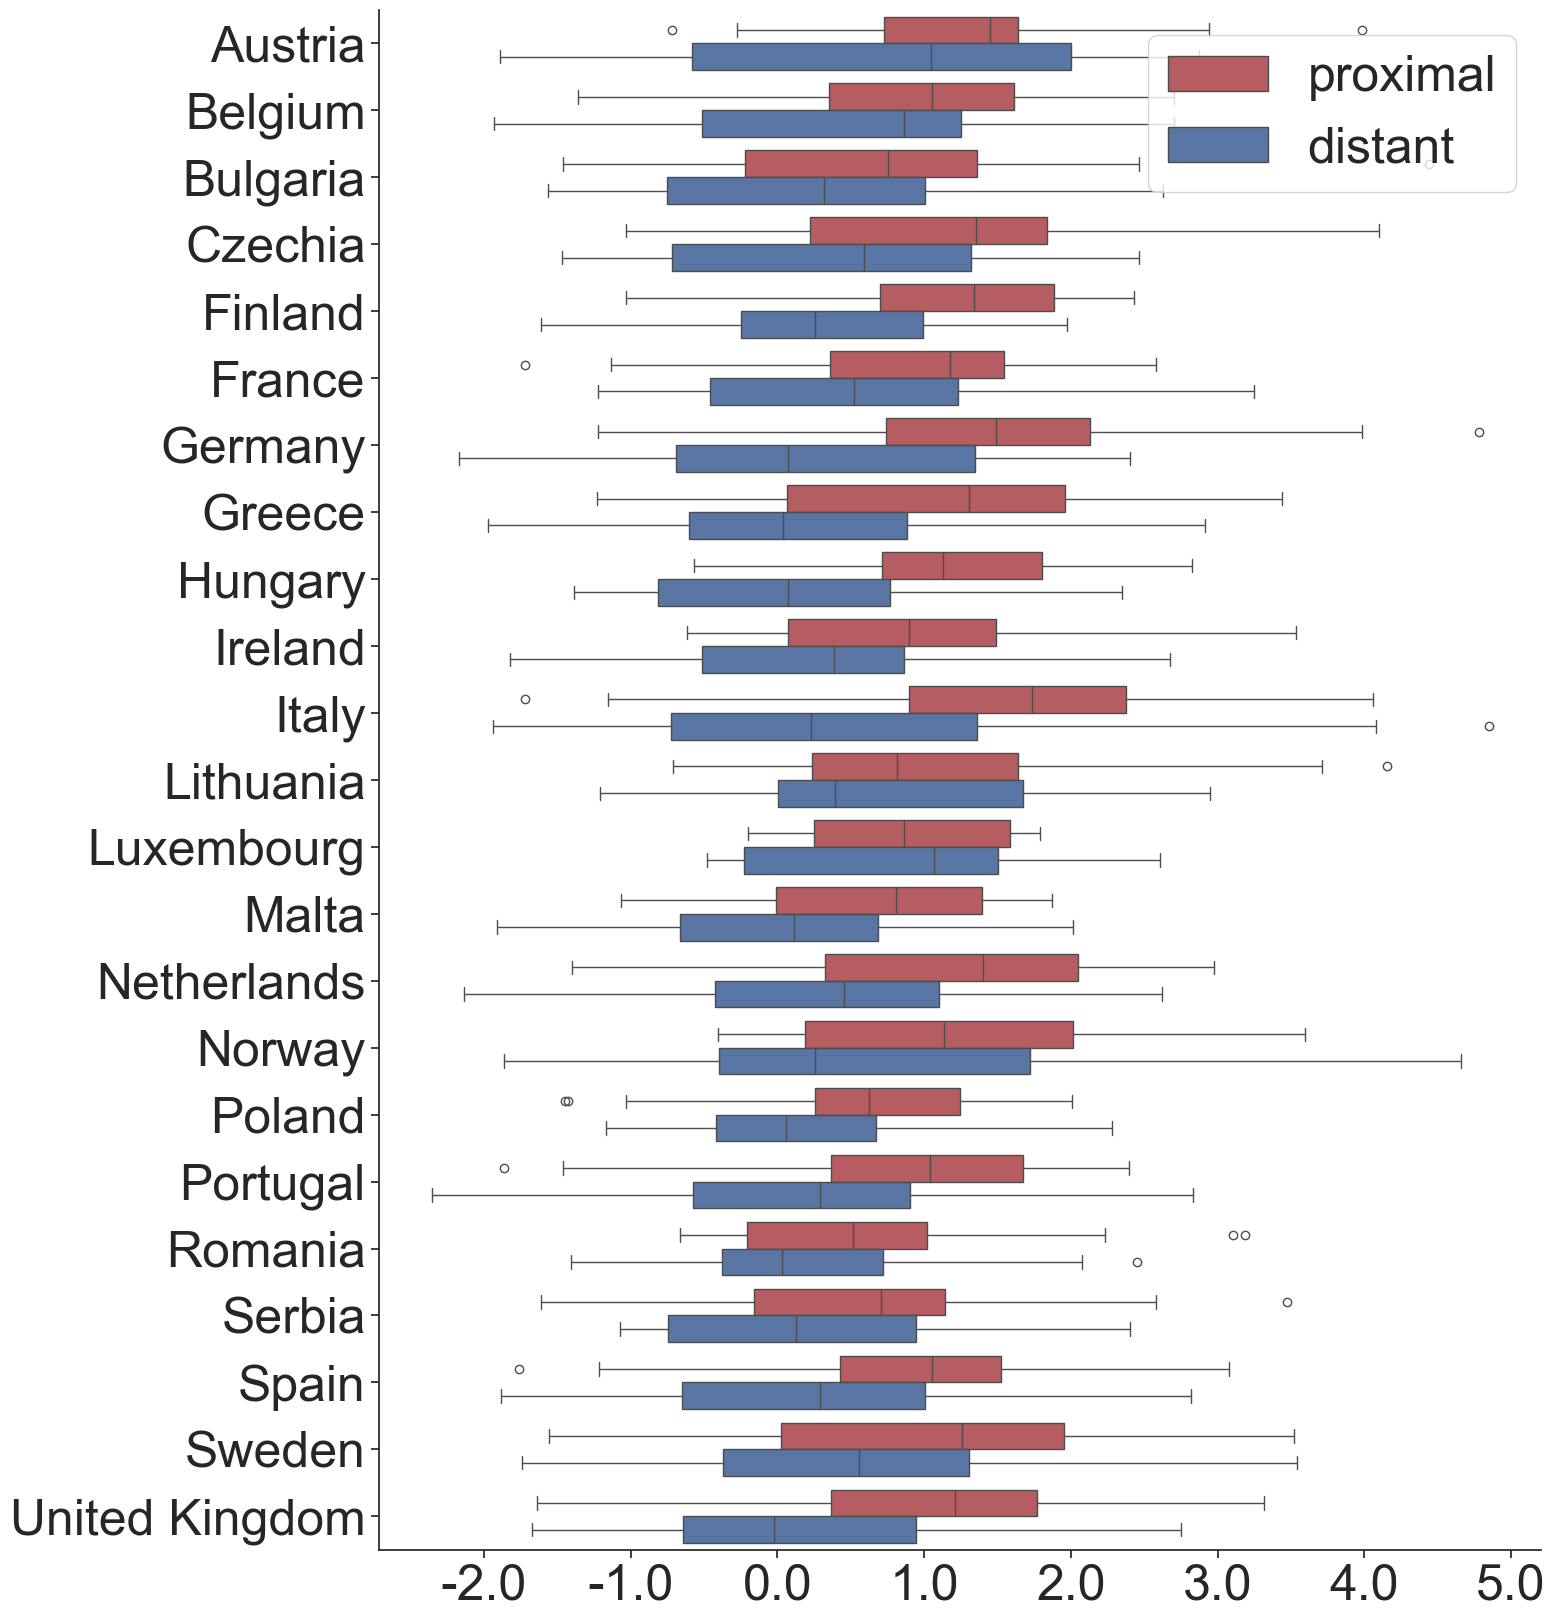

In [200]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
# Draw a nested boxplot to show bills by day and time
g=sns.boxplot(x="z-score", y="location",orient="h",
            hue="network_location", palette=["r","b"],order=my_order,
            data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)
#g.set_xscale("log")
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
#plt.title('Incidence of network proximal and distant diseases to air polluted from 2000 to 2019', fontsize=25)
plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(ax.get_xticks(), size = 36)



In [201]:
#Let's test the difference between proximal and no-proximal (because with distant is kind of obvious and it doesn't
#make so much sense)
import scipy
for country in selected_countries:
    try:
        proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
        distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
        prox_mean = np.mean(proximallist_cleaned)
        distant_mean = np.mean(distantlist_cleaned)
        pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
        print(country,prox_mean,distant_mean,round(pval_noprox,4),round(pval_distant,4))
    except:
        print(country,prox_mean,distant_mean,round(pval_noprox,4))
        

Belgium 0.9319729956448254 0.43115271569143654 0.0539
Portugal 0.9078079695554164 0.22155276337765034 0.0036
Germany 1.400638355439378 0.30359048465032246 0.0012
Norway 1.1720000660686272 0.6566248607372559 0.0386
Greece 1.1015550656892978 0.22341051964112213 0.0035
Malta 0.7224625891787078 0.0319239409732491 0.0035
Finland 1.109693924730956 0.31591438169930947 0.0403
Austria 1.2219129553935644 0.7743100140840036 0.1454
Hungary 1.2053925132204266 0.12732017075079008 0.0003
Serbia 0.5644186755527083 0.23660734301464187 0.1072
Czechia 1.1563255527900878 0.37479368678140945 0.006
France 0.8853590919741728 0.46877835909340176 0.0178
United Kingdom 1.1056050290003407 0.18289155033952015 0.0006
Netherlands 1.137508067218807 0.3312112154843404 0.011
Lithuania 0.9544813430663361 0.7509043534548635 0.305
Luxembourg 0.8795826565710801 0.8984693892176485 0.4295
Italy 1.5198016657595286 0.4804506116943969 0.0016
Poland 0.6309955221234086 0.17567641004703244 0.014
Romania 0.5855253914589236 0.16186

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/2088463591.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=36)


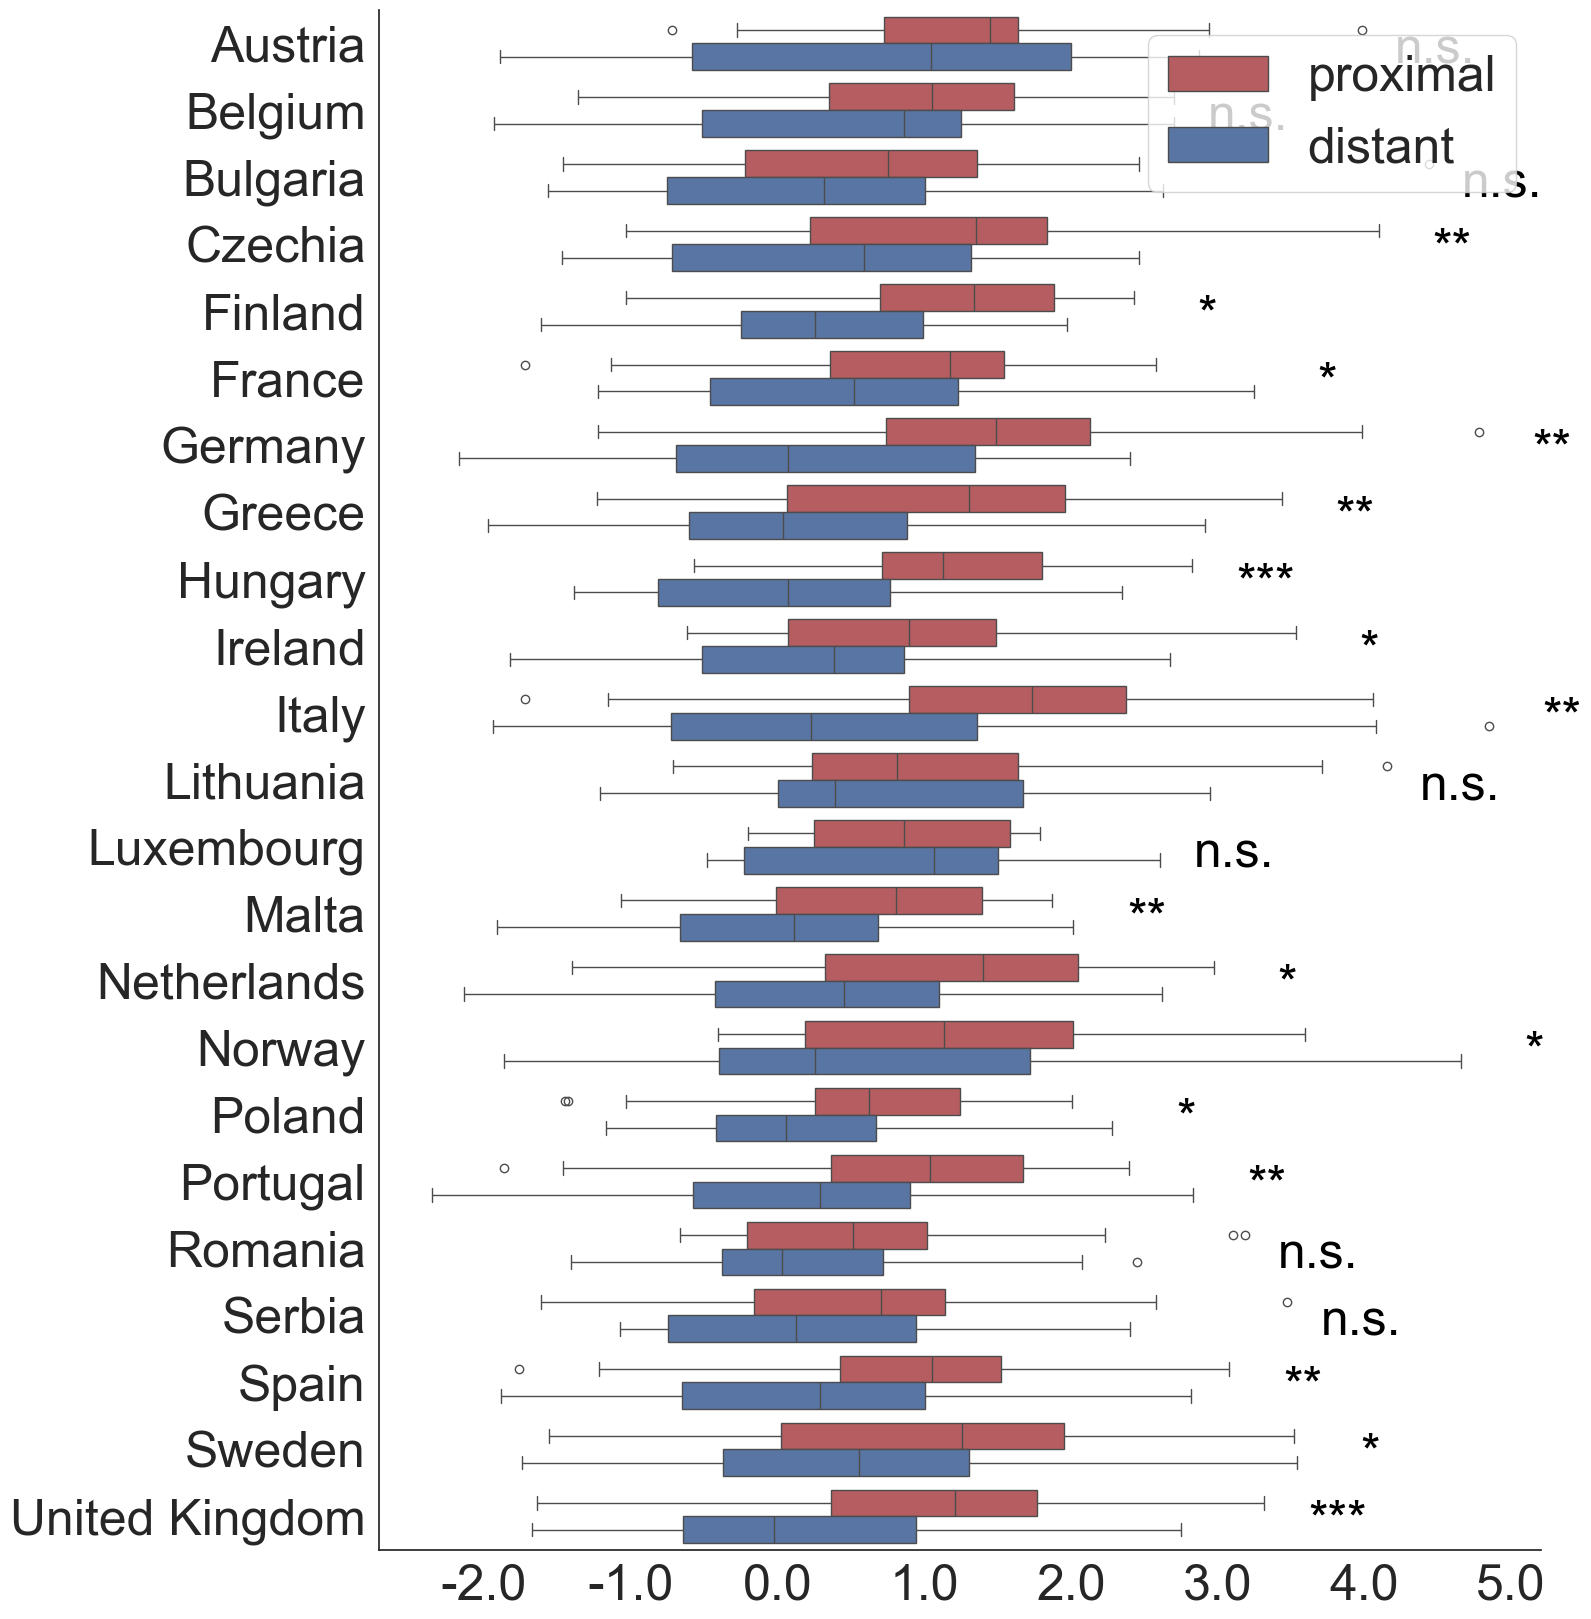

In [202]:
# Assuming your data loading and plot setup code here

fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")
g = sns.boxplot(x="z-score", y="location", orient="h",
                hue="network_location", palette=["r", "b"], order=my_order,
                data=water_pollution_zscore_df)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xticklabels(ax.get_xticks(), size=36)

# Example of adding significance stars between two boxplots
# Let's assume you've got p-values and locations. You'll
# Placeholder list of p-values, x (z-score) and y (location) coordinates for the text, and the text to be added (stars).
# You need to calculate these based on your actual data and tests.
pv_list = []  # Example p-values
locations = []  # Example y-axis categories
stars = []  # Based on the p-values, this is what we want to add



for country in my_order:
    proximallist_cleaned = [x for x in water_country_proximal_zscore_dict[country] if str(x) != 'nan']
    distantlist_cleaned = [x for x in water_country_distant_zscore_dict[country] if str(x) != 'nan']
    prox_mean = np.mean(proximallist_cleaned)
    distant_mean = np.mean(distantlist_cleaned)
    pval_noprox = scipy.stats.mannwhitneyu(proximallist_cleaned, distantlist_cleaned, use_continuity=True, alternative='greater')[1]
    pv_list.append(pval_noprox)
    locations.append(country)
    if pval_noprox<0.001:
        stars.append("***")
    elif pval_noprox>0.001 and pval_noprox<0.01:
        stars.append("**")
    elif pval_noprox>0.01 and pval_noprox<0.05:
        stars.append("*")
    else:
        stars.append("n.s.")


for pv, loc, star in zip(pv_list, locations, stars):
    # This part is tricky without the data; you need to find the specific y coordinates for your boxplots.
    # A simplistic approach:
    yloc = my_order.index(loc) + 0.3  # This presumes 'my_order' list contains the order of y-categories
    # Calculate x location for the text - this is simplistic and may not work out-of-the-box
    xloc = max(water_pollution_zscore_df[water_pollution_zscore_df['location'] == loc]['z-score']) + 0.5  # Just a rough calculation, you might need to adjust it according to your data scale
  
    # Add the annotation
    ax.text(xloc, yloc, star, fontsize=fontsize, color="black", ha='center')

# Note: You will likely need to adjust the calculation of 'xloc' and 'yloc' to fit your data
# and the specific visual layout of your plot. This example assumes 'yloc' can be directly
# determined by the order in 'my_order', and 'xloc' is a rough guess needing adjustments.
plt.savefig('output/Figures/Figure4F_v09.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Once everything is set, display or save the figure
plt.show()



In [ ]:
#We should try with more diseases... so, we will include all proximal results

In [75]:
country_water_proximal_dis_dict_extended={}
for country, chem_list in n_country_selected_chem_id_water_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in new_significant_exp_dis_proximity_pval_adj.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    country_water_proximal_dis_dict_extended[country]=set(dis_list)

In [76]:
water_proximal_disease_list_extended = [] 

for country, disset in country_water_proximal_dis_dict_extended.items():
    for dis in disset:
        if dis not in water_proximal_disease_list_extended:
            water_proximal_disease_list_extended.append(dis)

print(len(water_proximal_disease_list_extended))

1216


In [77]:
water_disgenet_gbd_dict_extended = water_disgenet_gbd_dict.copy()

In [ ]:
for dis in water_proximal_disease_list_extended:
    if dis not in list(water_disgenet_gbd_dict_extended.keys()):
        dis_disgenet_lower = dis.lower()
        possible_dislist = []
        for dis_gbd in disease_set:
            dis_gbd_lower = dis_gbd.lower()
            if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_disgenet_lower) or len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_gbd_lower):
                possible_dislist.append(dis_gbd)
        if len(possible_dislist)>0:
            print(dis,">", possible_dislist)



In [78]:
#Let's add some more diseases manually

water_disgenet_gbd_dict_extended['Glaucoma']='Glaucoma'
water_disgenet_gbd_dict_extended['Motor Neuron Disease']='Motor neuron disease'
water_disgenet_gbd_dict_extended['AMYOTROPHIC LATERAL SCLEROSIS 22 WITH OR WITHOUT FRONTOTEMPORAL DEMENTIA ']='Motor neuron disease'
water_disgenet_gbd_dict_extended['Age related macular degeneration']='Age-related macular degeneration'
water_disgenet_gbd_dict_extended['CATARACT 16, MULTIPLE TYPES']='Cataract'
water_disgenet_gbd_dict_extended['Glaucoma, Primary Open Angle']='Glaucoma'
water_disgenet_gbd_dict_extended['Dermatitis, Atopic']='Dermatitis'
water_disgenet_gbd_dict_extended['Myelodysplasia']='Myelodysplastic, myeloproliferative, and other hematopoietic neoplasms'
water_disgenet_gbd_dict_extended['Aortic aneurysm, familial thoracic 3']='Aortic aneurysm'
water_disgenet_gbd_dict_extended['IGA Glomerulonephritis']='Acute glomerulonephritis'
water_disgenet_gbd_dict_extended['Hemoglobinopathies']='Hemoglobinopathies and hemolytic anemias'
water_disgenet_gbd_dict_extended['Subarachnoid Hemorrhage']='Subarachnoid hemorrhage'
water_disgenet_gbd_dict_extended['Aortic Aneurysm, Abdominal']='Aortic aneurysm'
water_disgenet_gbd_dict_extended['Aortic Valve Disease 1']='Other non-rheumatic valve diseases'
water_disgenet_gbd_dict_extended['Cardiovascular Diseases']='Cardiovascular diseases'
water_disgenet_gbd_dict_extended['Aortic Aneurysm']='Aortic aneurysm'
water_disgenet_gbd_dict_extended['Autism Spectrum Disorders']='Autism spectrum disorders'
water_disgenet_gbd_dict_extended['Malignant mesothelioma']='Mesothelioma'
water_disgenet_gbd_dict_extended['alpha-Thalassemia']='Thalassemias'
water_disgenet_gbd_dict_extended['Mesothelioma']='Mesothelioma'
water_disgenet_gbd_dict_extended['Diabetes Mellitus, Insulin-Dependent']='Diabetes mellitus type 1'
water_disgenet_gbd_dict_extended['Aortic Aneurysm, Thoracic']='Aortic aneurysm'
water_disgenet_gbd_dict_extended['Glaucoma, Open-Angle']='Glaucoma'
water_disgenet_gbd_dict_extended['Cataract']='Cataract'
water_disgenet_gbd_dict_extended['Migraine Disorders']='Migraine'
water_disgenet_gbd_dict_extended['beta Thalassemia']='Thalassemias'
water_disgenet_gbd_dict_extended['Beta thalassemia intermedia']='Thalassemias'
water_disgenet_gbd_dict_extended['Beta Thalassemia, Dominant Inclusion Body Type']='Thalassemias'
water_disgenet_gbd_dict_extended['CATARACT 39, MULTIPLE TYPES']='Cataract'
water_disgenet_gbd_dict_extended['Acute Myeloid Leukemia (AML-M2)']='Acute myeloid leukemia'
water_disgenet_gbd_dict_extended['Inflammatory Bowel Diseases']='Inflammatory bowel disease'
water_disgenet_gbd_dict_extended['Loeys-Dietz Aortic Aneurysm Syndrome']='Aortic aneurysm'
water_disgenet_gbd_dict_extended['Pancreatitis, Chronic']='Pancreatitis'
water_disgenet_gbd_dict_extended['Myocardial Ischemia']='Ischemic heart disease'
water_disgenet_gbd_dict_extended['Malaria']='Malaria'
water_disgenet_gbd_dict_extended['CATARACT 30']='Cataract'
water_disgenet_gbd_dict_extended['cervical cancer']='Cervical cancer'
water_disgenet_gbd_dict_extended['Acute Myeloid Leukemia, M1']='Acute myeloid leukemia'
water_disgenet_gbd_dict_extended['Multiple Sclerosis']='Multiple sclerosis'
water_disgenet_gbd_dict_extended['Familial dilated cardiomyopathy']='Other cardiomyopathy'
water_disgenet_gbd_dict_extended['Ischemia']='Ischemic heart disease'
water_disgenet_gbd_dict_extended['Mood Disorders']='Other maternal disorders'
water_disgenet_gbd_dict_extended['Central Nervous System Neoplasms']='Brain and central nervous system cancer'
water_disgenet_gbd_dict_extended['OROFACIAL CLEFT 10']='Orofacial clefts'
water_disgenet_gbd_dict_extended['CATARACT, COPPOCK-LIKE']='Cataract'
water_disgenet_gbd_dict_extended['Pancreatitis']='Pancreatitis'
water_disgenet_gbd_dict_extended['AMYOTROPHIC LATERAL SCLEROSIS 14 WITH OR WITHOUT FRONTOTEMPORAL DEMENTIA']='Motor neuron disease'
water_disgenet_gbd_dict_extended['GLAUCOMA 3, PRIMARY CONGENITAL, A']='Glaucoma'
water_disgenet_gbd_dict_extended['Primary congenital glaucoma']='Glaucoma'
water_disgenet_gbd_dict_extended['Glomerulonephritis']='Acute glomerulonephritis'
water_disgenet_gbd_dict_extended['Papillary thyroid carcinoma']='Thyroid cancer'
water_disgenet_gbd_dict_extended['Alopecia']='Alopecia areata'
water_disgenet_gbd_dict_extended['Uterine Fibroids']='Uterine fibroids'
water_disgenet_gbd_dict_extended['Diabetes Mellitus']='Diabetes mellitus'
water_disgenet_gbd_dict_extended['Follicular thyroid carcinoma']='Thyroid cancer'


print(len(water_disgenet_gbd_dict_extended))

158


In [79]:
country_water_dis_mean_prox_dict_ext = {}
for country,disset in country_water_proximal_dis_dict_extended.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(n_country_selected_chem_id_water_dict[country])>0:
            for chem in n_country_selected_chem_id_water_dict[country]:
                try:
                    z_list.append(float(final_exp_proximity[chem,dis][1]))
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_water_dis_mean_prox_dict_ext[country] = dis_dict


In [81]:


n_country_water_chem_id_gbd_dict_ext = {}

for country,dis_dict in country_water_dis_mean_prox_dict_ext.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            try:
                dis_z_list.append([water_disgenet_gbd_dict_extended[dis],z])
            except:
                pass
        n_country_water_chem_id_gbd_dict_ext[country] = dis_z_list
            

In [82]:


from collections import Counter

n_country_water_chem_id_gbd_mean_dict_ext = {}
for country,dislist in n_country_water_chem_id_gbd_dict_ext.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
        
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    n_country_water_chem_id_gbd_mean_dict_ext[country]=dis_dict

            

In [83]:
proximal_dis_list=[] 
for country, disdict in n_country_water_chem_id_gbd_mean_dict_ext.items():
    proximal_dis_list.extend(list(disdict.keys()))
    
proximal_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(proximal_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    proximal_dis_incidence[dis]=incidence_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/711692159.py:9: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][p_dis]-mu)/std


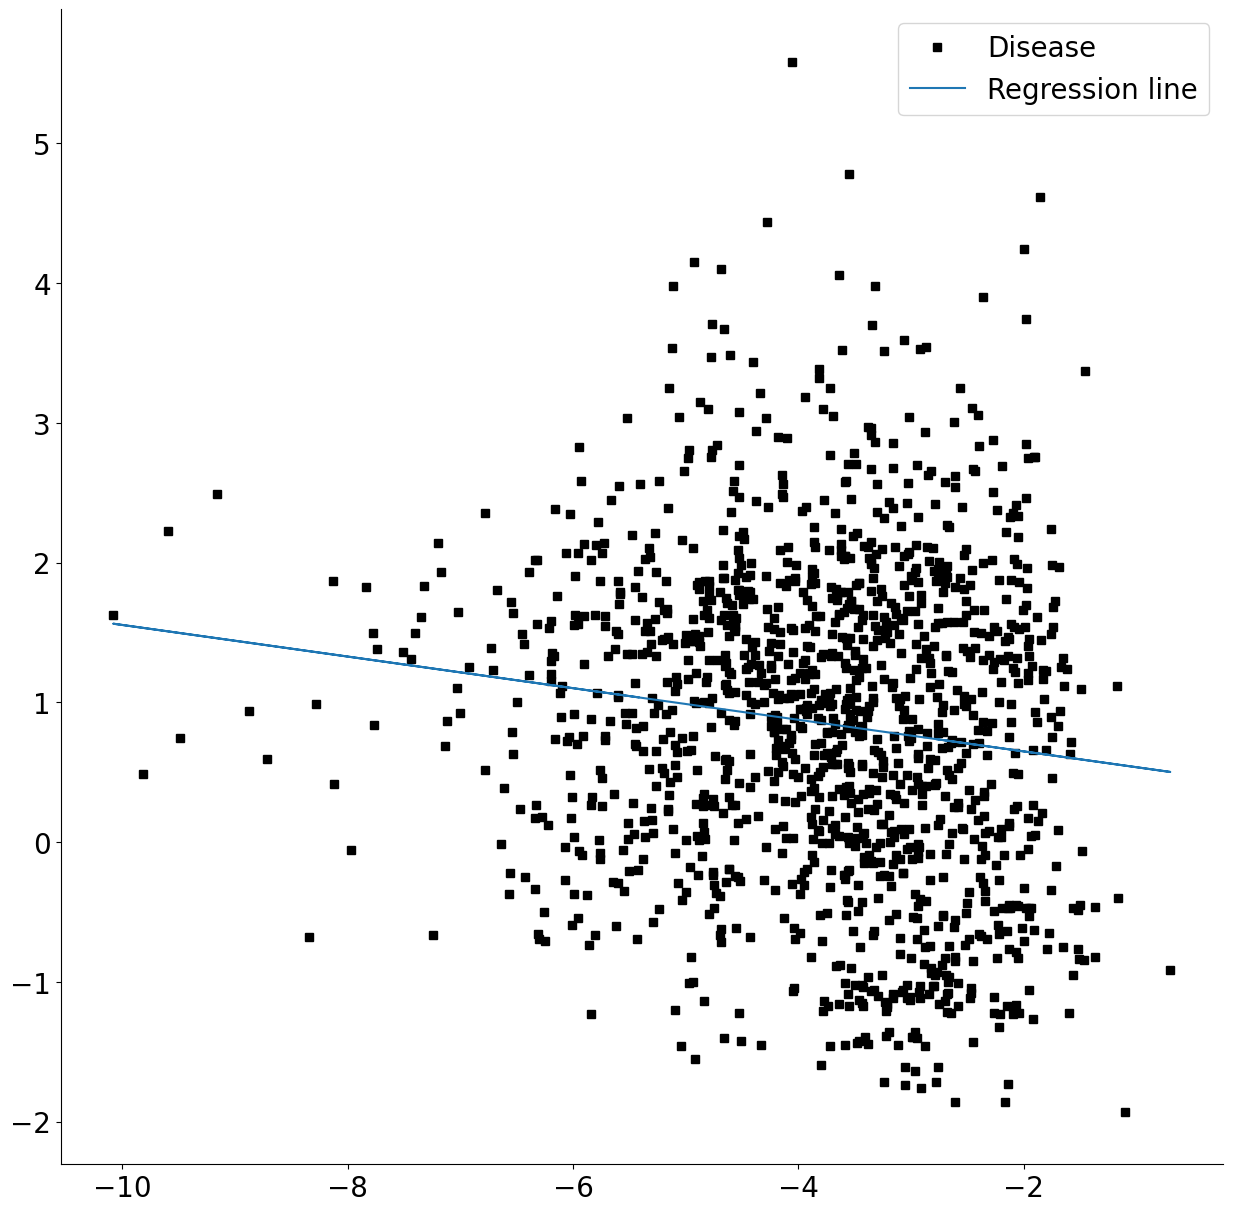

In [85]:
import scipy
proximity_z_list = []
incidence_z_list = []

for country, prox_dis_dict in n_country_water_chem_id_gbd_mean_dict_ext.items():
    for p_dis,p_val in prox_dis_dict.items():
        mu = np.mean(proximal_dis_incidence[p_dis])
        std = np.std(proximal_dis_incidence[p_dis])
        z = (country_dis_incidence[country][p_dis]-mu)/std
        if str(z)!='nan':
            incidence_z_list.append(z)
            proximity_z_list.append(p_val)

fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(proximity_z_list, incidence_z_list)

ax.plot(proximity_z_list,incidence_z_list, linewidth=0, marker='s',c='k', label='Disease')
y=[]
for i in proximity_z_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(proximity_z_list, y, label=line)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

ax.legend(facecolor='white',fontsize=20)
plt.show()  

In [86]:
print(scipy.stats.pearsonr(proximity_z_list,incidence_z_list))  # Pearson's r
print(scipy.stats.spearmanr(proximity_z_list,incidence_z_list)) # Spearman's rho

PearsonRResult(statistic=-0.13152012644049274, pvalue=1.0075097421069587e-06)
SignificanceResult(statistic=-0.14348624684223646, pvalue=9.317723658437707e-08)


In [87]:
#Let's merge together the air and the water pollution

country_pollution_merged_chem_id_dict = {}

for country,chemset in n_country_selected_chem_id_dict.items():
    chem_list=[]
    for chem in chemset:
        if chem not in chem_list:
            chem_list.append(chem)
    for chem in n_country_selected_chem_id_water_dict[country]:
        if chem not in chem_list:
            chem_list.append(chem)
    country_pollution_merged_chem_id_dict[country]= set(chem_list)

In [88]:
tot_pollution_disgenet_gbd_dict_extended = water_disgenet_gbd_dict_extended.copy()

In [89]:
country_tot_proximal_dis_dict={}
for country, chem_list in country_pollution_merged_chem_id_dict.items():
    dis_list=[]
    for chem in chem_list:
        for chem_dis_pair,val in new_significant_exp_dis_proximity_pval_adj.items():
            if chem in chem_dis_pair[0]:
                dis_list.append(chem_dis_pair[1])
    country_tot_proximal_dis_dict[country]=set(dis_list)

In [90]:
tot_proximal_disease_list_extended = [] 

for country, disset in country_tot_proximal_dis_dict.items():
    for dis in disset:
        if dis not in tot_proximal_disease_list_extended:
            tot_proximal_disease_list_extended.append(dis)

print(len(tot_proximal_disease_list_extended))

1258


In [ ]:
for dis in tot_proximal_disease_list_extended:
    if dis not in list(tot_pollution_disgenet_gbd_dict_extended.keys()):
        dis_disgenet_lower = dis.lower()
        possible_dislist = []
        for dis_gbd in disease_set:
            dis_gbd_lower = dis_gbd.lower()
            if len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_disgenet_lower) or len(get_overlap(dis_disgenet_lower,dis_gbd_lower))>0.7*len(dis_gbd_lower):
                possible_dislist.append(dis_gbd)
        if len(possible_dislist)>0:
            print(dis,">", possible_dislist)


In [91]:
#Let's add some more diseases manually

tot_pollution_disgenet_gbd_dict_extended['Anorexia']='Anorexia nervosa'
tot_pollution_disgenet_gbd_dict_extended['lopecia Areata']='Alopecia areata'
tot_pollution_disgenet_gbd_dict_extended['AMYOTROPHIC LATERAL SCLEROSIS 22 WITH OR WITHOUT FRONTOTEMPORAL DEMENTIA ']='Motor neuron disease'


In [100]:
len(tot_pollution_disgenet_gbd_dict_extended)

160

In [115]:
country_tot_mean_prox_dict = {}
for country,disset in country_tot_proximal_dis_dict.items():
    dis_dict = {}
    for dis in disset:
        z_list = [] 
        if len(country_pollution_merged_chem_id_dict[country])>0:
            for chem in country_pollution_merged_chem_id_dict[country]:
                try:
                    z_s = float(final_exp_proximity[chem,dis][1])
                    if z_s<-2:
                        z_list.append(z_s)
                except:
                    pass
        dis_dict[dis]= np.round(np.mean(z_list),2)
                    
    country_tot_mean_prox_dict[country] = dis_dict

#Let's include also the no-proximal diseases in the water
country_tot_mean_prox_water_dict = {}
for country,disdict in country_tot_mean_prox_dict.items():
    if country in new_water_country_distant_dis_dict.keys():
        newdisdict = res = {**disdict, **new_water_country_distant_dis_dict[country]}
        country_tot_mean_prox_water_dict[country]=newdisdict
    else:
        country_tot_mean_prox_water_dict[country] = disdict

#Let's include also the no-proximal diseases in the air
country_tot_mean_prox_tot_dict = {}
for country,disdict in country_tot_mean_prox_dict.items():
    if country in new_country_distant_dis_dict.keys():
        newdisdict = res = {**disdict, **new_country_distant_dis_dict[country]}
        country_tot_mean_prox_tot_dict[country]=newdisdict
    else:
        country_tot_mean_prox_tot_dict[country] = disdict

In [129]:

country_tot_chem_id_gbd_dict = {}
for country,dis_dict in country_tot_mean_prox_tot_dict.items():
    if len(dis_dict)>0:
        dis_z_list = []
        for dis,z in dis_dict.items():
            if dis in tot_pollution_disgenet_gbd_dict_extended.keys():
                dis_z_list.append([tot_pollution_disgenet_gbd_dict_extended[dis],z])
            else:
                if dis in no_prox_air_disset_gbd_dict_cleaned.keys():
                    dis_z_list.append([no_prox_air_disset_gbd_dict_cleaned[dis],z])
                else:
                    if dis in water_faraway_dis_list:
                        dis_z_list.append([dis,z])
                    else:
                        if dis in faraway_manually_added_diseases:
                            dis_z_list.append([dis,z])
                        else:
                            if dis in n_long_faraway_water_disset_gbd_dict_cleaned_v2.keys():
                                dis_z_list.append([n_long_faraway_water_disset_gbd_dict_cleaned_v2[dis],z])
                            else:
                                if dis in ['Congenital Heart Defects','Deafness, Congenital Heart Defects, and Posterior Embryotoxon','Congenital long QT syndrome']:
                                    dis_z_list.append(['Congenital heart anomalies',z])
                                else:
                                    limb_disgenet_name_list = ['Congenital Fiber Type Disproportion','Myopathy, Actin, Congenital, with Excess of Thin Myofilaments',
                                     'Myopathy, Actin, Congenital, With Cores','Muscular Dystrophy, Congenital, Megaconial Type',
                                     'Myotonia Congenita','Myasthenic Syndromes, Congenital','Muscular Dystrophy, Congenital, Megaconial Type',
                                     'Congenital Myasthenic Syndromes, Postsynaptic','Congenital Myasthenic Syndromes, Presynaptic',
                                     'Muscular Dystrophy, Congenital, Due To Integrin Alpha-7 Deficiency','Muscular Dystrophy, Congenital, Type 1D',
                                     'Congenital Fibrosis of the Extraocular Muscles']
                                    if dis in limb_disgenet_name_list:
                                        dis_z_list.append(['Congenital musculoskeletal and limb anomalies',z])
                                    else:
                                        if "Congenital" in dis or "congenital" in dis:
                                            dis_z_list.append(['Congenital birth defects',z])

        country_tot_chem_id_gbd_dict[country] = dis_z_list

In [130]:

from collections import Counter

country_tot_chem_id_gbd_mean_dict = {}
for country,dislist in country_tot_chem_id_gbd_dict.items():
    dis_dict = {}
    dis_list = []
    for el in dislist:
        dis_list.append(el[0])
        
    dis_list_counter_dict = dict(Counter(dis_list).most_common())
    for dis,count in dis_list_counter_dict.items():
        z_list = []
        if count>1:
            for el in dislist:
                if dis==el[0]:
                    z_list.append(el[1])
            dis_dict[dis]=np.round(np.mean(z_list),2)
        else:
            for el in dislist:
                if dis==el[0]:
                    dis_dict[el[0]] = el[1]
    country_tot_chem_id_gbd_mean_dict[country]=dis_dict


In [137]:
tot_dis_list=[] 
for country, disdict in country_tot_chem_id_gbd_mean_dict.items():
    tot_dis_list.extend(list(disdict.keys()))
    
tot_dis_incidence={}
country_set=set(GBD_df['location'])
for dis in set(tot_dis_list):
    incidence_list=[]
    for country in country_set:
        incidence_list.append(country_dis_incidence[country][dis])
    tot_dis_incidence[dis]=incidence_list

In [140]:
len(country_dis_incidence)

204

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/3636774751.py:8: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][p_dis]-mu)/std


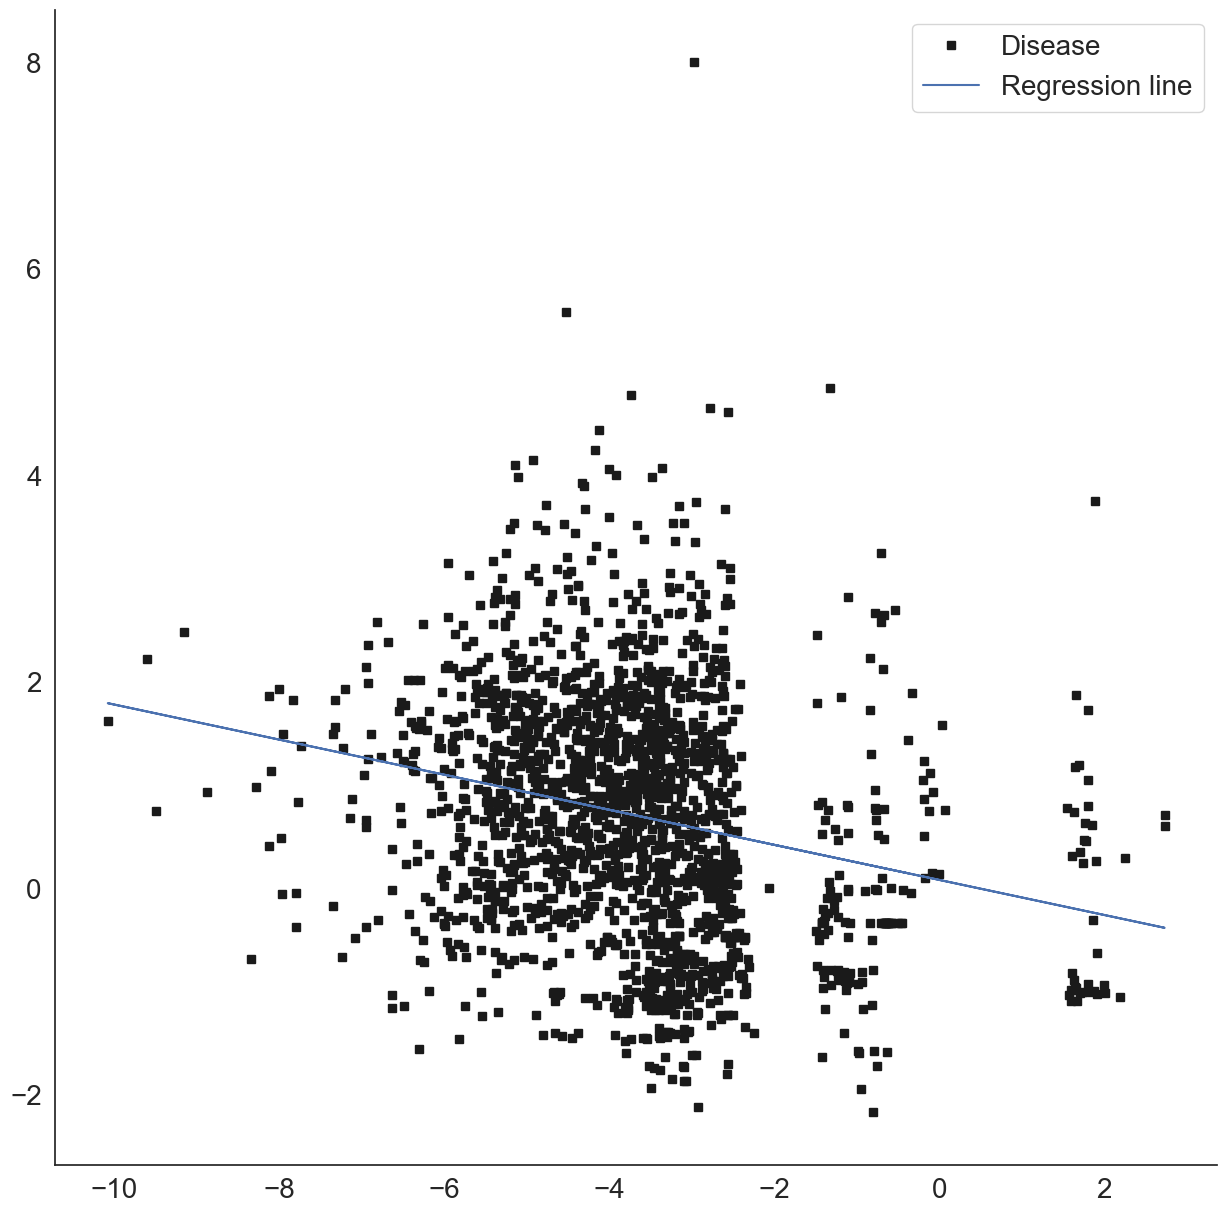

In [141]:
proximity_z_list = []
incidence_z_list = []

for country, dis_dict in country_tot_chem_id_gbd_mean_dict.items():
    for p_dis,p_val in dis_dict.items():
        mu = np.mean(tot_dis_incidence[p_dis])
        std = np.std(tot_dis_incidence[p_dis])
        z = (country_dis_incidence[country][p_dis]-mu)/std
        if str(z)!='nan':
            if str(p_val)!='nan':
                incidence_z_list.append(z)
                proximity_z_list.append(p_val)

fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(proximity_z_list, incidence_z_list)

ax.plot(proximity_z_list,incidence_z_list, linewidth=0, marker='s',c='k', label='Disease')
y=[]
for i in proximity_z_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(proximity_z_list, y, label=line)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

ax.legend(facecolor='white',fontsize=20)
#plt.savefig('output/Figures/SF23_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()    


In [142]:
print(scipy.stats.pearsonr(proximity_z_list,incidence_z_list))  # Pearson's r
print(scipy.stats.spearmanr(proximity_z_list,incidence_z_list)) # Spearman's rho

PearsonRResult(statistic=-0.22840797760148943, pvalue=4.873708096928792e-24)
SignificanceResult(statistic=-0.2650151778047855, pvalue=4.4497585612358177e-32)


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/2807508430.py:10: RuntimeWarning: invalid value encountered in scalar divide
  z = (country_dis_incidence[country][p_dis]-mu)/std
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/2807508430.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/2807508430.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, size = 36)
/Users/lsd/anaconda3/envs/Exposurome/lib/python3.

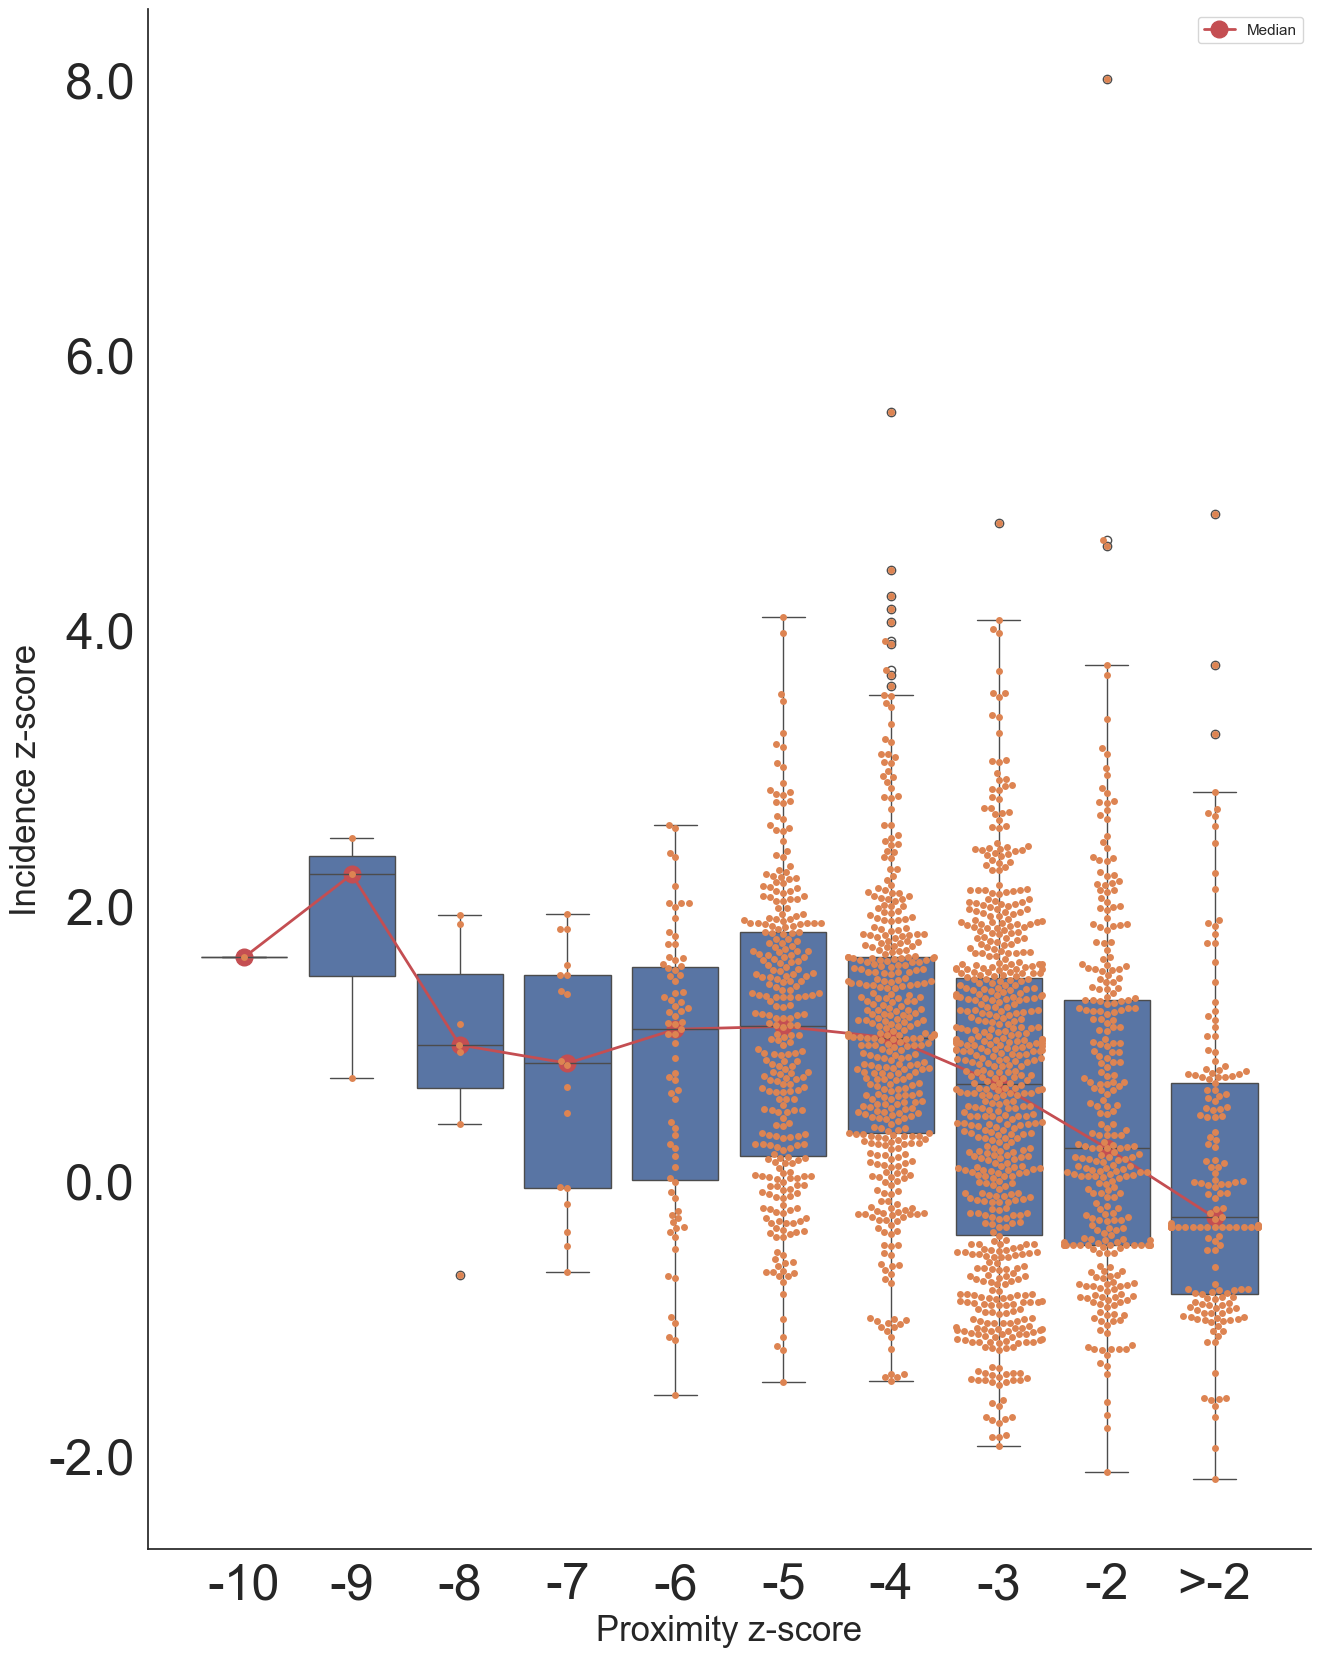

In [145]:
import seaborn as sns

proximity_z_list = []
incidence_z_list = []

for country, dis_dict in country_tot_chem_id_gbd_mean_dict.items():
    for p_dis,p_val in dis_dict.items():
        mu = np.mean(tot_dis_incidence[p_dis])
        std = np.std(tot_dis_incidence[p_dis])
        z = (country_dis_incidence[country][p_dis]-mu)/std
        if str(z)!='nan':
            if str(p_val)!='nan':
                incidence_z_list.append(z)
                if p_val<-2:
                    proximity_z_list.append(str(int(p_val)))
                else:
                    proximity_z_list.append(">-2")

tot_chem_pollution_zscore_df = pd.DataFrame()
tot_chem_pollution_zscore_df['Incidence z-score']=incidence_z_list
tot_chem_pollution_zscore_df['Proximity z-score']=proximity_z_list




# Assuming 'new_water_pollution_zscore_df' is your DataFrame and is already loaded
fig, ax = plt.subplots(figsize=(15, 20))
sns.set(style="white")

# Define the order of the categories explicitly if it's not alphabetical
order = ["-10","-9","-8","-7","-6","-5","-4","-3","-2",">-2"]

# Draw the violin plot
violin = sns.boxplot(data=tot_chem_pollution_zscore_df, x="Proximity z-score", y="Incidence z-score",
                        order=order, ax=ax)
swar = sns.swarmplot(data=tot_chem_pollution_zscore_df, x="Proximity z-score", y="Incidence z-score",
                        order=order, ax=ax)

plt.ylabel('Incidence z-score', fontsize=25)
plt.xlabel('Proximity z-score', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(order, size = 36)

# Calculate medians and plot a line connecting them
medians = tot_chem_pollution_zscore_df.groupby('Proximity z-score')['Incidence z-score'].median().reindex(order)

# Convert category names (order) to numeric values for plotting
# This is necessary as the line plot requires numeric x-values
positions = np.arange(len(order))

# Plot the median line
ax.plot(positions, medians, marker='o', markerfacecolor='r', color='r', linestyle='-', linewidth=2, markersize=12, label='Median')

plt.legend()  # Show legend
plt.savefig('output/Figures/Figure4D_v09.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [575]:
tot_chem_list = []
for country,expset in n_country_selected_chem_id_water_dict.items():
    for exp in expset:
        tot_chem_list.append(exp)
        
tot_chem_counter = dict(Counter(tot_chem_list))

for country,expset in n_country_selected_chem_id_water_dict.items():
    for exp in expset:
        if tot_chem_counter[exp]<3:
            if len(chem_gene_dictio_cleaned_ppi[exp])<50:
                print(country,exp)


Malta D002713
Czechia C000188
Ireland C477694
Spain D006533
Norway D000641
Norway C024566
Italy D008917
Italy C477694
Italy D002706
Italy C000188
Italy D006533
Italy D007631
Italy D004732
France D008917
France D007631
United Kingdom D009589


In [587]:
#Let's check the country with the lowest concentration of tetrachloroethylene
country_list = list(country_chem_conc_mean_water_dict.keys())

for c in country_list:
    if 'Endrin' in country_chem_conc_mean_water_dict[c].keys():
        print(c,country_chem_conc_mean_water_dict[c]['Endrin'])


#Endrin,D004732,central_module_exposures_list, Italy is the highest, France is the lowest, but careful because in France there are also
#other pesticides

#Heptachlor,D006533,central_module_exposures_list, Spain has way lower concentration, but we said that it is higlhy specific for Spain too...




Italy 45.7
France 1.2


In [692]:
#Let's try again with a different time window


In [61]:
no_prox_dis= [] 
for chempair,z_dict in exp_proximity_not_significant.items():
    if chempair[0]=='D004732':
        no_prox_dis.append(chempair[1])

In [62]:
len(no_prox_dis)

6000

In [71]:

for dis in no_prox_dis:
    disgene=diseases_genes_associated_ppi[dis]
    if len(disgene)>5 and len(disgene)<25:
        dissubgraph =  G_ppi.subgraph(disgene)
        dis_sub_net = dissubgraph.subgraph(max(nx.connected_components(dissubgraph), key=len))
        if dis_sub_net.number_of_nodes() > 4:
            if dis in new_country_distant_dis_dict['Italy'].keys():
                print(dis)


Cataract


In [73]:
# open file in write mode
with open('output/Cataract.txt', 'w') as fp:
    for item in diseases_genes_associated_ppi['Cataract']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [155]:
#Endrin

GBD_df_Endrin =pd.read_csv("input/Disease/GBD/IHME-GBD_2019_DATA-cdf37d69_short.csv")

endrin_prox_dislist = ['Colon and rectum cancer','Breast cancer','Pancreatic cancer','Ovarian cancer','Prostate cancer',
'Myelodysplastic, myeloproliferative, and other hematopoietic neoplasms','Acute myeloid leukemia']


In [156]:
GBD_df_Endrin_sub = GBD_df_Endrin[GBD_df_Endrin['cause_name'].isin(endrin_prox_dislist)]


In [157]:
GBD_df_Endrin_incidence = GBD_df_Endrin_sub[(GBD_df_Endrin_sub['measure_name'] == 'Incidence') & (GBD_df_Endrin_sub['metric_name'] == 'Rate')]
GBD_df_Endrin_prevalence = GBD_df_Endrin_sub[(GBD_df_Endrin_sub['measure_name'] == 'Prevalence') & (GBD_df_Endrin_sub['metric_name'] == 'Rate')]
GBD_df_Endrin_deaths = GBD_df_Endrin_sub[(GBD_df_Endrin_sub['measure_name'] == 'Deaths') & (GBD_df_Endrin_sub['metric_name'] == 'Rate')]
GBD_df_Endrin_dalys = GBD_df_Endrin_sub[(GBD_df_Endrin_sub['measure_name'] == 'DALYs') & (GBD_df_Endrin_sub['metric_name'] == 'Rate')]







In [158]:
GBD_df_Endrin_incidence_dict={}
for country in set(GBD_df_Endrin_incidence['location_name'].tolist()):
    dis_dict={}
    for dis in set(GBD_df_Endrin_incidence['cause_name'].tolist()):
        dis_dict[dis]= list(GBD_df_Endrin_incidence.loc[(GBD_df_Endrin_incidence['location_name']==country) & (GBD_df_Endrin_incidence['cause_name']==dis),'val'].values)

    GBD_df_Endrin_incidence_dict[country]=dis_dict



In [159]:
#Let's divide everything for the global median value
new_normalized_value=[]
for i,v in GBD_df_Endrin_incidence.iterrows():
    median_value=np.median(GBD_df_Endrin_incidence_dict['Global'][v['cause_name']])
    if median_value!=0:
        new_normalized_value.append(v['val']/median_value)
    else:
        new_normalized_value.append(v['val'])
    
GBD_df_Endrin_incidence['normalized_val']=new_normalized_value

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/1585757122.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GBD_df_Endrin_incidence['normalized_val']=new_normalized_value


In [160]:
GBD_df_Endrin_normalized_incidence_dict = {}

for country in set(GBD_df_Endrin_incidence['location_name'].tolist()):
    dis_dict={}
    for dis in set(GBD_df_Endrin_incidence['cause_name'].tolist()):
        dis_dict[dis]= list(GBD_df_Endrin_incidence.loc[(GBD_df_Endrin_incidence['location_name']==country) & (GBD_df_Endrin_incidence['cause_name']==dis),'normalized_val'].values)

    GBD_df_Endrin_normalized_incidence_dict[country]=dis_dict


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/216567843.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


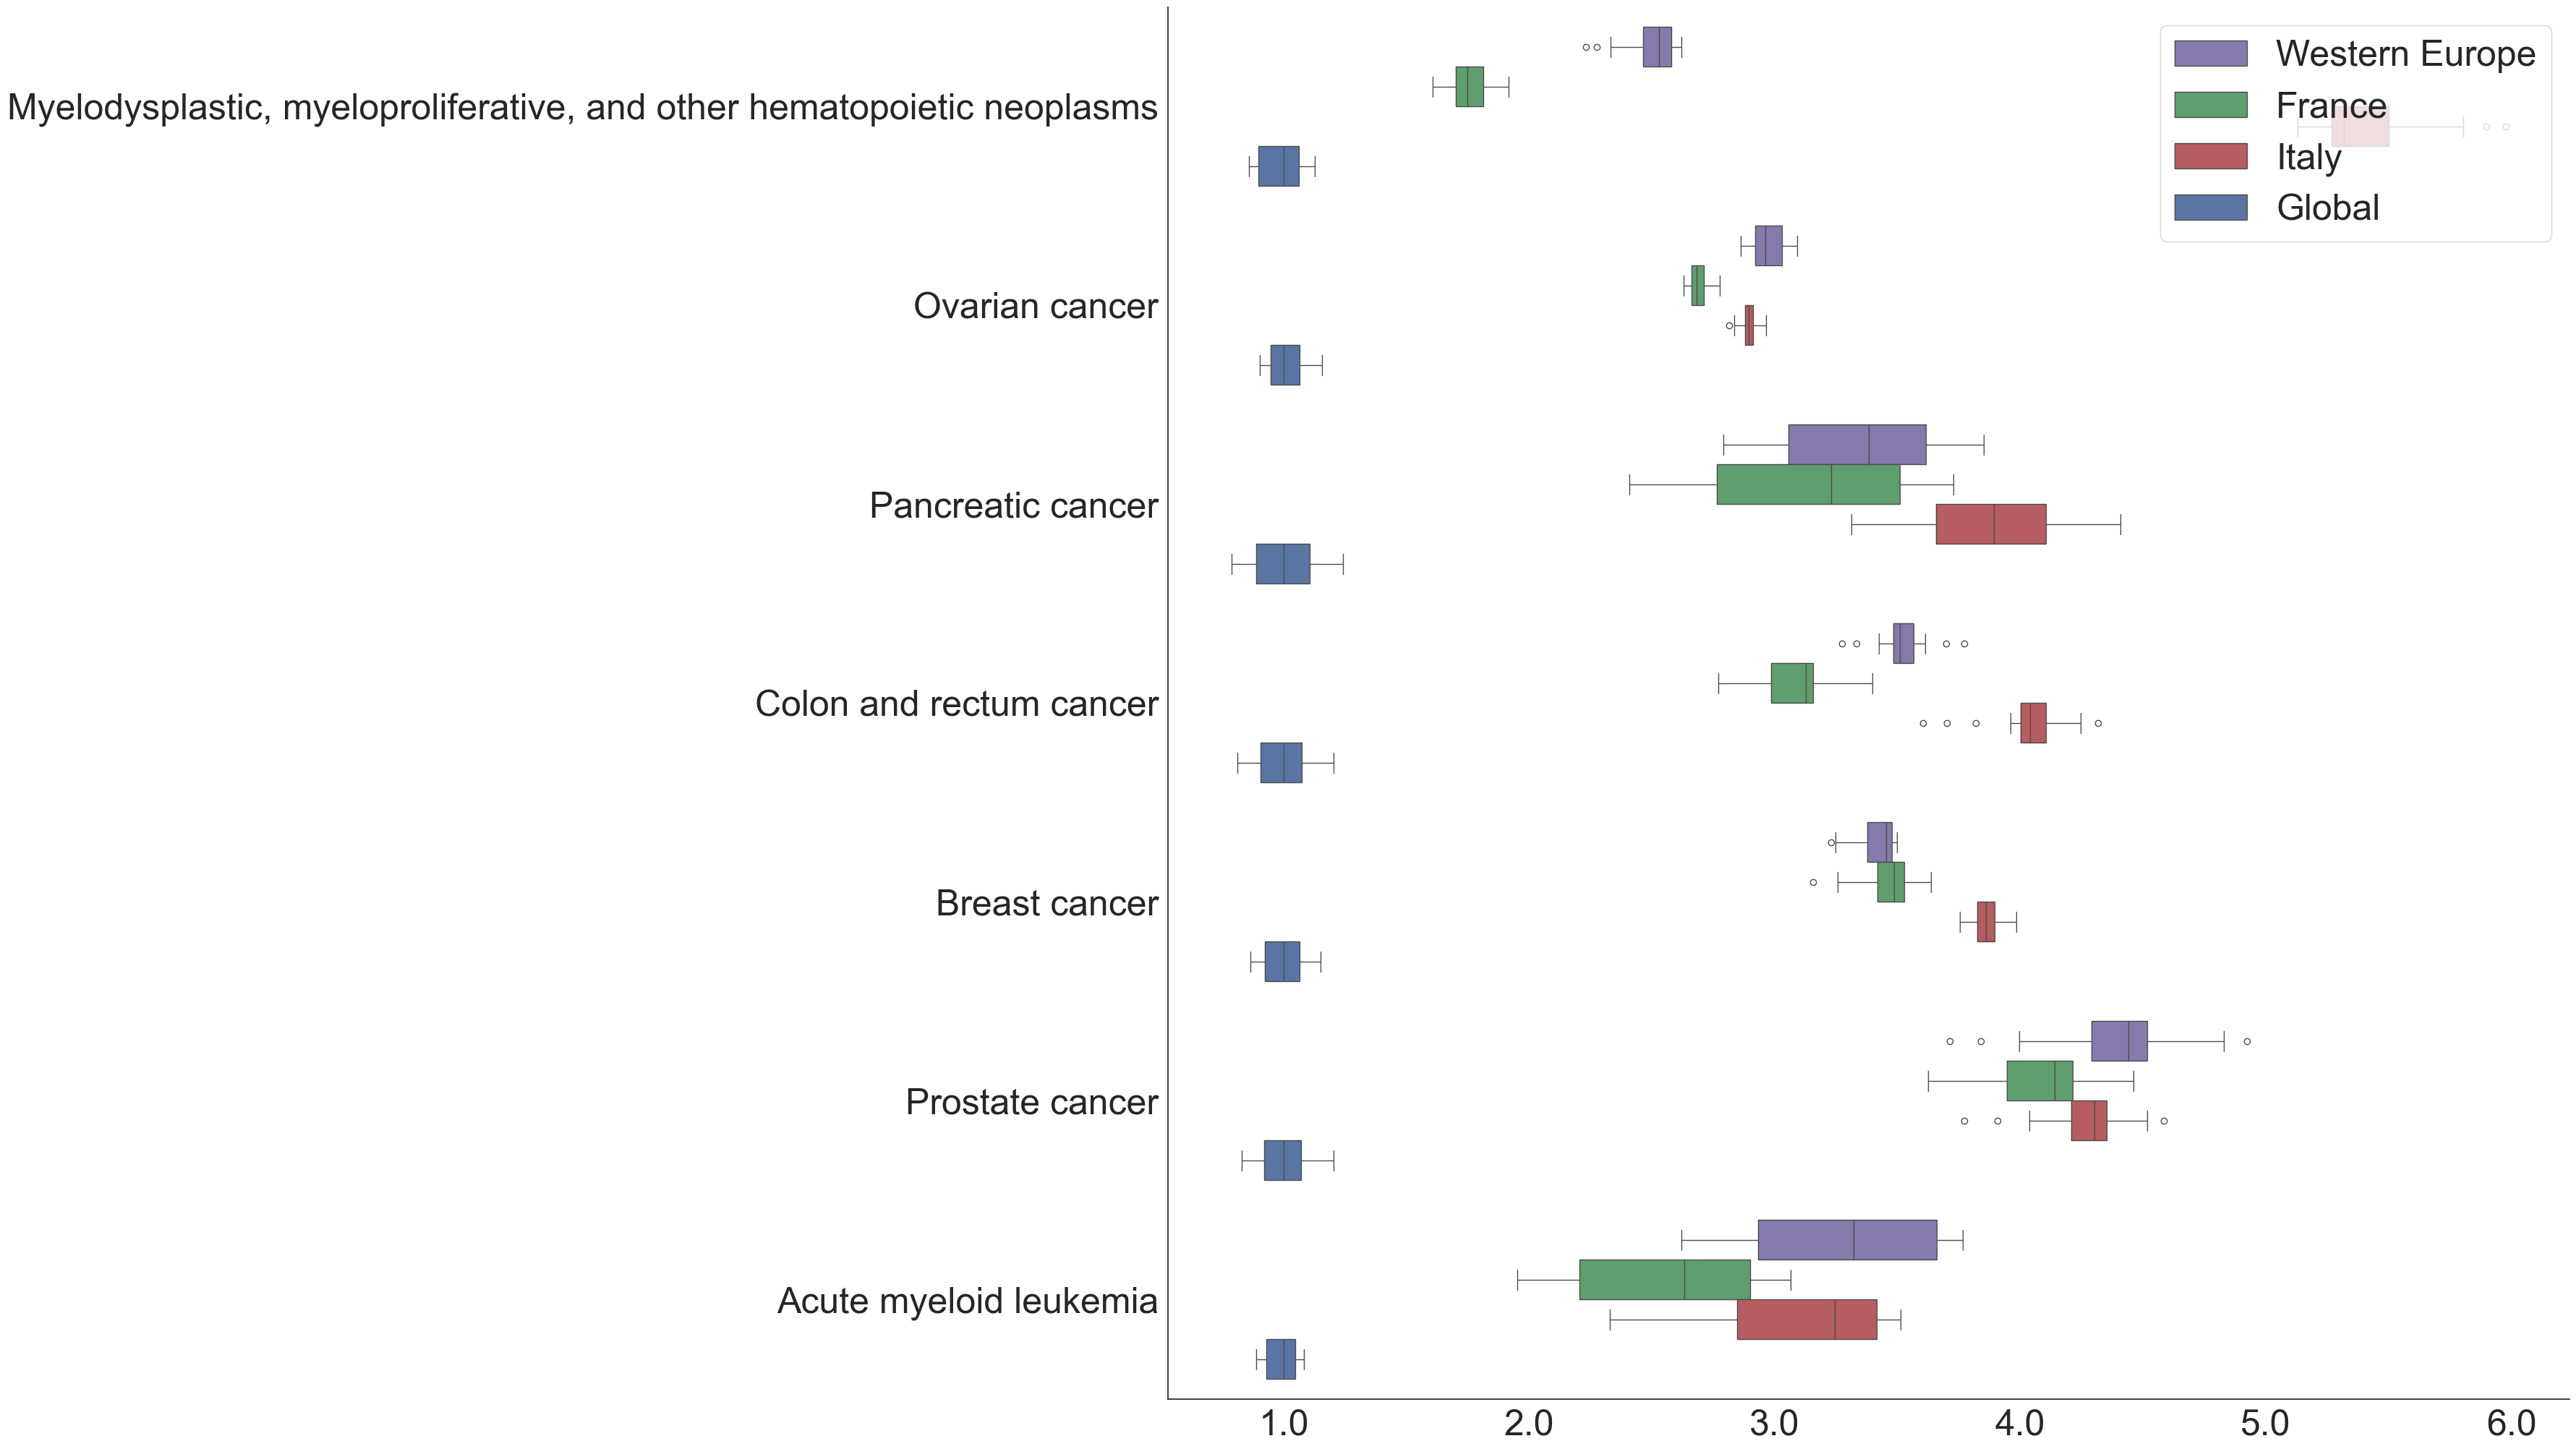

In [161]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(25, 25))
sns.set(style="white")
# Draw a nested boxplot to show bills by day and time
g=sns.boxplot(x="normalized_val", y="cause_name",orient="h",
            hue="location_name", palette=["m", "g","r","b"],
            data=GBD_df_Endrin_incidence)
fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)
#g.set_xscale("log")
plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


#plt.savefig('output/Figures/Figure4C.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

#plt.title('Incidence for tetrachloroethylene-proximal diseases from 2000 to 2019', fontsize=25)


In [162]:
gbd_westerneurope_dict = {}

for dis, inlist in GBD_df_Endrin_normalized_incidence_dict['Western Europe'].items():
    gbd_westerneurope_dict[dis] = np.mean(inlist)

gbd_westerneurope_dict_sort = {k: v for k, v in sorted(gbd_westerneurope_dict.items(), key=lambda item: item[1],reverse=True)}

In [163]:

my_order = list(gbd_westerneurope_dict_sort.keys())

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/2757657819.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


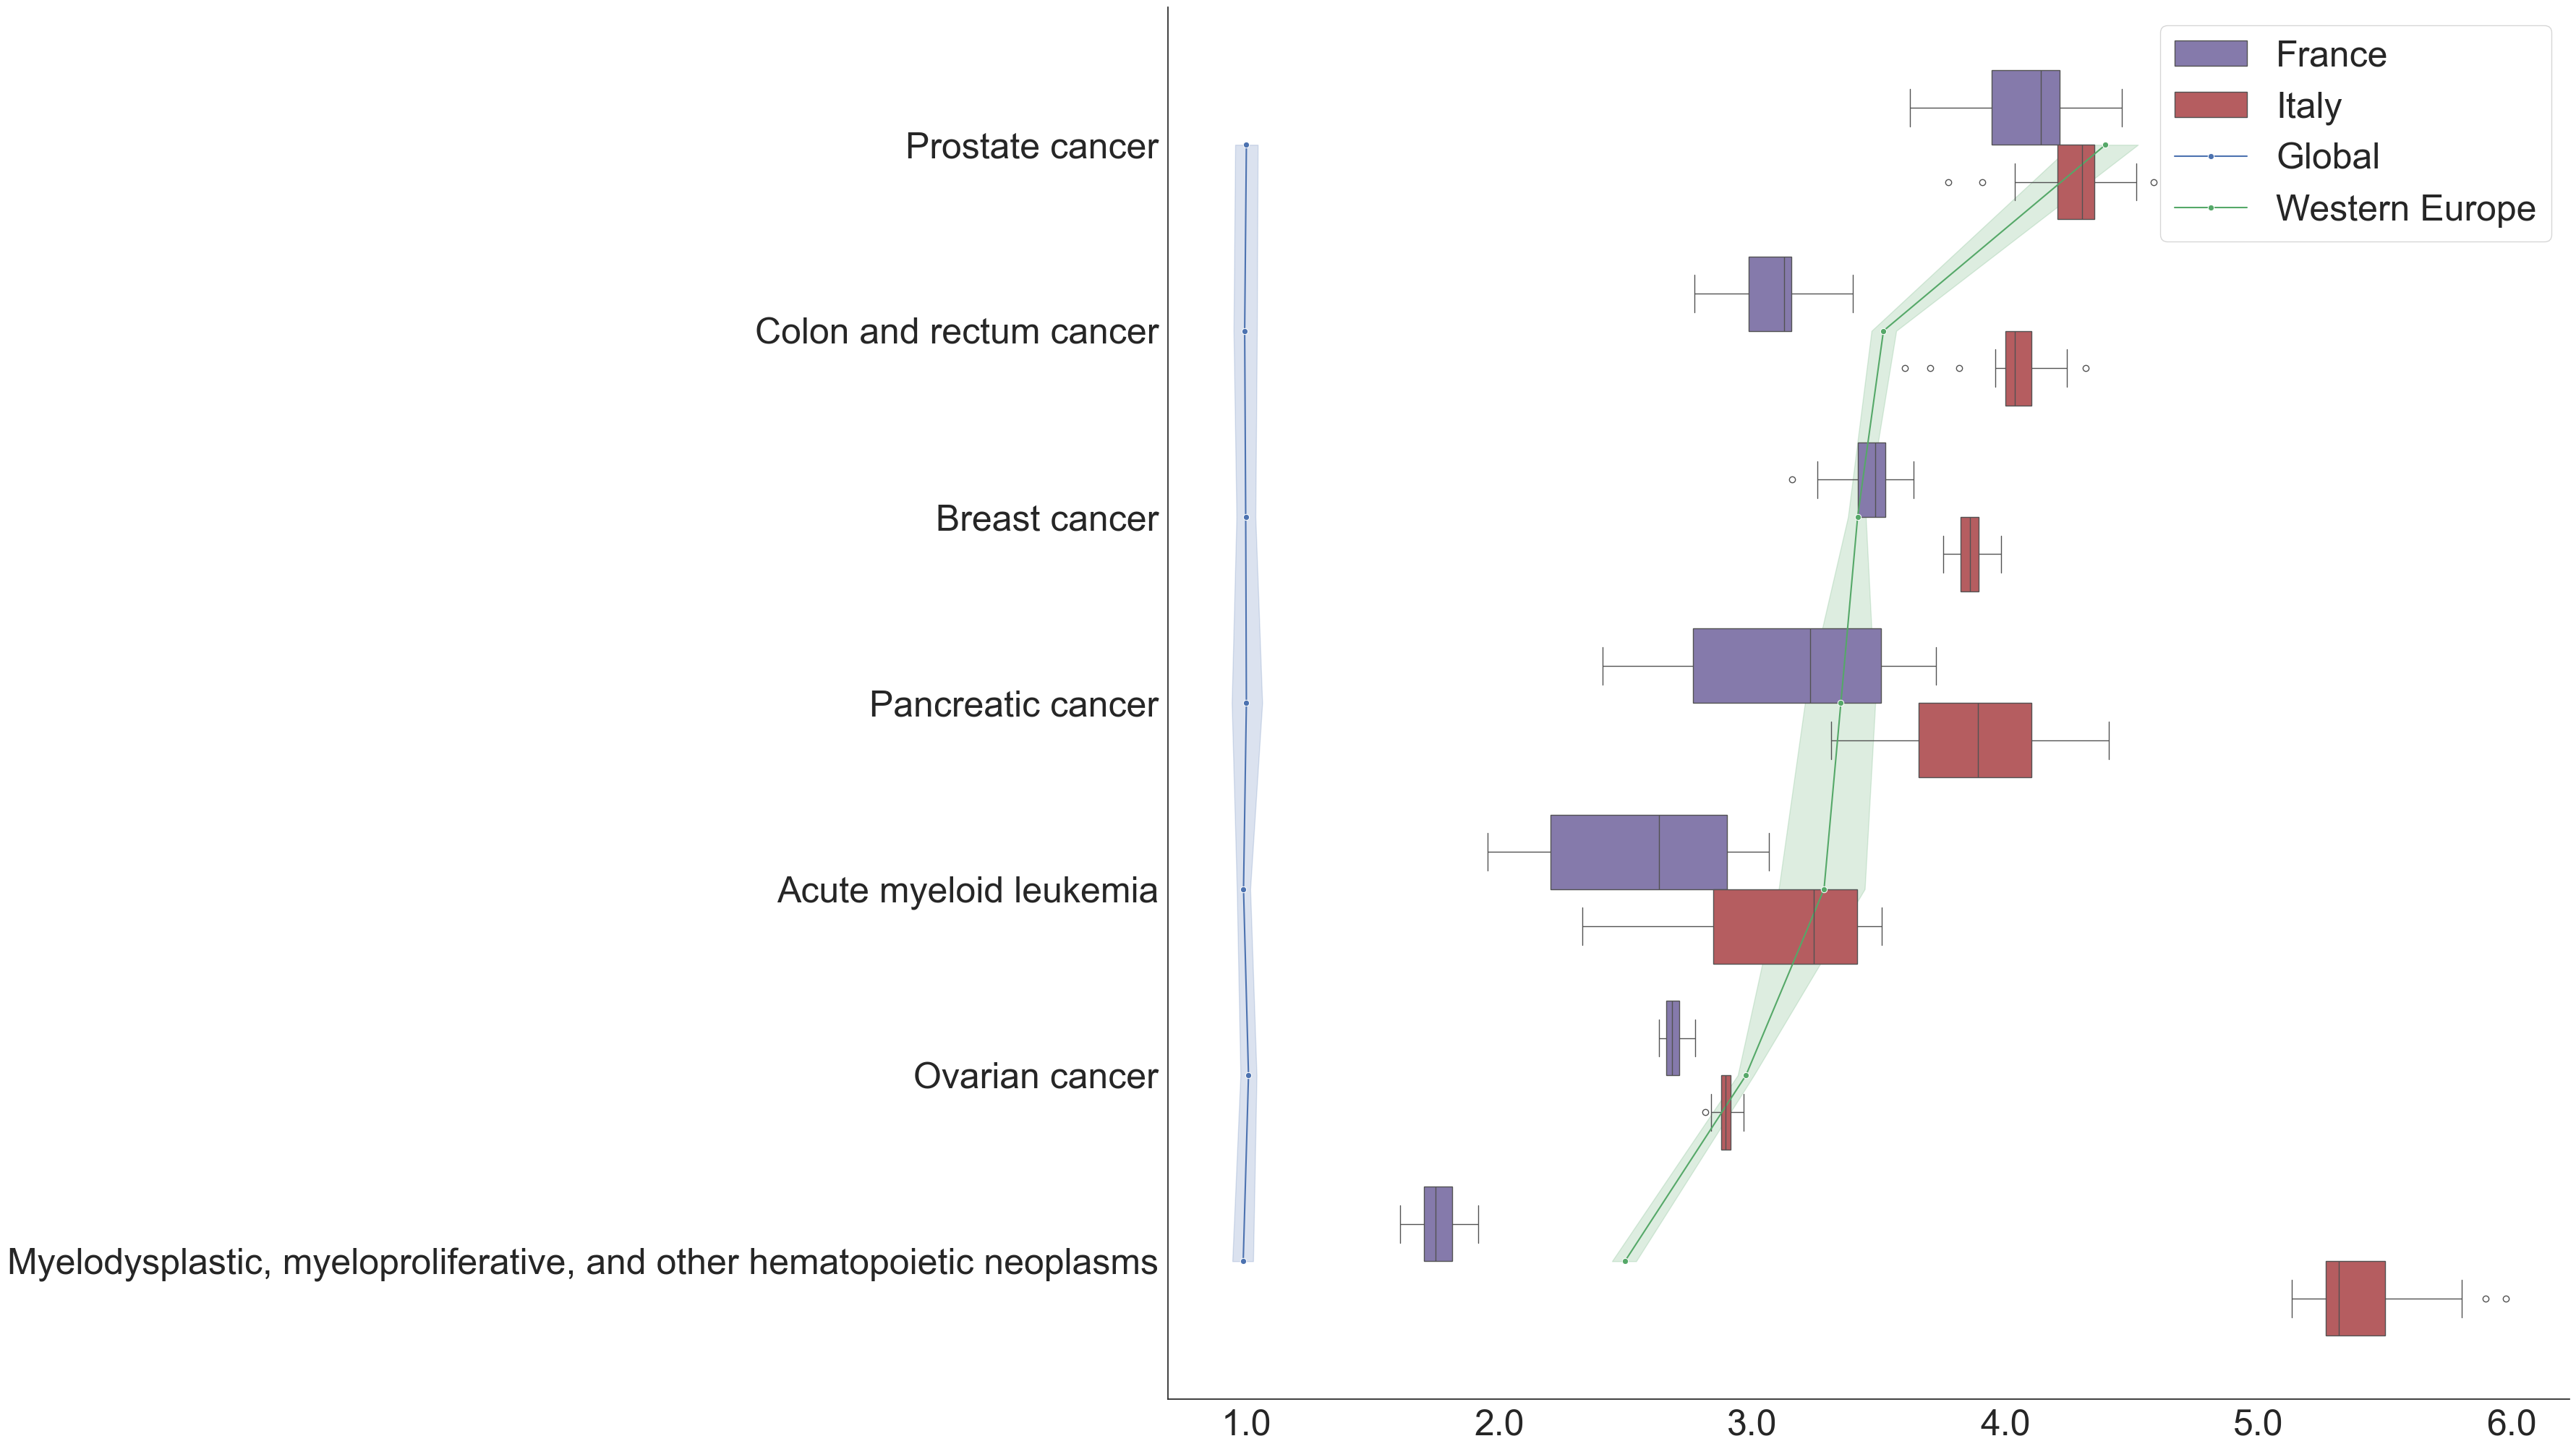

In [164]:
df_not_global = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] != 'Global']
df_not_global_real = df_not_global[df_not_global['location_name'] != 'Western Europe']
df_global = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] == 'Global']
df_europe = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] == 'Western Europe']
df_global_sorted = df_global.set_index('cause_name').loc[my_order].reset_index()
df_europe_sorted = df_europe.set_index('cause_name').loc[my_order].reset_index()
fig, ax = plt.subplots(figsize=(25, 25))
sns.set(style="white")
# Draw a nested boxplot to show bills by day and time
g=sns.boxplot(x="normalized_val", y="cause_name",orient="h",order=my_order,
            hue="location_name", palette=["m","r"],
            data=df_not_global_real)

g = sns.lineplot(data=df_global, y='cause_name', x='normalized_val',orient="y",
                 hue='location_name', style='location_name', markers=True,
                 dashes=False, palette=["b"])

g = sns.lineplot(data=df_europe, y='cause_name', x='normalized_val',orient="y",
                 hue='location_name', style='location_name', markers=True,
                 dashes=False, palette=["g"])

fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


#plt.savefig('output/Figures/Fig4G.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()



/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_90816/214378768.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


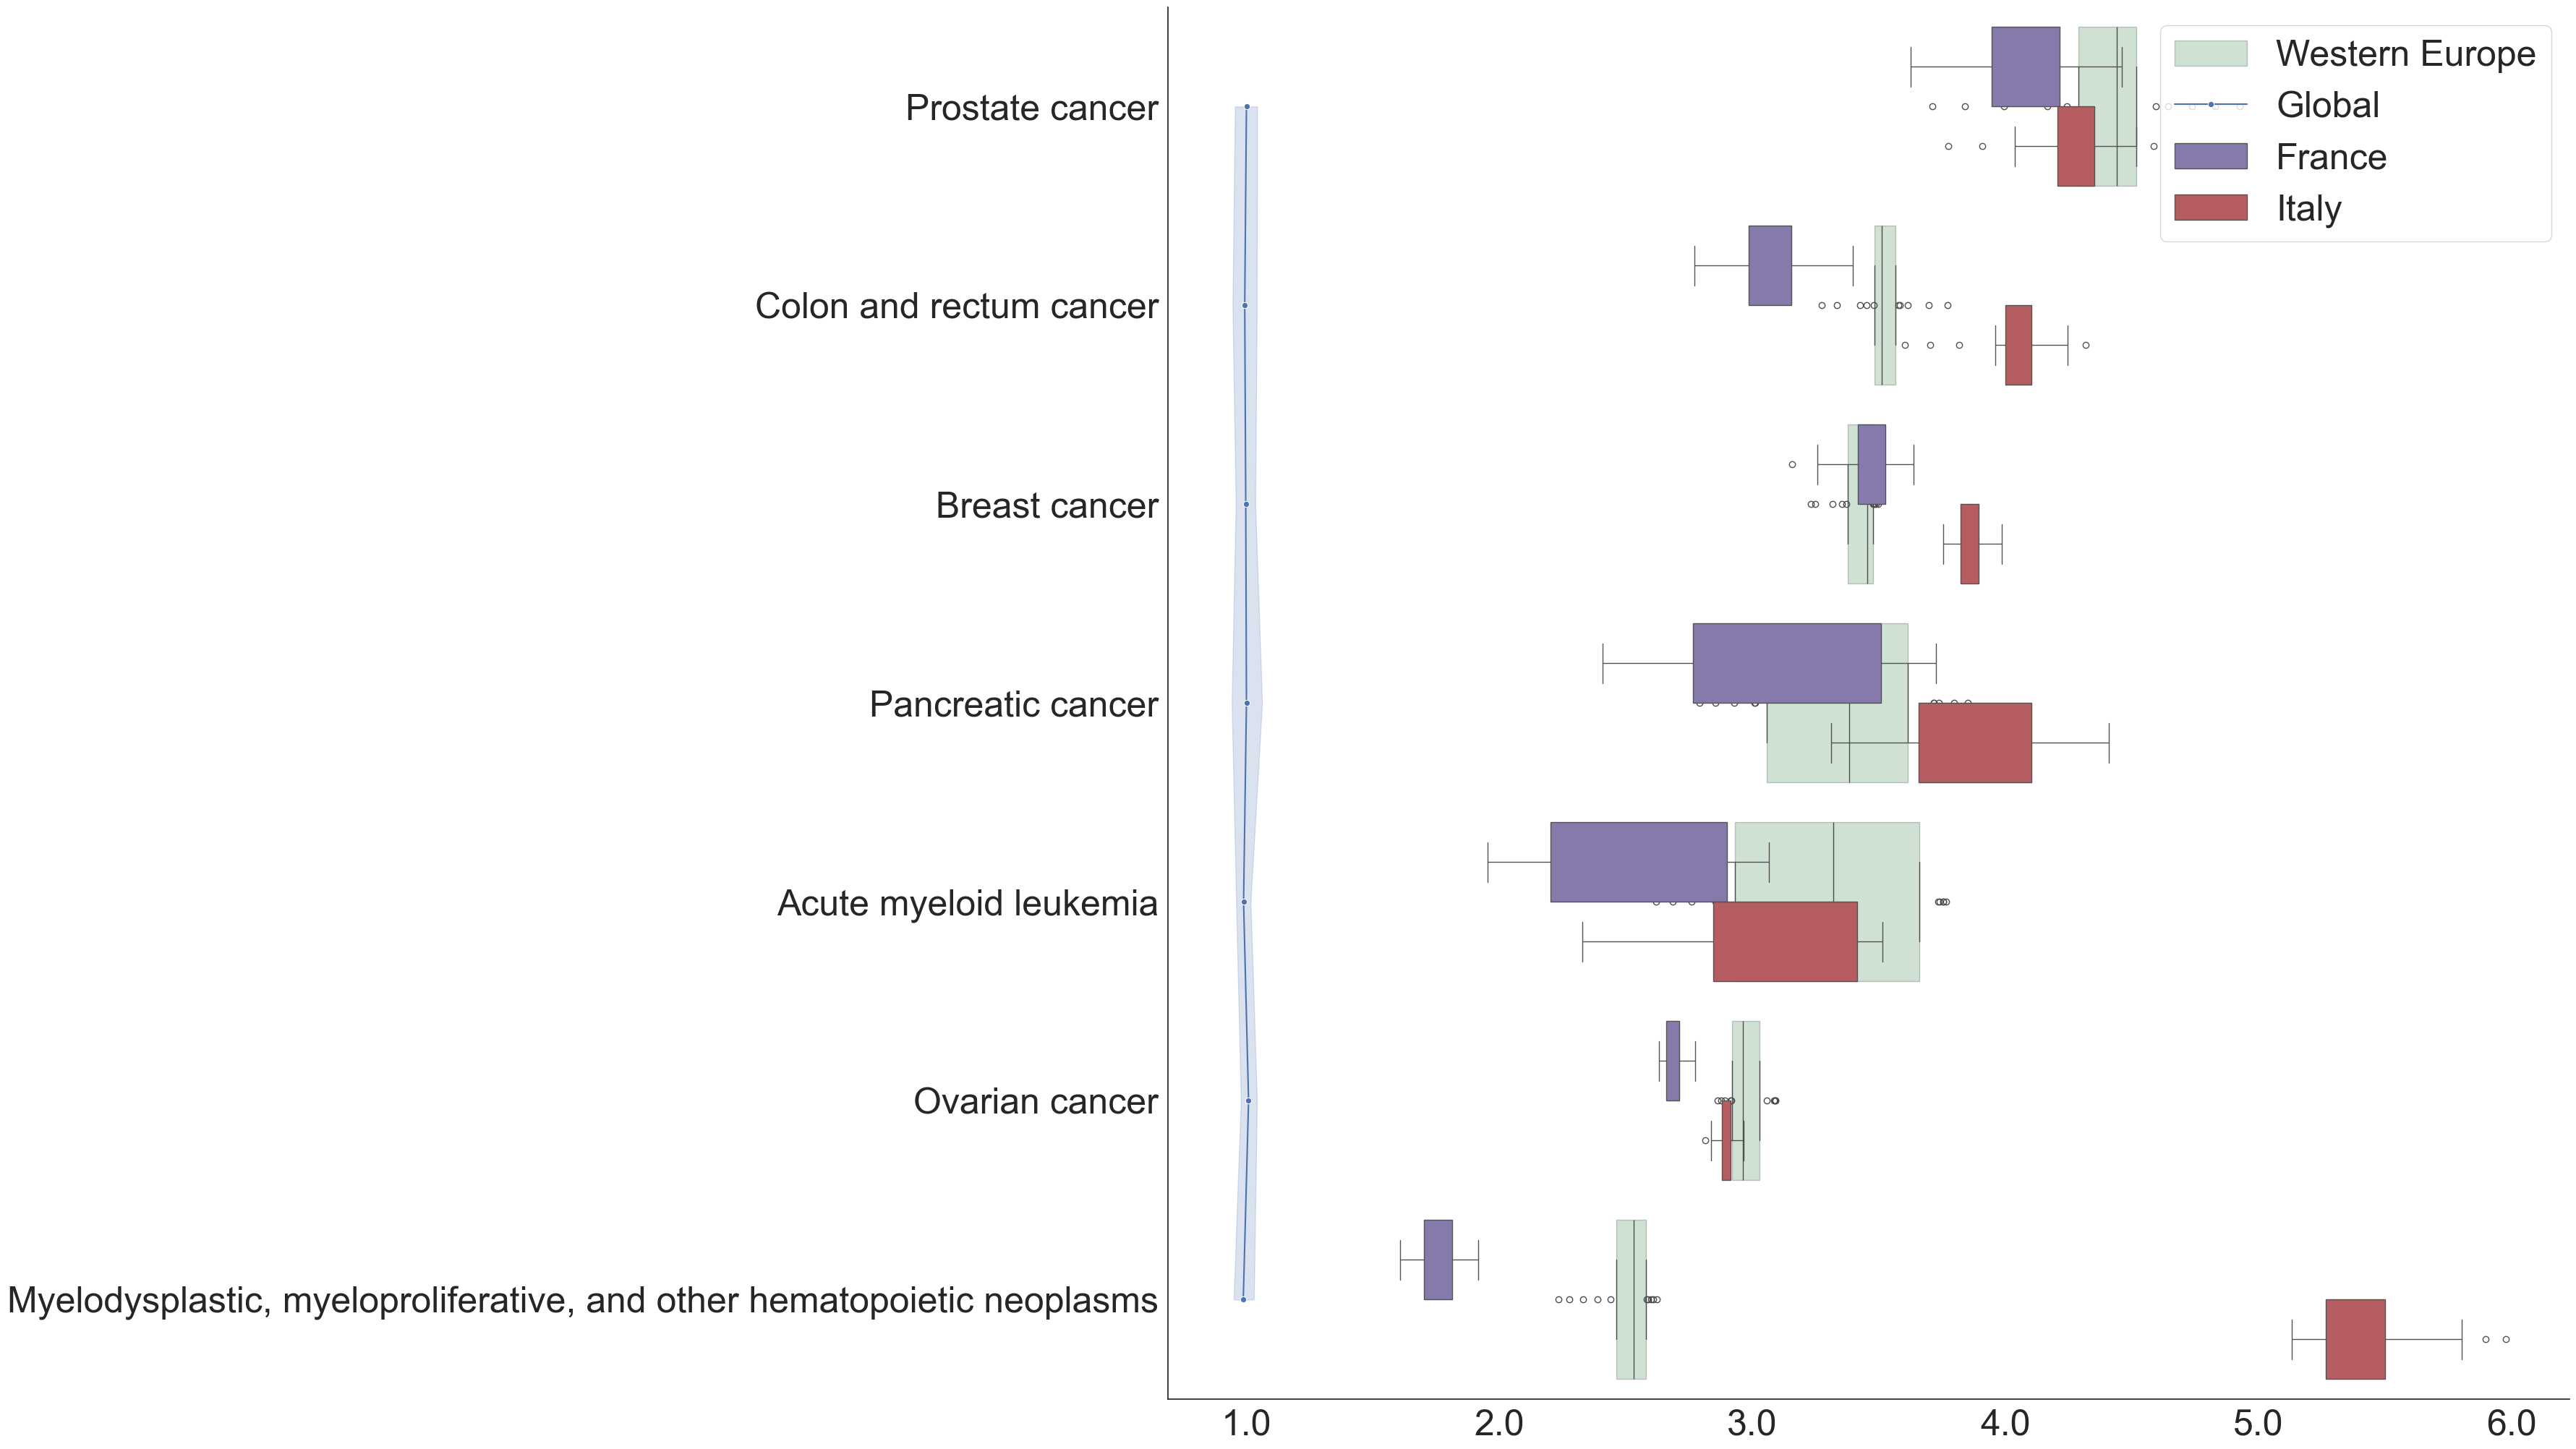

In [191]:
df_not_global = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] != 'Global']
df_not_global_real = df_not_global[df_not_global['location_name'] != 'Western Europe']
df_global = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] == 'Global']
df_europe = GBD_df_Endrin_incidence[GBD_df_Endrin_incidence['location_name'] == 'Western Europe']
df_global_sorted = df_global.set_index('cause_name').loc[my_order].reset_index()
df_europe_sorted = df_europe.set_index('cause_name').loc[my_order].reset_index()
fig, ax = plt.subplots(figsize=(25, 25))
sns.set(style="white")


g=sns.boxplot(x="normalized_val", y="cause_name",orient="h",order=my_order,
            hue="location_name", palette=["g"],saturation=0.75,whis=0,boxprops=dict(zorder=1,alpha=.3),
            data=df_europe)


g = sns.lineplot(data=df_global, y='cause_name', x='normalized_val',orient="y",
                 hue='location_name', style='location_name', markers=True,
                 dashes=False, palette=["b"])

g=sns.boxplot(x="normalized_val", y="cause_name",orient="h",order=my_order,boxprops=dict(zorder=11),
            hue="location_name", palette=["m","r"],
            data=df_not_global_real)




fontsize = 36
plt.legend(loc="upper right", frameon=True, fontsize=fontsize)
plt.yticks(fontsize=36)

plt.ylabel('', fontsize=25)
plt.xlabel('', fontsize=25)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=36)
    ax.set_ylabel(l, fontsize=36)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels([round(y,2) for y in ax.get_xticks()], size = 36)


plt.savefig('output/Figures/Figure4G_v09.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()


In [877]:
np.mean(GBD_df_Endrin_normalized_incidence_dict['Italy']['Colon and rectum cancer'])

4.027498051871538

In [879]:
np.mean(GBD_df_Endrin_normalized_incidence_dict['Global']['Colon and rectum cancer'])

0.9941305932100033

In [880]:
np.mean(GBD_df_Endrin_normalized_incidence_dict['Western Europe']['Colon and rectum cancer'])

3.5183873336115523